In [ ]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self, model_file):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        # self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        # self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        # self.ampl.eval("display h;")
        # self.ampl.eval("display solve_result;")
        # self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")
        self.ampl.eval("display con2.dual;")
                        
    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()

    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
        
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
        
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph2(self, super_source_out_arc=None, best_arc=None, current_cost=None, iteration=1):
        new_positions0 = {
         2 : (2000.00, 3000.00),
         3 : (1000.00, 3000.00),        
         4 : (2000.00, 2000.00),        
         5 : (1000.00, 2000.00),       
         6 : (2000.00, 1000.00),       
         7 : (1000.00, 1000.00),      
         1 : (3000.00, 3000.00)     
        } 
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)
        
        plt.figure(figsize=(8, 6))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Annotate node demands
        # for node, (x, y) in pos.items():
        #     demand = self.network_graph.nodes[node].get('demand', 0)  # Get node demand, default to 0
        #     plt.text(x, y + 0.05, f"{demand}", fontsize=8, ha='center', color='blue')  # Annotate demand above the node

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='black', label='Regular Arcs')
        
        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1, label='Best arc')
        
        # Annotate edge weights
        for u, v, data in self.network_graph.edges(data=True):
            weight = data.get('weight', 0)  # Get edge weight, default to 0
            mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
            mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
            plt.text(mid_x, mid_y, f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line, best_edge_line], loc='lower right')
        
        # Display total cost in the title
        cost = round(self.total_cost)
        plt.title(f"Total Cost: {'{:,}'.format(cost)}")
        
        # Save the plot
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications

        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  

        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       

        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        # pos = new_positions1
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge

        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')

        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))

    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")
        
        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)
        
        # Start DFS from the specified root
        dfs(root)
        
        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")
        
        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  
        
        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()
        
    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  
        
    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
        
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
        
    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)  
        D = self.ampl.getParameter('D').getValues().to_dict()  

        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        print("\nPresolve the model for fixing the flow value in the leaf arcs")
        print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] += flow_value
                        print(f"Fixing flow for arc {edge}: {-flow_value}")

                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {-flow_value};")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            print(f"Fixing flow for arc {edge}: {flow_value}")
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            print(f"Fixing flow for arc {edge}: {flow_value}")
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            print(f"Fixing flow for arc {edge}: {flow_value}")
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")

                        # self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {-flow_value};")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        # self.load_model(self.model_file)
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three
    
    def multistart(self, inarc, current_cost, best_acyclic_flow, improved, super_source_out_arc, iteration):
        max_l = max(self.ampl.getParameter('L').to_dict().values())
        max_q = self.ampl.getParameter('D').getValues().toDict()
        # print(max_q[1])
        # for i, value in max_q.items():
        #     print(value)
        
        source = self.ampl.getSet('Source').to_list()
        E = self.ampl.getParameter('E').getValues().toDict()
        P = self.ampl.getParameter('P').getValues().toDict()
        # Define the number of starts for multistart heuristic
        num_starts = 10
        
        # Set a random seed for reproducibility
        random.seed(num_starts)
        
        # Loop for multistart heuristic
        for start in range(num_starts):
            
            for (i,j) in self.ampl.get_set("arcs").to_list():
                for k in self.ampl.get_set("pipes").to_list():
                    value = random.uniform(0, max_l)  
                    self.ampl.eval(f' let l[{i},{j},{k}] := {value};')
                    
            for (i,j) in self.network_graph.edges:
                if (i,j) not in inarc:
                    if (i,j) in self.ampl.get_set("arcs").to_list():
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
                else:
                    if (i,j) in self.ampl.get_set("arcs").to_list():
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
            
            # for (i,j) in self.ampl.get_set("arcs").to_list():
            #     value = random.uniform(max_q[1], -max_q[1])  
            #     self.ampl.eval(f'let q[{i},{j}] := {value};')
            
            for i in self.ampl.get_set("nodes").to_list():
                value = random.uniform(E[i]+P[i], E[source[0]])  
                self.ampl.eval(f'let h[{i}] := {value};')
            self.ampl.set_option("solver", "ipopt")
            self.ampl.set_option("ipopt_options", "outlev = 0")
            # ampl.option[""]
            self.ampl.solve()
            
            if self.ampl.solve_result == 'solved':
                cost = self.ampl.get_objective("total_cost").value()
                print(cost)
                
                # Update the best solution if the current cost is lower
                if cost < current_cost:
                    improved = True
                    current_cost = cost
                    self.generate_random_acyclic_from_solution()
                    best_acyclic_flow = self.network_graph.copy()
                    l = self.ampl.getVariable('l').getValues().to_dict()
                    q = self.ampl.getVariable('q').getValues().to_dict()
                    h = self.ampl.getVariable('h').getValues().to_dict()
                    D = self.ampl.getParameter('D').getValues().to_dict()
                    self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                    # print(best_acyclic_flow, improved, current_cost, l, q, h)
        return best_acyclic_flow, improved, current_cost, l, q, h
        
    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        
        # BEST_ARC.append(best_arc)
        # print(q)
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        # con2 = self.ampl.get_constraint('con2')
        # con2_dual = con2.get_values('dual').to_dict()
        # print(f"Dual value for 'con2': {dual_value}")
        
        # arc_set = self.ampl.getSet('arcs').to_list()
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
            
        self.load_model(self.model_file)
        # self.update_initial_points(l, q, h)
        # self.ampl.eval(f"""
        #     minimize total_cost: 
        #         sum {{(i, j) in arcs}} sum {{k in pipes}} l[i, j, k] * C[k] ;
        # """)
        variables = []
        for (i, j) in inarc:
            if (i, j) in edges_list:
                variables.append(f"({i},{j})")
            else:
                variables.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        variables_str = ", ".join(variables)
        
        # Define the binary variables for the constructed list in AMPL
        self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        self.ampl.eval("var x {inarc_pairs} binary;")
        
        for edge in self.network_graph.edges:
            i, j = edge
            if (i,j) not in inarc:
                if edge in edges_list:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                else:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
        
        for (i, j) in inarc:
            if (i, j) in edges_list:
                self.ampl.eval(f'let x[{i},{j}] := 0;')
                self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{i},{j}] <=  (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
                self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}]);")
                # self.ampl.eval(f"s.t. indicator_approx_{i}_{j}: x[{i},{j}] * (1 - x[{i},{j}]) <= {1};")
            else:
                self.ampl.eval(f'let x[{j},{i}] := 1;')
                self.ampl.eval(f"s.t. flow_bound_right{j}_{i}: q[{j},{i}] <=  (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
                self.ampl.eval(f"s.t. flow_bound_left{j}_{i}: q[{j},{i}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]);")
                # self.ampl.eval(f"s.t. indicator_approx_{j}_{i}: x[{j},{i}] * (1 - x[{j},{i}]) <= {1};")
        incoming_edges = {}  # Dictionary to store edges for each node
        
        for node in indegree_2_or_more:
            incoming_edges[node] = list(self.network_graph.in_edges(node, data=False))
            print(f"Edges incoming to node {node}:", incoming_edges)
            edge_set_str1 = ", ".join([f"({u},{v})" for u, v in incoming_edges[node]])
            print("edge_set_str1:",edge_set_str1)
            self.ampl.eval(f"set delta_neg{node} := {{{edge_set_str1}}};")
        
        for node in indegree_2_or_more:
            indeg = self.network_graph.in_degree(node)
            self.ampl.eval(f"s.t. binary_con_{node}: 1 <= (sum{{(i,{node}) in delta_neg{node}: (i,{node}) in arcs}} x[i,{node}])  + (sum{{(j,{node}) in delta_neg{node}: ({node},j) in arcs}} (1-x[{node},j])) <= {indeg-1};")
            # self.ampl.eval(f"s.t. binary_con_{node}: 1 <= (sum{{(i,j) in delta_neg{node}: (i,j) in arcs}} x_{i}_{j})  + (sum{{(i,j) in delta_neg{node}: (j,i) in arcs}} (1-x_{j}_{i})) <= {indeg-1};")
        
        # self.ampl.eval("show;")
        # constraint_name = "binary_con_14"
        
        # Get the specific constraint by name
        # constraint = self.ampl.get_constraint(constraint_name)
        # print(constraint.to_string())  # Outputs the full representation of the constraint
        # self.ampl.eval(f"expand {constraint_name};")
        
        self.solve()
        
        self.ampl.eval(f"display x;")
        x = self.ampl.getVariable('x').getValues().to_dict()
        
        self.load_model(self.model_file)
        self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        self.ampl.eval("var x {inarc_pairs} binary;")
        # Define the penalty coefficient (tune this parameter as needed)
        penalty_coefficient = 1000
        
        # Add penalty term to the objective function
        # Redefine the objective function with penalty term
        # Prepare pre-computed rounded values for x
        # Declare a parameter in AMPL to hold rounded values
        self.ampl.eval("var rounded_x{inarc_pairs};")
        
        # Assign rounded values to the parameter
        # Convert the dictionary into a DataFrame
        # Assign values to the parameter in AMPL
        for (i, j), value in x.items():
            self.ampl.eval(f"fix_{i}_{j}: rounded_x[{i},{j}] = {value};")
        
        # x_df = pd.DataFrame(list(x.items()), columns=["index", "value"])
        # x_df[["i", "j"]] = pd.DataFrame(x_df["index"].tolist(), index=x_df.index)
        # x_df.drop("index", axis=1, inplace=True)
        
        # Assign the DataFrame to the parameter
        # self.ampl.setData(x_df, "rounded_x")
        # Update the objective function in AMPL
        # self.ampl.eval(f"""
        #     minimize total_cost:
        #         sum {{(i, j) in arcs}} sum {{k in pipes}} l[i, j, k] * C[k] + 1000 * sum {{(i, j) in inarc_pairs}} (x[i, j] - rounded_x[i, j])^2;
        # """)
        for edge in self.network_graph.edges:
            i, j = edge
            if (i,j) not in inarc:
                if edge in edges_list:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                else:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
        
        for (i, j) in inarc:
            if (i, j) in edges_list:
                self.ampl.eval(f'let x[{i},{j}] := 0;')
                self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{i},{j}] <=  (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
                self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}]);")
            else:
                self.ampl.eval(f'let x[{j},{i}] := 1;')
                self.ampl.eval(f"s.t. flow_bound_right{j}_{i}: q[{j},{i}] <=  (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
                self.ampl.eval(f"s.t. flow_bound_left{j}_{i}: q[{j},{i}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]);")
        
        for (i, j), value in x.items():
            if value <0.5:
                self.ampl.eval(f"fix_x{i}_{j}: x[{i},{j}] = 0;")
            else:
                self.ampl.eval(f"fix_x{i}_{j}: x[{i},{j}] = 1;")
        self.solve()
        
        # q = self.ampl.getVariable('q').getValues().to_dict()
        # print("flow", q)
        
        self.generate_random_acyclic_from_solution()
        if self.solve_result == "solved":
            # arc = (u,v)
            if self.total_cost < current_cost:
                print("Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
                current_cost = self.total_cost
                improved = True
                best_acyclic_flow = self.network_graph.copy()
                # best_arc = (v,u)
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                D = self.ampl.getParameter('D').getValues().to_dict()
                # self.ampl.eval(f"display x;")
                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                # self.network_graph.remove_edge(v, u)
                # self.network_graph.add_edge(u, v)
                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
            else:
                print("Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
                # self.network_graph.remove_edge(v, u)
                # self.network_graph.add_edge(u, v)   
        
        # for node in indegree_2_or_more:
        #     for (u, v) in list(self.network_graph.in_edges(node)):
        #         if (u,v) in arc_set:
        #             print(f"con2_dual[{u},{v}]", con2_dual[(u,v)])
        #         else:
        #             print(f"con2_dual[{u},{v}]", con2_dual[(v,u)])
        
        # con6 = self.ampl.get_constraint('con6')
        # con6_dual = con6.get_values('dual').to_dict()
        
        # for i in indegree_2_or_more:
        #     print(f"con6_dual[{i}]:",con6_dual[i])
        
        # dictionary = {i: con6_dual[i] for i in indegree_2_or_more}
        # Keymax = max(dictionary, key= lambda x: dictionary[x])
        # print("maxIndex:",Keymax)
        
        # C_values = self.ampl.getParameter('C').getValues().to_dict()  
        # pipes = self.ampl.getSet('pipes').to_list()
        # print("l:",l)
        
        # Step 3: Compute weights for given arcs
        # arc_weights_l = {}
        
        # for node in indegree_2_or_more:
        #     for (i, j) in list(self.network_graph.in_edges(node)):
        #         weight = 0
        #         for k in pipes:
        #             if (i,j,k) in l.keys():
        #                 weight += l[i, j, k] * C_values[k]  # Compute weight
        #             else:
        #                 weight += l[j, i, k] * C_values[k]  # Compute weight
        #         arc_weights_l[i,j] = weight
        
            # self.network_graph[i][j]['weight'] = weight  # Assign weight to edge
        
        # undirected_graph = self.network_graph.to_undirected()
        
        # mst = nx.minimum_spanning_tree(undirected_graph, algorithm='kruskal')
        # print("Minimum spanning tree is",mst.edges() )
        # print(" ")
        # Step 5: Find edges not in MST
        # original_edges = set(undirected_graph.edges())
        # mst_edges = set(mst.edges())
        # edges_not_in_mst = original_edges - mst_edges
        
        # Step 6: Output results
        # print("Arc weights:", arc_weights)
        # print("Minimum Spanning Tree Edges:", mst.edges(data=True))
        # print("Edges not in MST:", edges_not_in_mst)
        # edges_not_in_mst = edges_not_in_mst - set(super_source_out_arc)
        # print("Edges not in MST:", edges_not_in_mst)
        
        # arc_set = self.ampl.getSet('arcs').to_list()
        # arc_weights = {}
        # for node in indegree_2_or_more:
        #     for (u, v) in list(self.network_graph.in_edges(node)):
        #          arc_weights[u,v] = (h[u] - h[v])
        # print(arc_weights)
        # (u,v) = min(arc_weights, key= lambda x: arc_weights[x])
        # print("best reversal arc:",(u,v))
        
#         self.network_graph.remove_edge(u,v)
#         self.network_graph.add_edge(v,u)
#         acy_check = nx.is_directed_acyclic_graph(self.network_graph)
#         in_arc_check = self.check_incoming_arcs()
#         if acy_check and in_arc_check:
#             #l_sol, q_sol, h_sol = self.generate_initial_points()
#             self.load_model(self.model_file)
#             # self.load_model("../mccormic_rel.mod")
#             self.update_initial_points(l, q, h)
#             self.update_model()
#             self.fix_leaf_arc_flow()
#             self.solve()
#             # print("cost:", self.total_cost)
#             # self.display_results()
#             # self.ampl.eval(f"display con2[{u},{v}].dual;")
#             if self.solve_result == "solved":
#                 arc = (u,v)
#                 # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#                 if self.total_cost < current_cost:
#                     print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                     current_cost = self.total_cost
#                     improved = True
#                     best_acyclic_flow = self.network_graph.copy()
#                     best_arc = (v,u)

#                     l = self.ampl.getVariable('l').getValues().to_dict()
#                     q = self.ampl.getVariable('q').getValues().to_dict()
#                     h = self.ampl.getVariable('h').getValues().to_dict()
#                     D = self.ampl.getParameter('D').getValues().to_dict()

#                     self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)

#                     self.network_graph.remove_edge(v, u)
#                     self.network_graph.add_edge(u, v)
#                 else:
#                     print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                     self.network_graph.remove_edge(v, u)
#                     self.network_graph.add_edge(u, v)
#             else:
#                 print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#         else:
#             print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
#             self.network_graph.remove_edge(v, u)
#             self.network_graph.add_edge(u, v)
#         print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
        # topo_order = list(nx.topological_sort(self.network_graph))
        # print(topo_order)
#         cost_dict = {}
#         for node in indegree_2_or_more:
#             print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
#             for u,v in list(self.network_graph.in_edges(node)):
#                 if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
#                     self.network_graph.remove_edge(u,v)
#                     self.network_graph.add_edge(v,u)
#                     acy_check = nx.is_directed_acyclic_graph(self.network_graph)
#                     in_arc_check = self.check_incoming_arcs()
#                     if acy_check and in_arc_check:
#                         #l_sol, q_sol, h_sol = self.generate_initial_points()
#                         self.load_model("../lpNlp/new_lp.mod")
#                         # self.load_model("../mccormic_rel.mod")
#                         # self.update_initial_points(l, q, h)
#                         self.update_model()
#                         self.fix_leaf_arc_flow()
#                         self.ampl.option["solver"] = "cplexamp"
#                         # lp_ampl.option["ipopt_options"]="outlev 1"
#                         self.ampl.solve()
#                         q_lp = self.ampl.getVariable('q').getValues().to_dict()

#                         self.load_model("../lpNlp/lp_model.mod")
#                         # self.fix_leaf_arc_flow()
                                                
#                         for (i, j), value in q_lp.items():
#                             self.ampl.param['q_lp'][i, j] = value
                            
#                         self.ampl.option["solver"] = "cplexamp"
#                         # lp_ampl.option["ipopt_options"]="outlev 1"
#                         self.ampl.solve()
                        
#                         # lp_ampl.eval("display total_cost;")
#                         totalcost = self.ampl.get_objective("total_cost")
#                         print("Objective is:", totalcost.value())
                        
#                         # print("cost:", self.total_cost)   
#                         # self.display_results()
#                         # self.ampl.eval(f"display con2[{u},{v}].dual;")
#                         if self.solve_result == "solved":
#                             cost_dict[u,v] = totalcost.value()
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)
#                         else:
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)
#                     else:
#                         self.network_graph.remove_edge(v, u)
#                         self.network_graph.add_edge(u, v)

#         (u,v) = max(cost_dict, key= lambda x: cost_dict[x])
#         print("best reversal arc:",(u,v)) 
        
#         self.network_graph = best_acyclic_flow.copy()
        
#         self.network_graph.remove_edge(u,v)
#         self.network_graph.add_edge(v,u)

#         #l_sol, q_sol, h_sol = self.generate_initial_points()
#         self.load_model(self.model_file)
#         # self.load_model("../mccormic_rel.mod")
#         self.update_initial_points(l, q, h)
#         self.update_model()
#         self.fix_leaf_arc_flow()
#         self.solve()
#         # print("cost:", self.total_cost)
#         # self.display_results()
#         # self.ampl.eval(f"display con2[{u},{v}].dual;")
#         if self.ampl.solve_result == "solved":
#             arc = (u,v)
#             # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#             if self.total_cost < current_cost:
#                 print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                 current_cost = self.total_cost
#                 improved = True
#                 best_acyclic_flow = self.network_graph.copy()
#                 best_arc = (v,u)

#                 l = self.ampl.getVariable('l').getValues().to_dict()
#                 q = self.ampl.getVariable('q').getValues().to_dict()
#                 h = self.ampl.getVariable('h').getValues().to_dict()
#                 D = self.ampl.getParameter('D').getValues().to_dict()

#                 self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)

#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#             else:
#                 # best_acyclic_flow = self.network_graph.copy()
#                 print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                 self.network_graph.remove_edge(v, u)
#                 self.network_graph.add_edge(u, v)
#         else:
#             print("Arc", (u,v),"Acyclic: True", "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#             self.network_graph.remove_edge(v, u)
#             self.network_graph.add_edge(u, v)

#         print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc 

        # for node in indegree_2_or_more:
        #     print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
        #     for u,v in list(self.network_graph.in_edges(node)):
        #         if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
        #             self.network_graph.remove_edge(u,v)
        #             self.network_graph.add_edge(v,u)
        #             acy_check = nx.is_directed_acyclic_graph(self.network_graph)
        #             in_arc_check = self.check_incoming_arcs()
        #             if acy_check and in_arc_check:
        #                 #l_sol, q_sol, h_sol = self.generate_initial_points()
        #                 self.load_model(self.model_file)
        #                 self.update_initial_points(l, q, h)
        #                 self.update_model()
        #                 self.solve()
        #                 # print("cost:", self.total_cost)   
        #                 # self.display_results()
        #                 if self.solve_result == "solved":
        #                     arc = (u,v)
        #                     if self.total_cost < current_cost:
        #                         print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
        #                         current_cost = self.total_cost
        #                         improved = True
        #                         best_acyclic_flow = self.network_graph.copy()
        #                         best_arc = (v,u)
        #                         l = self.ampl.getVariable('l').getValues().to_dict()
        #                         q = self.ampl.getVariable('q').getValues().to_dict()
        #                         h = self.ampl.getVariable('h').getValues().to_dict()
        #                         D = self.ampl.getParameter('D').getValues().to_dict()
        #                         self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                         # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
        #                     else:
        #                         print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                 else:
        #                     print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
        #                     self.network_graph.remove_edge(v, u)
        #                     self.network_graph.add_edge(u, v)                         
        #             else:
        #                 print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
        #                 self.network_graph.remove_edge(v, u)
        #                 self.network_graph.add_edge(u, v)                      
        #     print(" ")
        
        return best_acyclic_flow, improved, current_cost, l, q, h
     
#                             if self.solve_result == "solved":
#                             arc = (u,v)
#                             # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
#                             if self.total_cost < current_cost:
#                                 print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
#                                 current_cost = self.total_cost
#                                 improved = True
#                                 best_acyclic_flow = self.network_graph.copy()
#                                 best_arc = (v,u)
                                
#                                 l = self.ampl.getVariable('l').getValues().to_dict()
#                                 q = self.ampl.getVariable('q').getValues().to_dict()
#                                 h = self.ampl.getVariable('h').getValues().to_dict()
#                                 D = self.ampl.getParameter('D').getValues().to_dict()
                                
#                                 self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration, q, h, D, arc)
                                
#                                 self.network_graph.remove_edge(v, u)
#                                 self.network_graph.add_edge(u, v)  
#                             else:
#                                 print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
#                                 self.network_graph.remove_edge(v, u)
#                                 self.network_graph.add_edge(u, v)  
#                         else:
#                             print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", self.format_indian_number(round(current_cost)), "New optimal: ", self.format_indian_number(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
#                             self.network_graph.remove_edge(v, u)
#                             self.network_graph.add_edge(u, v)                         
#                     else:
#                         print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
#                         self.network_graph.remove_edge(v, u)
#                         self.network_graph.add_edge(u, v)                      
#             print(" ")
#         return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
            # print("flow values ",q)
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        # with self.suppress_output():
        # """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes least_square_init_duals = no tol=1e-9 ")   #max_iter = 1000
        # self.ampl.set_option("mmultistart_options", "outlev = 0 ")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model(self.model_file)
        self.fix_leaf_arc_flow()
        self.ampl.eval(f"""
            minimize total_cost: 
                sum {{(i, j) in arcs}} sum {{k in pipes}} l[i, j, k] * C[k] ;
        """)
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        P = self.ampl.getParameter('P').getValues().to_dict()
        E = self.ampl.getParameter('E').getValues().to_dict()
        # for i, val in P.items():
        #     print(i, P[i]+E[i])
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print(q_sol)
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()
        
        self.load_model(self.model_file)
        # self.ampl.eval(f"""
        #     minimize total_cost: 
        #         sum {{(i, j) in arcs}} sum {{k in pipes}} l[i, j, k] * C[k] ;
        # """)
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.fix_leaf_arc_flow()
        self.update_model()
        # self.ampl.eval("show `;")
        self.solve()
        # self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 0
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

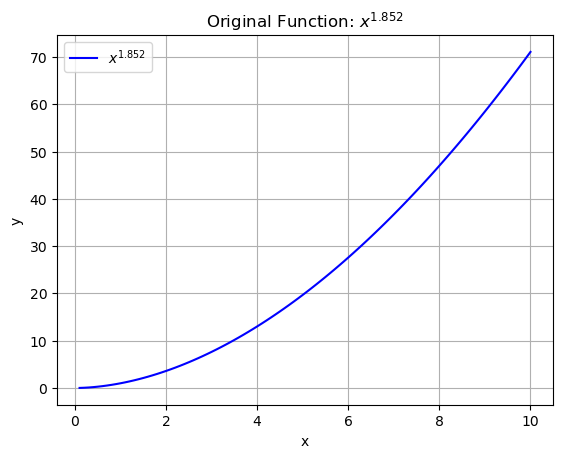

In [620]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
x = np.linspace(0.1, 10, 100)  # Avoid x=0 to prevent issues with fractional exponents
y = x**1.852

# Plot the original function
plt.plot(x, y, label='$x^{1.852}$', color='blue')
plt.title('Original Function: $x^{1.852}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

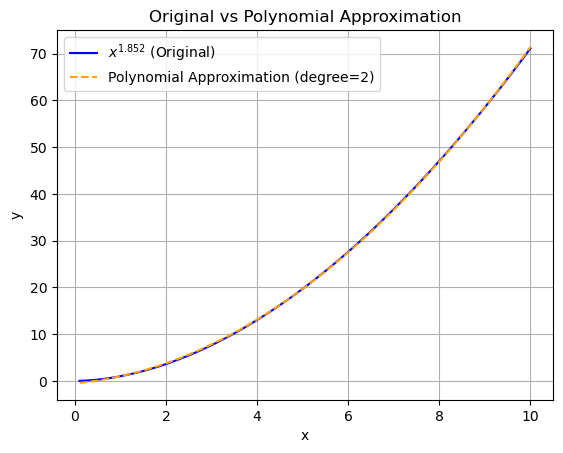

Approximation Equation: y ≈ -0.5324 + 0.8905x + 0.6304x^2


In [621]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit

# Define the function
x = np.linspace(0.1, 10, 100)  # Define x values (avoid x=0 for fractional powers)
y = x**1.852                   # Compute y values for the original function

# Fit a polynomial (degree 2: quadratic)
degree = 2
coeffs = polyfit(x, y, degree)  # Fit the polynomial coefficients

# Generate the polynomial approximation
poly_approx = Polynomial(coeffs)
y_approx = poly_approx(x)

# Plot the original and approximate functions
plt.plot(x, y, label='$x^{1.852}$ (Original)', color='blue')
plt.plot(x, y_approx, label=f'Polynomial Approximation (degree={degree})', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

# Print the polynomial coefficients
print(f"Approximation Equation: y ≈ {coeffs[0]:.4f} + {coeffs[1]:.4f}x + {coeffs[2]:.4f}x^2")

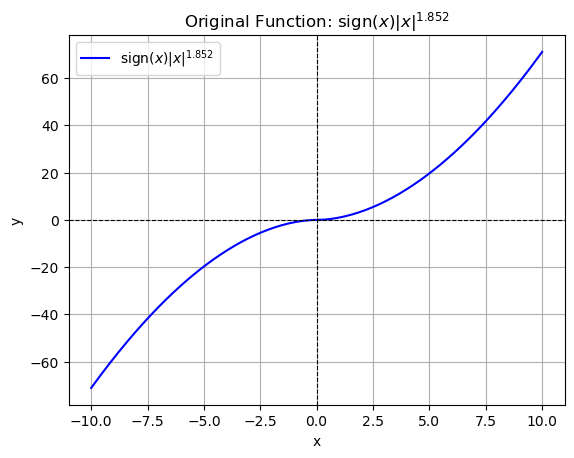

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return np.sign(x) * np.abs(x)**1.852

# Generate data points
x = np.linspace(-10, 10, 200)  # Range includes negative and positive values
y = f(x)

# Plot the original function
plt.plot(x, y, label='$\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.title('Original Function: $\mathrm{sign}(x)|x|^{1.852}$')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

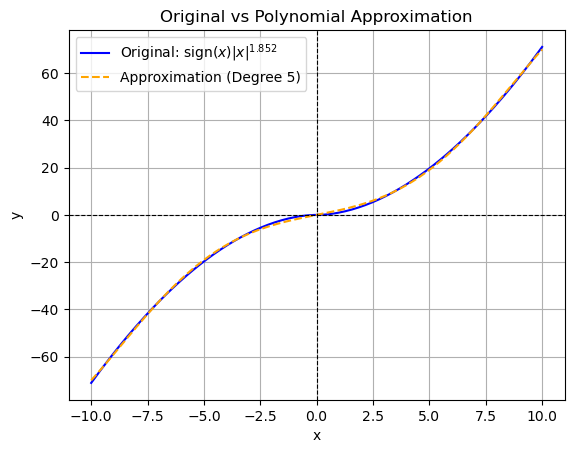

Approximation Equation: y ≈ 1.9138x + 0.0844x^3 + -0.0003x^5


In [623]:
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

# Define the odd polynomial form
def odd_polynomial(x, a1, a3, a5):
    return a1 * x + a3 * x**3 + a5 * x**5

# Generate data points for fitting
x_fit = np.linspace(-10, 10, 200)
y_fit = f(x_fit)

# Fit the odd polynomial (degree 5 in this example)
coeffs, _ = curve_fit(odd_polynomial, x_fit, y_fit, p0=[1, 0, 0])  # Initial guesses

# Generate approximation values
y_approx = odd_polynomial(x_fit, *coeffs)

# Plot the original and approximation
plt.plot(x_fit, y_fit, label='Original: $\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.plot(x_fit, y_approx, label='Approximation (Degree 5)', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Print the polynomial coefficients
print(f"Approximation Equation: y ≈ {coeffs[0]:.4f}x + {coeffs[1]:.4f}x^3 + {coeffs[2]:.4f}x^5")

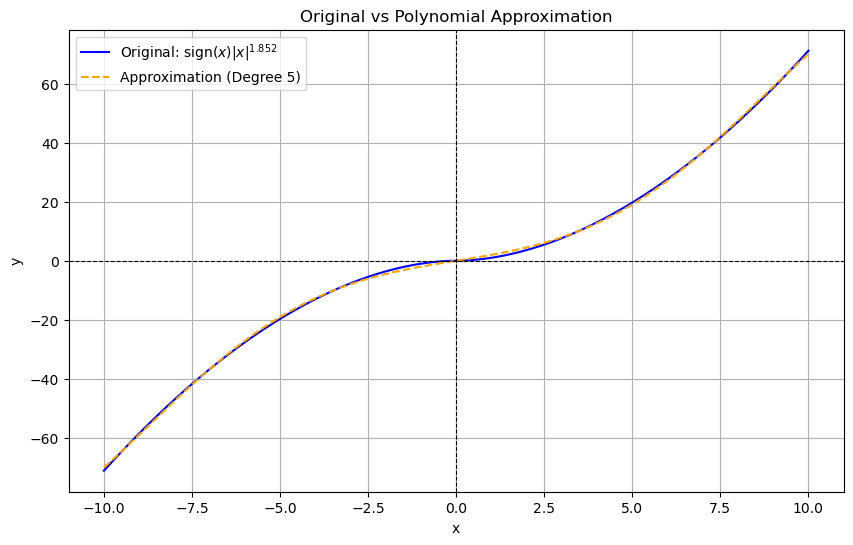

array([ 1.91379410e+00,  8.43990803e-02, -3.35286909e-04])

In [630]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the original function
def f(x):
    return np.sign(x) * np.abs(x)**1.852

# Define the odd polynomial form
def odd_polynomial(x, a1, a3, a5):
    return a1 * x + a3 * x**3 + a5 * x**5

# Generate data points for fitting
x_fit = np.linspace(-10, 10, 200)
y_fit = f(x_fit)

# Fit the odd polynomial (degree 5)
coeffs, _ = curve_fit(odd_polynomial, x_fit, y_fit, p0=[1, 0, 0])  # Initial guesses

# Generate approximation values
y_approx = odd_polynomial(x_fit, *coeffs)

# Plot the original and approximation
plt.figure(figsize=(10, 6))
plt.plot(x_fit, y_fit, label='Original: $\\mathrm{sign}(x)|x|^{1.852}$', color='blue')
plt.plot(x_fit, y_approx, label='Approximation (Degree 5)', linestyle='--', color='orange')
plt.title('Original vs Polynomial Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Output the coefficients of the polynomial
coeffs

In [509]:
import matplotlib.pyplot as plt
import numpy as np

# Data
instances = [
    "d_1", "d_2", "d_3", "d_4", "d_5", 
    "d_6", "d_7", "d_8", "d_9", "d_10", 
    "d_11", "d_12", "d_13", "d_14", "d_15", "d_16"
]
objectives_best_solution = [
    403404.3256, 6058195.193, 12064445.12, 18369653.18, 8818776.684, 
    3553591.035, 3392582.223, 6887885.814, 8.87E+06, 9.48E+06, 
    10952208.55, 3397712.797, 14896324.02, 66399735.69, 171724.3325, 2.03E+04
]
times_best_solution = [
    0.706489, 0.169, 3607.58, 3.18, 3606.21, 46.307574, 3600.79, 3600.73, 
    62.024584, 6.50006, 3.993, 3600.8, 0.033, 1.283074, 1.14, 54.106611
]
objectives_heuristic = [
    403404.3254, 6055935.777, 12064445.01, 18369652.94, 8814597.898, 
    3583561.278, 3392581.16, 6970574.798, 8866820.221, 9401091.06, 
    10703347.71, 3409150.229, 14896324.02, 66444650.62, 171724.4017, 20194.20323
]
times_heuristic = [
    0.8359925747, 1.694795609, 7.378664732, 15.10105038, 5.318006039, 
    92.42892265, 122.3781023, 19.76274657, 608.2187338, 1041.154208, 
    775.5673153, 220.4401248, 0.4528565407, 28.14932442, 45.25914669, 30.79383755
]

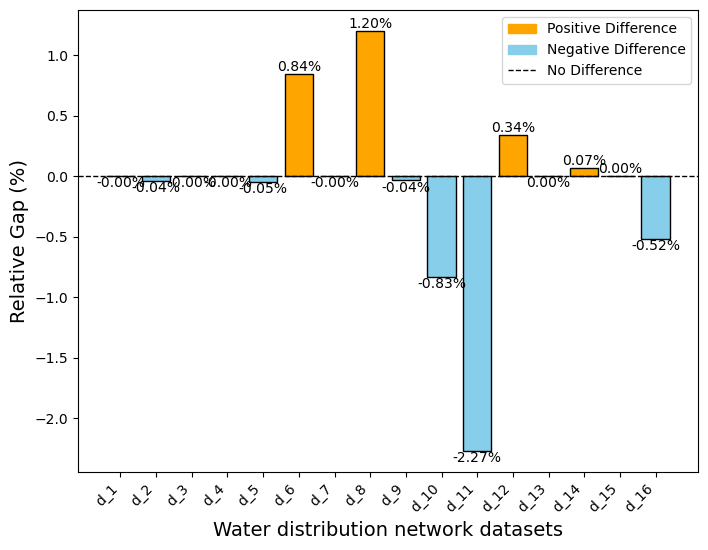

In [525]:
# Calculate relative differences
relative_difference = [
    ((heuristic - best) / best) * 100 
    for heuristic, best in zip(objectives_heuristic, objectives_best_solution)
]

# Plot Relative Differences with Color for Positive and Negative Differences
plt.figure(figsize=(8, 6))

# Color bars based on relative difference sign
colors = ['skyblue' if diff < 0 else 'orange' for diff in relative_difference]
bars = plt.bar(instances, relative_difference, color=colors, edgecolor='black')

# Annotate values on the bars
for bar, diff in zip(bars, relative_difference):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, height, f"{diff:.2f}%", 
        ha='center', va='bottom' if height > 0 else 'top', fontsize=10
    )

plt.axhline(0, color='black', linestyle='--', linewidth=1, label="No Difference")

# Create custom legend handles
positive_patch = mpatches.Patch(color='orange', label="Positive Difference")
negative_patch = mpatches.Patch(color='skyblue', label="Negative Difference")
# Create a dashed line for the "No Difference" legend
no_diff_line = mlines.Line2D([0], [0], color='black', linestyle='--', linewidth=1, label="No Difference")

# Add legends for positive, negative, and no difference
plt.legend(handles=[positive_patch, negative_patch, no_diff_line], loc="upper right")

formula_text = r'$\frac{(Objective_{heuristic} - Objective_{best})}{Objective_{best}} \times 100$'
# plt.ylabel(f"Relative Difference (%)\n{formula_text}", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Water distribution network datasets", fontsize=14)
plt.ylabel("Relative Gap (%)", fontsize=14)
# plt.title("Relative Gap in Objective Values (Heuristic vs. Best Solution)",color='magenta', fontsize=16)
# plt.grid(axis='y')
plt.show()

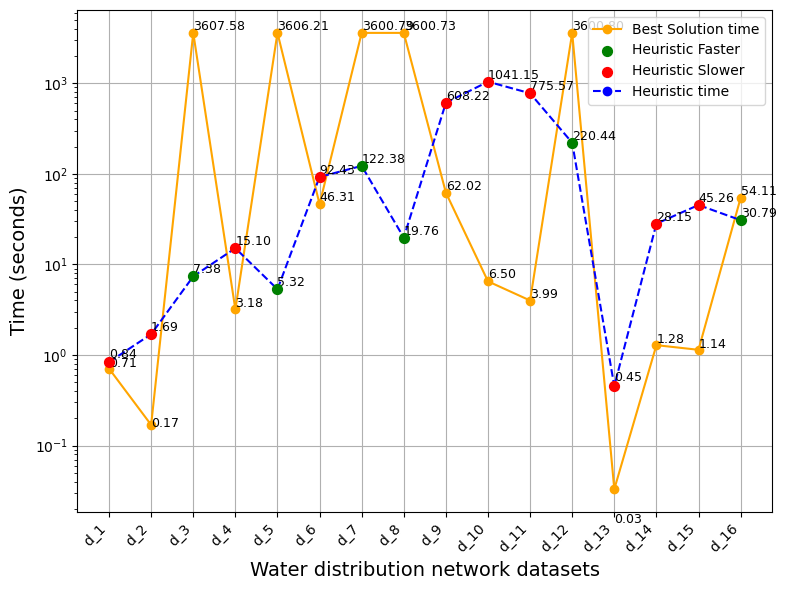

In [524]:
import matplotlib.pyplot as plt
import numpy as np

# Data
instances = [
    "d_1", "d_2", "d_3", "d_4", "d_5", 
    "d_6", "d_7", "d_8", "d_9", "d_10", 
    "d_11", "d_12", "d_13", "d_14", "d_15", "d_16"
]
times_best_solution = [
    0.706489, 0.169, 3607.58, 3.18, 3606.21, 46.307574, 3600.79, 3600.73, 
    62.024584, 6.50006, 3.993, 3600.8, 0.033, 1.283074, 1.14, 54.106611
]
times_heuristic = [
    0.8359925747, 1.694795609, 7.378664732, 15.10105038, 5.318006039, 
    92.42892265, 122.3781023, 19.76274657, 608.2187338, 1041.154208, 
    775.5673153, 220.4401248, 0.4528565407, 28.14932442, 45.25914669, 30.79383755
]

# Plot Times using a log scale for better visibility of variations
plt.figure(figsize=(8, 6))

# Plot the Best Solution points
plt.plot(times_best_solution, label="Best Solution time", marker='o', color='orange')

# Plot the Heuristic points with different colors based on time comparison
faster_idx = [i for i in range(len(times_heuristic)) if times_heuristic[i] < times_best_solution[i]]
slower_idx = [i for i in range(len(times_heuristic)) if times_heuristic[i] >= times_best_solution[i]]

# Plot green points where heuristic is faster
plt.scatter(faster_idx, [times_heuristic[i] for i in faster_idx], color='green', label="Heuristic Faster", zorder=5, s=50)

# Plot red points where heuristic is slower
plt.scatter(slower_idx, [times_heuristic[i] for i in slower_idx], color='red', label="Heuristic Slower", zorder=5, s=50)

# Plot the Heuristic line for completeness
plt.plot(times_heuristic, label="Heuristic time", marker='o', linestyle='--', color='blue')

# Annotate each point with its time value
for i in range(len(times_heuristic)):
    offset_y =  0.02  # Proportional offset
    if times_heuristic[i] < times_best_solution[i]:
        plt.text(i, times_heuristic[i] - offset_y, f"{times_heuristic[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')
    else:
        plt.text(i, times_heuristic[i] + offset_y, f"{times_heuristic[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')

# Annotate Best Solution points
for i in range(len(times_best_solution)):
    offset_y = 0.02  # Proportional offset
    plt.text(i, times_best_solution[i] - offset_y, f"{times_best_solution[i]:.2f}", fontsize=9, color="black", ha='left', va='bottom')

# Set the y-axis to a logarithmic scale
plt.yscale("log")

# Set the x-ticks and labels for the instances
plt.xticks(np.arange(len(instances)), labels=instances, rotation=45, ha="right")

# Add labels and title
plt.xlabel("Water distribution network datasets", fontsize = 14)
plt.ylabel("Time (seconds)", fontsize=14)
# plt.title("Comparison of Time Taken")

# Add the legend
plt.legend()

# Display grid
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***********************

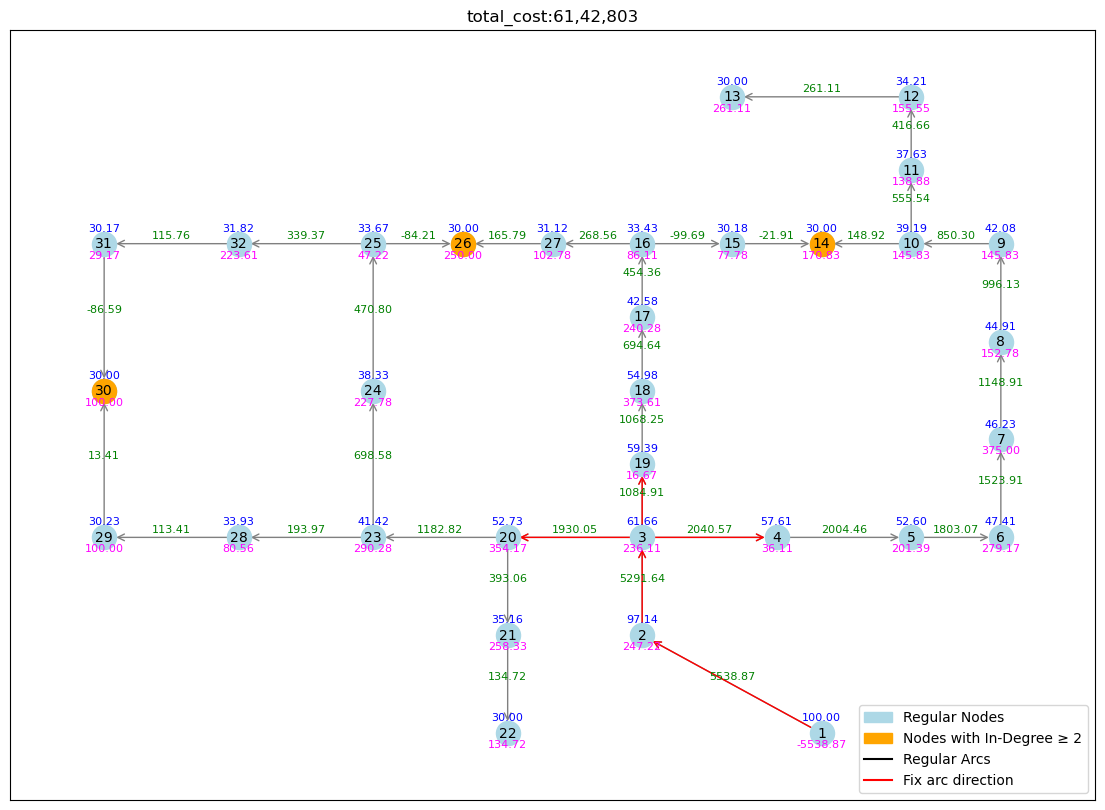

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 26), (25, 32), (27, 26), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 14 in_degree: 2

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_po

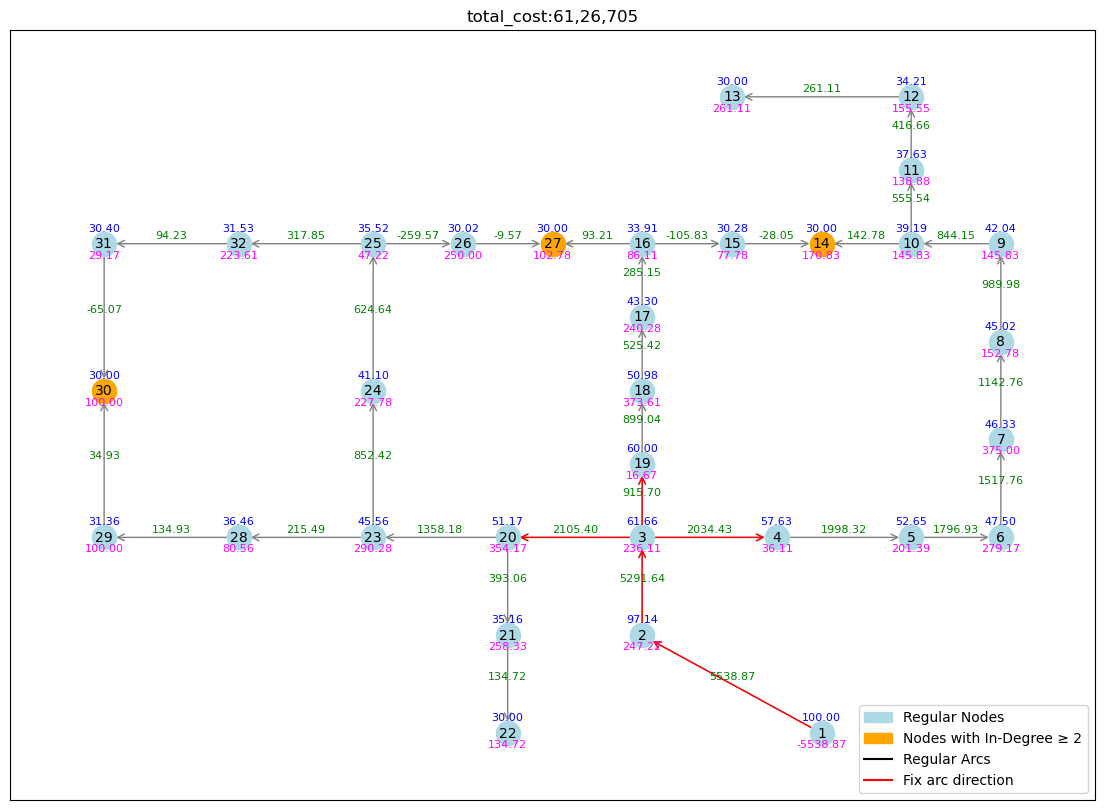

 
Iteration : 2
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (25, 26), (26, 27), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 14 in_degree: 2

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_

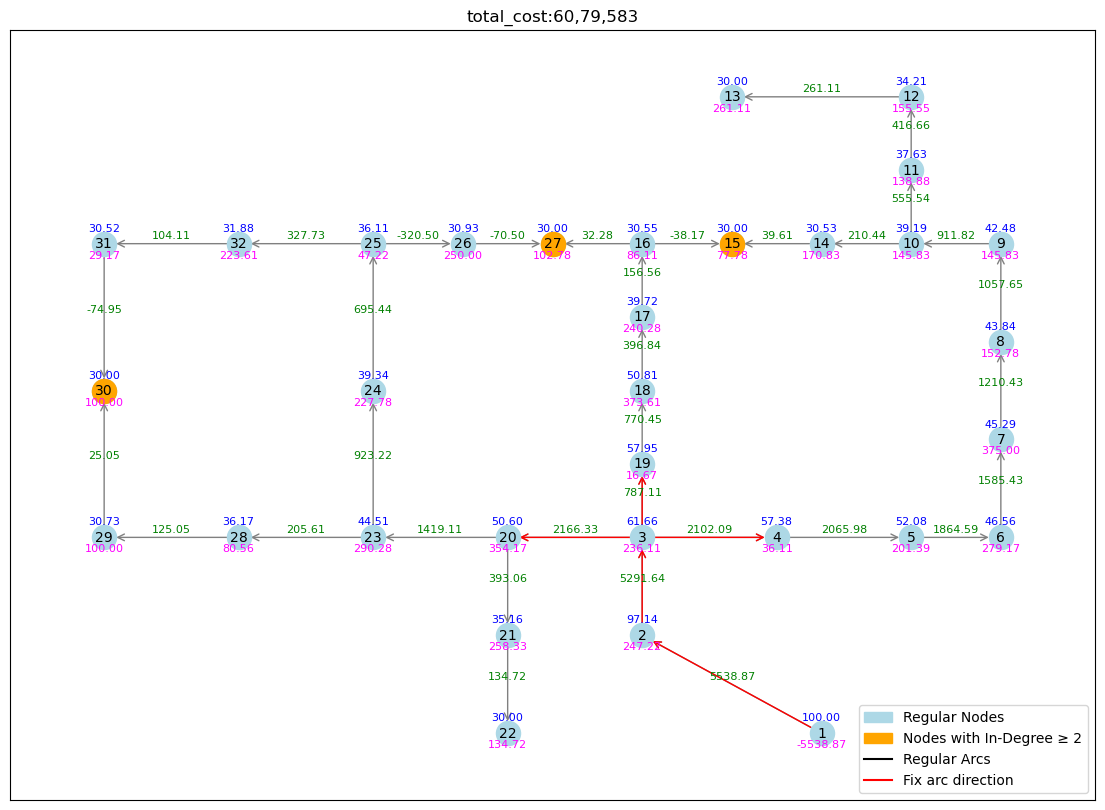

 
Iteration : 3
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (14, 15), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (25, 26), (26, 27), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 15 in_degree: 2

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_

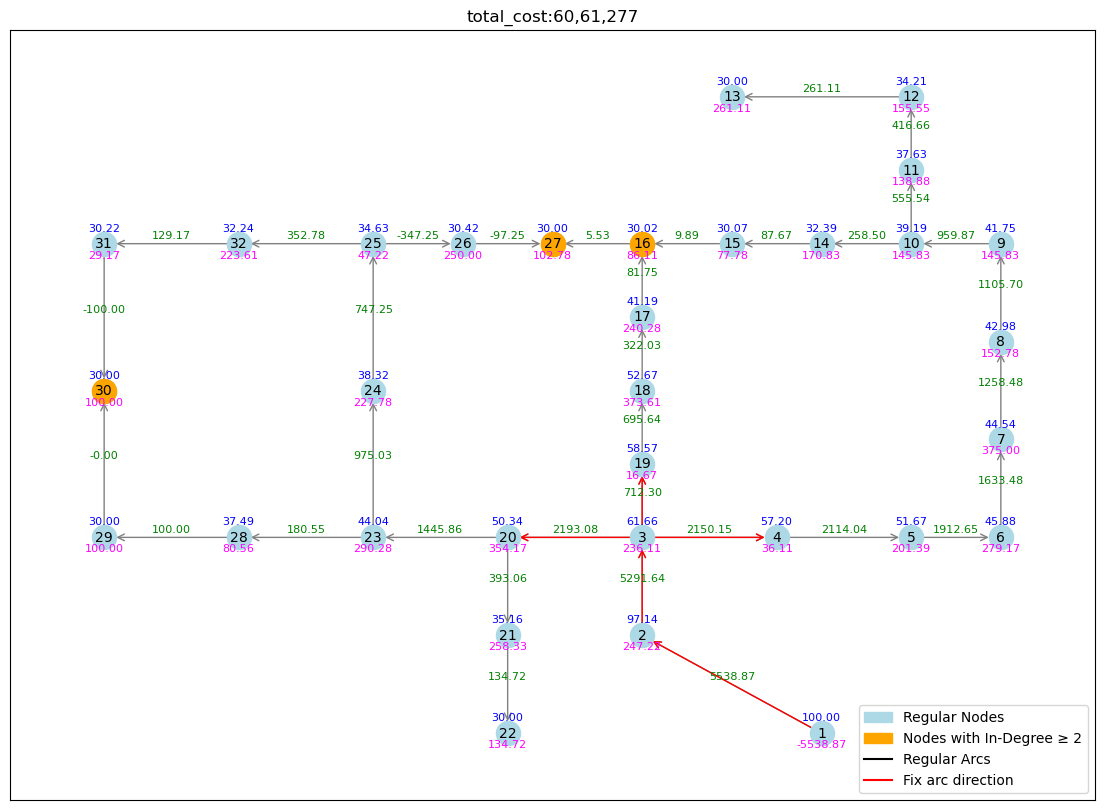

 
Iteration : 4
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (14, 15), (15, 16), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (25, 26), (26, 27), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 16 in_degree: 2

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_

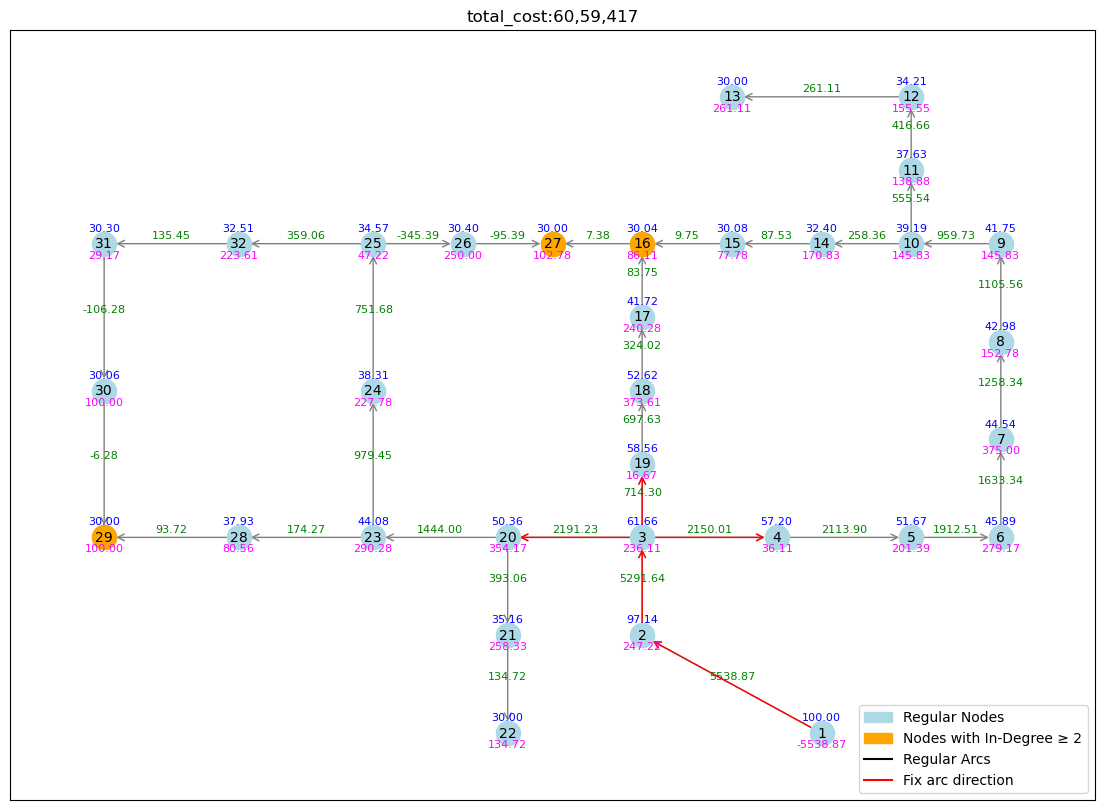

 
Iteration : 5
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (14, 15), (15, 16), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (25, 26), (26, 27), (28, 29), (30, 29), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 16 in_degree: 2

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_

In [1482]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions1
        # pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        print("\nPresolve the model for fixing the flow value in the leaf arcs")
        print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        self.fix_leaf_arc_flow()
                        self.update_initial_points(l, q, h)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                D = self.ampl.getParameter('D').getValues().to_dict()
                                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                                break
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            if improved:
                break
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        #with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.fix_leaf_arc_flow()
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model()
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        #self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()


In [ ]:
## fixed dag model approach

Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.01
bound_frac = 0.01
warm_start_init_point = yes
max_iter = 4000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
*********

The license for this AMPL processor will expire in 1.7 days.


Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.01
bound_frac = 0.01
warm_start_init_point = yes
max_iter = 4000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 
Ipopt 3.14.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  6058195.19273046
solve_result:  solved
Solve_time: 0.16245999999999994

Presolve the model for fixing the arc direction
Is node 1 in cycle? False
Fix the arc (1, 2)
Is node 2 in cycle? False
Fix the arc (2, 3)
Is node 3 in cycle? True
Fix the arc (3, 4)
Fix the arc (3, 19)
Fix the arc (3, 20)
fixed arc direction: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)] 



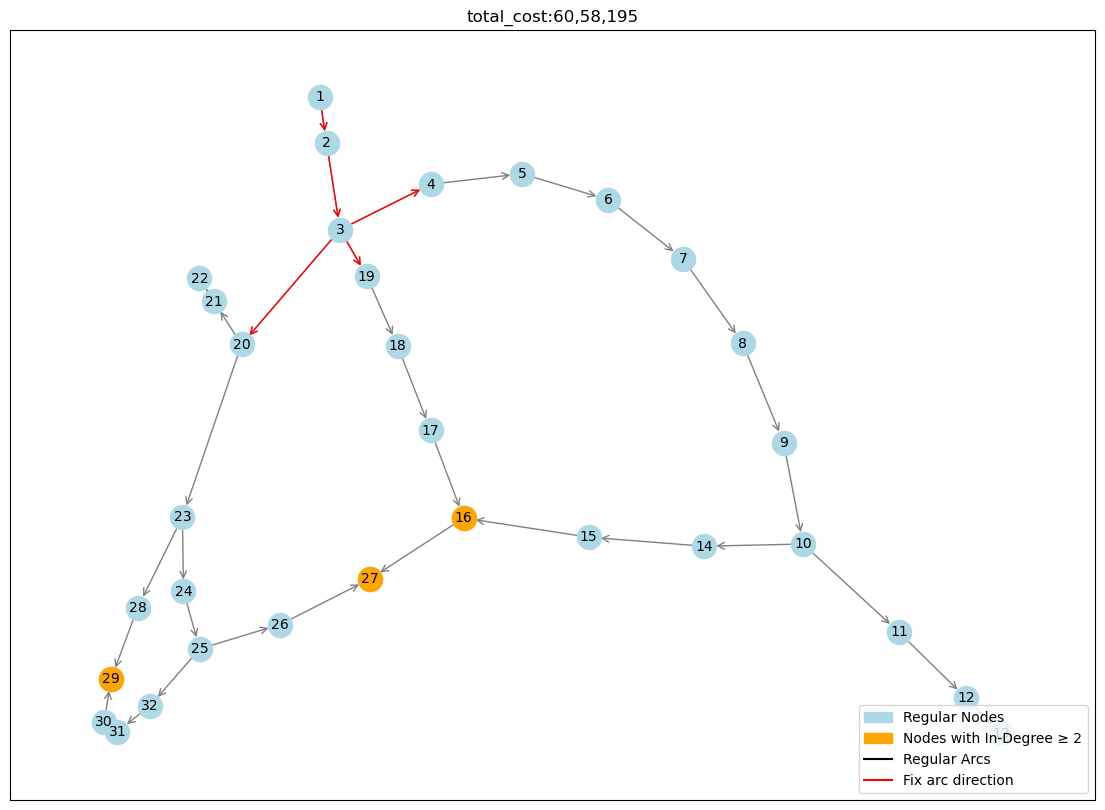

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (14, 15), (15, 16), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 26), (25, 32), (26, 27), (28, 29), (30, 29), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 16 in_degree: 2
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.01
bound_frac = 0.01
warm_start_init_point = yes
max_iter = 4000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 
Ipopt 3.14.13: Optimal 

In [1300]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self, model_file):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        # pos = new_positions1
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        arcs = self.ampl.getSet('arcs').to_list()
        network_arc_direction = self.network_graph.edges
        self.ampl.getSet("Arcs").setValues(network_arc_direction)
        
        L = self.ampl.getParameter('L').getValues().to_dict()
        
        for (i,j), value in L.items():
            if (i,j) in network_arc_direction:
                self.ampl.getParameter('Length').set_values({(i, j): value})
            else:
                self.ampl.getParameter('Length').set_values({(j,i): value})

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three


    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        print("\nPresolve the model for fixing the flow value in the leaf arcs")
        print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n")
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            if (i,j) in self.network_graph.edges:
                self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
            else:
                self.ampl.eval(f'let l[{j},{i},{k}] := {val};')
        for (i, j), val in q_solution.items():
            if (i,j) in self.network_graph.edges:
                self.ampl.eval(f'let q[{i},{j}] := {val};')
            else:
                self.ampl.eval(f'let q[{j},{i}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model("new_m1_basic.mod")
                        self.updated_data_file()
                        # self.fix_leaf_arc_flow()
                        # self.update_initial_points(l, q, h)
                        # self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                D = self.ampl.getParameter('D').getValues().to_dict()
                                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                                break
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            if improved:
                break
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        #with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes max_iter = 4000")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model(self.model_file)
        # self.ampl.read_data(self.data_file)
        self.fix_leaf_arc_flow()
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model("new_m1_basic.mod")
        # self.ampl.read_data(self.data_file)
        self.updated_data_file()
        # self.fix_leaf_arc_flow()
        # self.update_initial_points(l_sol, q_sol, h_sol)
        # self.update_model()
        self.solve()
        # self.ampl.eval("display {(i,j) in Arcs}: q[i,j];")
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

In [ ]:
## spanning tree approach 

Water Network: d10_HG_SP_5_5 

Solve the original nonconvex optimization problem using IPOPT 


The license for this AMPL processor will expire in 1.4 days.


Objective:  9880728.484015066
solve_result:  solved
Solve_time: 2.2764960000000003 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model
Objective:  9878414.199847223
solve_result:  solved
Solve_time: 0.3925559999999999

Presolve the model for fixing the arc direction
Is node 1 in cycle? True
Fix the arc (1, 4)
Fix the arc (1, 7)
Fix the arc (1, 65)
fixed arc direction: [(1, 4), (1, 7), (1, 65)] 



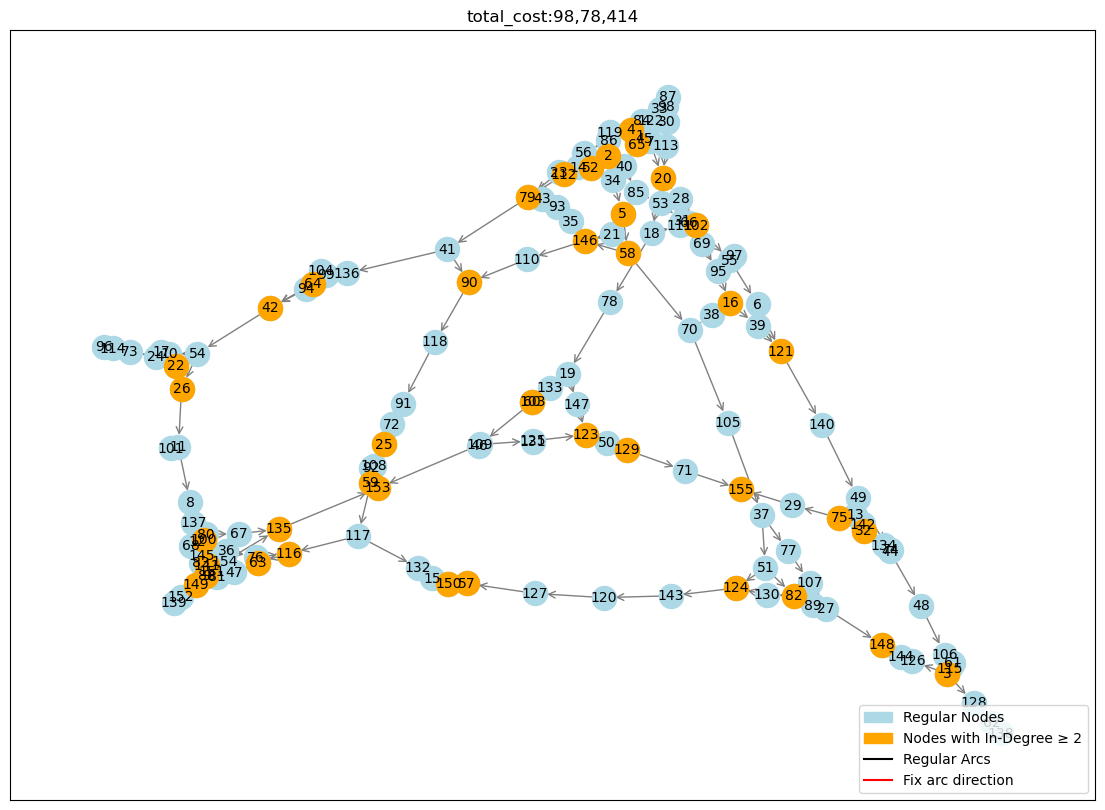

Iteration : 1
Acyclic network arcs direction:  [(1, 4), (1, 7), (1, 65), (2, 52), (3, 126), (3, 128), (4, 86), (5, 21), (5, 58), (6, 121), (7, 45), (7, 122), (7, 20), (8, 80), (8, 137), (9, 149), (10, 17), (10, 24), (11, 8), (11, 101), (12, 100), (12, 68), (13, 75), (13, 142), (14, 112), (15, 150), (16, 39), (18, 111), (18, 78), (19, 133), (19, 147), (19, 103), (20, 28), (20, 18), (21, 58), (21, 146), (22, 26), (23, 112), (23, 79), (24, 22), (24, 73), (25, 108), (25, 59), (26, 11), (27, 89), (27, 82), (27, 148), (28, 102), (29, 155), (30, 113), (31, 69), (32, 75), (33, 98), (34, 52), (34, 5), (35, 146), (36, 76), (37, 51), (37, 77), (38, 16), (39, 121), (40, 2), (40, 34), (40, 85), (41, 136), (41, 90), (42, 54), (43, 93), (44, 134), (44, 48), (45, 65), (47, 81), (48, 106), (49, 13), (49, 44), (50, 129), (51, 82), (51, 124), (52, 14), (52, 112), (53, 31), (54, 10), (54, 22), (54, 26), (55, 6), (55, 97), (56, 23), (57, 150), (58, 70), (58, 146), (59, 117), (62, 138), (63, 47), (64, 42), 

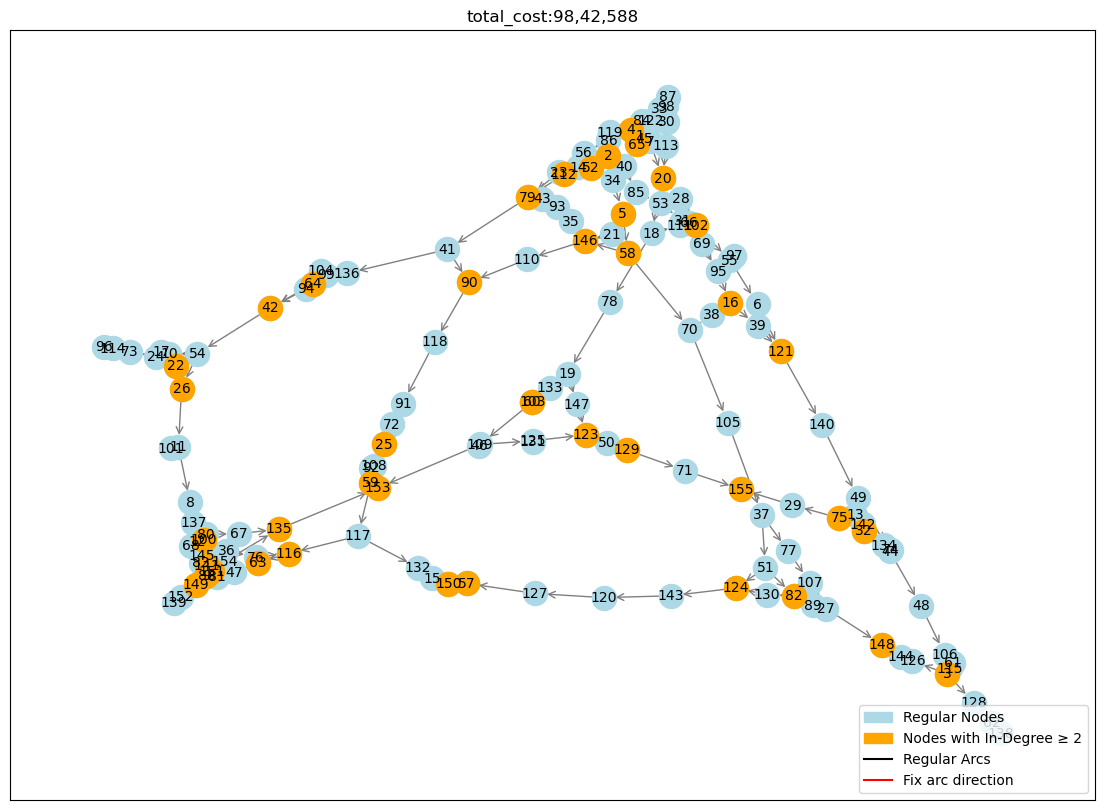

Arc (113, 20) Acyclic: True Best optimal:  9,842,588 New optimal:  10,203,673 Solve_time: 0.94 Solve_result:  solved Improved: No
Arc (54, 22) Acyclic: False
Arc (34, 5) Acyclic: True Best optimal:  9,842,588 New optimal:  9,845,579 Solve_time: 0.49 Solve_result:  solved Improved: No
Arc (50, 129) Acyclic: True Best optimal:  9,842,588 New optimal:  10,513,447 Solve_time: 0.51 Solve_result:  solved Improved: No
Arc (2, 52) Acyclic: True Best optimal:  9,842,588 New optimal:  10,724,919 Solve_time: 1.55 Solve_result:  infeasible
Arc (127, 57) Acyclic: True Best optimal:  9,842,588 New optimal:  9,966,099 Solve_time: 0.57 Solve_result:  solved Improved: No
Arc (132, 57) Acyclic: True Best optimal:  9,842,588 New optimal:  10,015,901 Solve_time: 0.72 Solve_result:  solved Improved: No
Arc (5, 58) Acyclic: False
Arc (25, 59) Acyclic: False
Arc (136, 64) Acyclic: False
Arc (45, 65) Acyclic: True Best optimal:  9,842,588 New optimal:  9,834,732 Solve_time: 0.25 Solve_result:  solved Improved

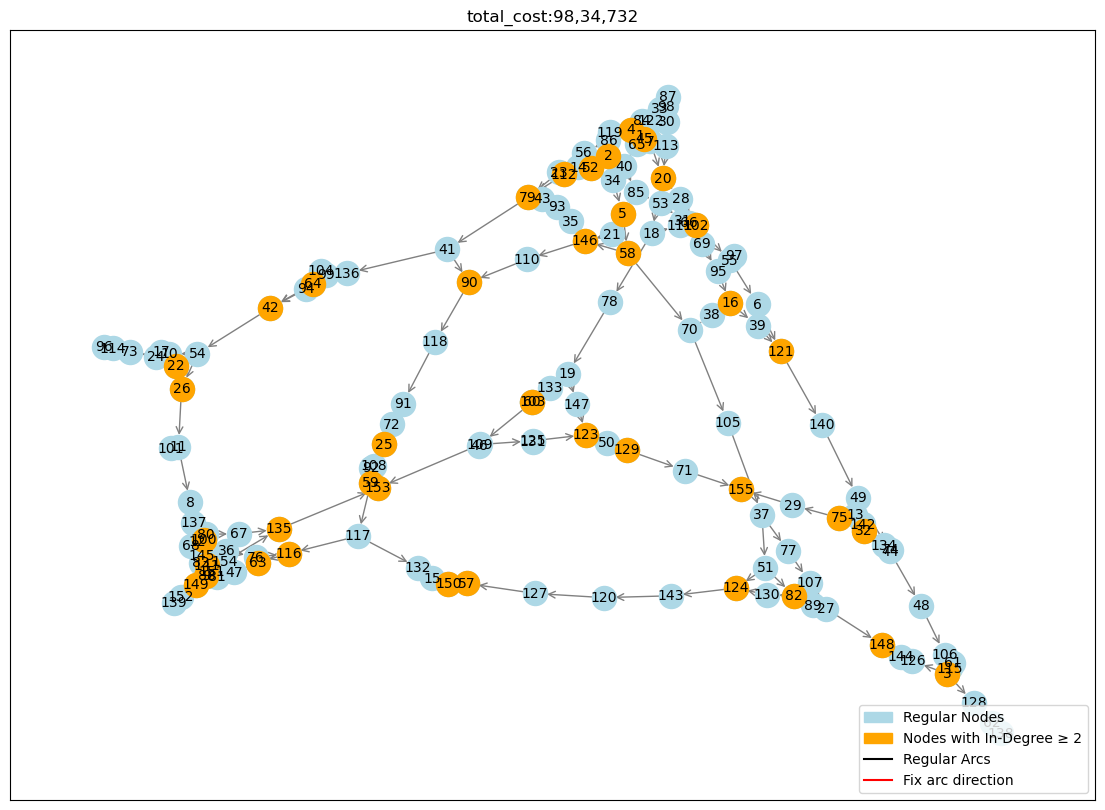

Arc (72, 25) Acyclic: True Best optimal:  9,834,732 New optimal:  12,067,499 Solve_time: 3.62 Solve_result:  infeasible
Arc (13, 75) Acyclic: False
Arc (27, 82) Acyclic: False
Arc (51, 82) Acyclic: True Best optimal:  9,834,732 New optimal:  9,878,143 Solve_time: 0.55 Solve_result:  solved Improved: No
Arc (88, 149) Acyclic: True Best optimal:  9,834,732 New optimal:  10,227,030 Solve_time: 0.43 Solve_result:  infeasible
Arc (41, 90) Acyclic: True Best optimal:  9,834,732 New optimal:  9,963,865 Solve_time: 0.46 Solve_result:  solved Improved: No
Arc (137, 100) Acyclic: True Best optimal:  9,834,732 New optimal:  12,150,218 Solve_time: 1.15 Solve_result:  infeasible
Arc (28, 102) Acyclic: True Best optimal:  9,834,732 New optimal:  11,589,522 Solve_time: 7.25 Solve_result:  limit
Arc (19, 103) Acyclic: False
Arc (133, 103) Acyclic: True Best optimal:  9,834,732 New optimal:  11,432,852 Solve_time: 2.12 Solve_result:  solved Improved: No
Arc (111, 102) Acyclic: False
Arc (52, 112) Acycl

In [1373]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self, model_file):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        # pos = new_positions1
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        print("\nPresolve the model for fixing the flow value in the leaf arcs")
        print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        Nodes = self.ampl.getSet('nodes').to_list()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
         
        variables = []
        for (i, j) in inarc:
            if (i, j) in edges_list:
                variables.append(f"({i},{j})")
            else:
                variables.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        variables_str = ", ".join(variables)
        
        # Define the binary variables for the constructed list in AMPL
        # self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        # self.ampl.eval("var x {inarc_pairs} binary;")
        
        # for edge in self.network_graph.edges:
        #     i, j = edge
        #     if (i,j) not in inarc:
        #         if edge in edges_list:
        #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
        #         else:
        #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
        
        # for (i, j) in inarc:
        #     if (i, j) in edges_list:
        #         self.ampl.eval(f'let x[{i},{j}] := 0;')
        #         self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{i},{j}] <=  (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
        #         self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}]);")
        #         # self.ampl.eval(f"s.t. indicator_approx_{i}_{j}: x[{i},{j}] * (1 - x[{i},{j}]) <= {1};")
        #     else:
        #         self.ampl.eval(f'let x[{j},{i}] := 1;')
        #         self.ampl.eval(f"s.t. flow_bound_right{j}_{i}: q[{j},{i}] <=  (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
        #         self.ampl.eval(f"s.t. flow_bound_left{j}_{i}: q[{j},{i}] >=  -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]);")
        
        self.load_model("../spanningTree/dag_spanning_tree.mod")
        # self.fix_leaf_arc_flow()
        # self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        
        self.ampl.eval(f"s.t. tree_const: sum {{(i,j) in arcs}} x[i,j] = {len(Nodes)-1};")
        undirected_G = self.network_graph.to_undirected()
        cycle_basis = nx.cycle_basis(undirected_G)
        count = 0
        for cycle in cycle_basis:
            # print(cycle)
            self.ampl.eval(f'set cycle{count};')
            self.ampl.set[f'cycle{count}'] = cycle
            # print(tree_ampl.getSet(f'cycle{count}'))  
            count = count +1
        count = 0
        for cycle in cycle_basis:
            # print("s.t. cycle_basis"f{count}": sum{(i,j) in arcs : i,j in "f{cycle}"} x[i,j] <= "f{len(cycle)-1}";")
            print(f"s.t. cycle_basis{count}: sum{{(i,j) in arcs : i in cycle{count} and j in cycle{count}}} x[i,j] <= {len(cycle)-1};") 
            self.ampl.eval(f"s.t. cycle_basis{count}: sum{{(i,j) in arcs : i in cycle{count} and j in cycle{count}}} x[i,j] <= {len(cycle)-1};" )  
            count = count +1 
        
        # for node in indegree_2_or_more:
        #     self.ampl.eval(f"s.t. inarc_con{node}: sum{{i in nodes: (i,{node}) in arcs}} x[i, {node}] + sum{{j in nodes: ({node}, j) in arcs}} x[{node}, j] = 1;")
        for (i,j) in  edges_list:
            if (i,j) not in inarc:
                self.ampl.eval(f"s.t. binary_x{i}_{j}: x[{i},{j}] = 1;")
                
        self.solve()
        print("Objective value:", self.total_cost)
        print("solve_result:",self.solve_result)
        self.ampl.eval(f"show;")
        self.ampl.eval("display x;")

        x = self.ampl.getVariable('x').get_values().to_dict()
        # l = self.ampl.getVariable('l').getValues().to_dict()
        # q = self.ampl.getVariable('q').getValues().to_dict()
        # h = self.ampl.getVariable('h').getValues().to_dict()  
        # D = self.ampl.getParameter('D').getValues().to_dict()
        # self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)

        # self.load_model(self.model_file)
        # self.fix_leaf_arc_flow()
        # self.update_initial_points(l, q, h)
        # for (i,j), value in x.items():
        #     if value >= 0.5:
        #         if (i,j) in self.network_graph.edges:
        #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
        #         else:
        #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] <=0;")
        #     else:
        #         self.ampl.eval(f"s.t. flow_direction{i}_{j}: -sum{{k in nodes diff Source}} D[k] <= q[{i},{j}] <= sum{{k in nodes diff Source}} D[k];")

        # self.solve()
        # print("cost:", self.total_cost)   
        # self.display_results()
        # l = self.ampl.getVariable('l').getValues().to_dict()
        # q = self.ampl.getVariable('q').getValues().to_dict()
        # h = self.ampl.getVariable('h').getValues().to_dict()
        # D = self.ampl.getParameter('D').getValues().to_dict()
        # self.plot_graph(super_source_out_arc,  self.total_cost , iteration, q, h, D)
        # if self.solve_result == "solved":
        #     if self.total_cost < current_cost:
        #         print("Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
        #         current_cost = self.total_cost
        #         improved = True
        #         best_acyclic_flow = self.network_graph.copy()
        #         best_arc = (v,u)
        #         l = self.ampl.getVariable('l').getValues().to_dict()
        #         q = self.ampl.getVariable('q').getValues().to_dict()
        #         h = self.ampl.getVariable('h').getValues().to_dict()
        #         D = self.ampl.getParameter('D').getValues().to_dict()
        #         self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)

        for (u,v), value in x.items():
            if value < 0.5:
                if (u,v) not in self.network_graph.edges:
                    (u,v) = (v,u)
                if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model(self.model_file)
                        # self.fix_leaf_arc_flow()
                        self.update_initial_points(l, q, h)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                D = self.ampl.getParameter('D').getValues().to_dict()
                                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                                # break
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            # print(" ")
            # if improved:
            #     break
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model(self.model_file)
        # self.fix_leaf_arc_flow()
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model(self.model_file)
        # self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        #self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 9
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

In [1375]:
## Linearize the nonlinear constraint and use this to find the best arc reversal 

Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 

Presolve the model for fixing the flow value in the leaf arcs
Source: [1]
leaf_nodes: [1, 13, 22]
Fixing flow for arc (1, 2): 5538.8658000000005
Fixing flow for arc (12, 13): 261.11
Fixing flow for arc (21, 22): 134.7222
leaf_nodes: [2, 12, 21]
Fixing flow for arc (2, 3): 5291.643800000001
Fixing flow for arc (11, 12): 416.66
Fixing flow for arc (20, 21): 393.0552
leaf_nodes: [11]
Fixing flow for arc (10, 11): 555.54
leaf_nodes: []
Ipopt 3.14.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
***********************

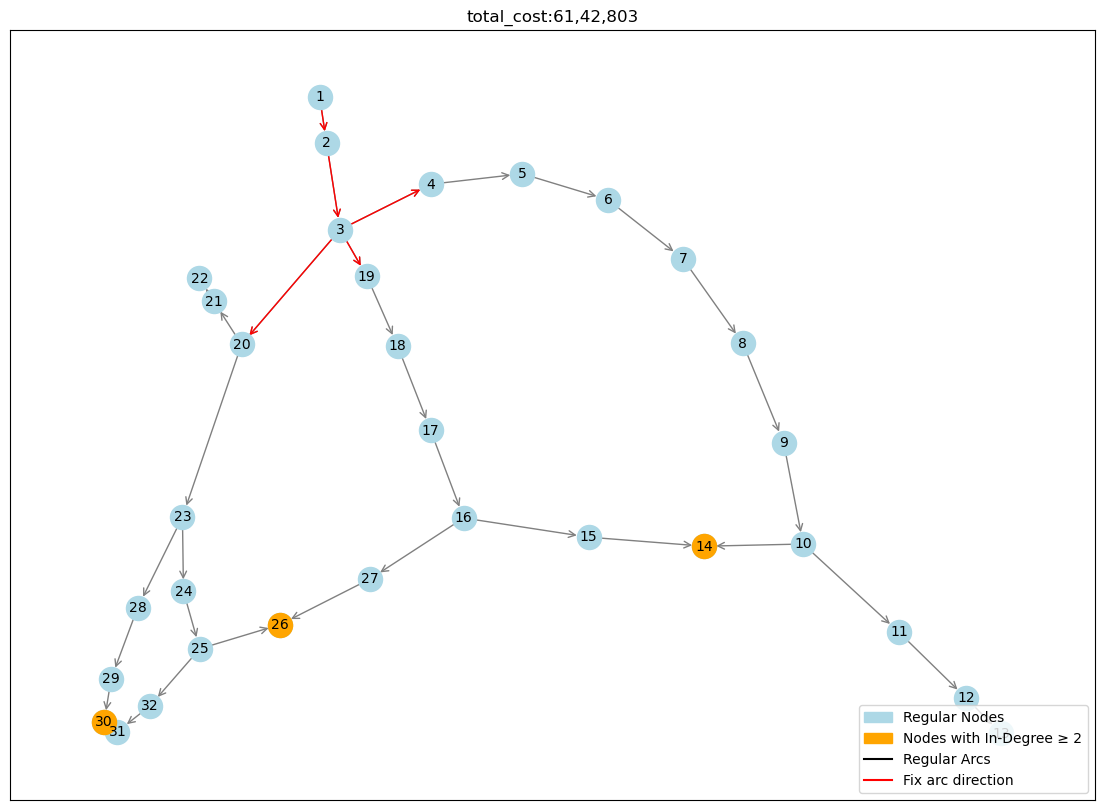

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 26), (25, 32), (27, 26), (28, 29), (29, 30), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
{(1, 2): -11.296857663788714, (2, 3): -159.63263590004658, (3, 4): -275.9743968772117, (3, 19): -936.4725969522619, (3, 20): -713.2365013844449, (4, 5): -358.98675970500983, (5, 6): -503.1909927642105, (6, 7): -184.77036614648642, (7, 8): -462.9267123043288, (8, 9): -1491.2485801400917, (9, 10): -2389.734078209465, (10, 11): -4343.486120337363, (10, 14): -1094034.5276761034, (11, 12): -21686.09557772586, (12, 13): -100931.44028672064, (14, 15): 5025077.501779413, (15, 16): 1214859.17350444, (16, 27): -51098.815002037656, (17, 16): -45242.33742829237, (18, 17): -18262

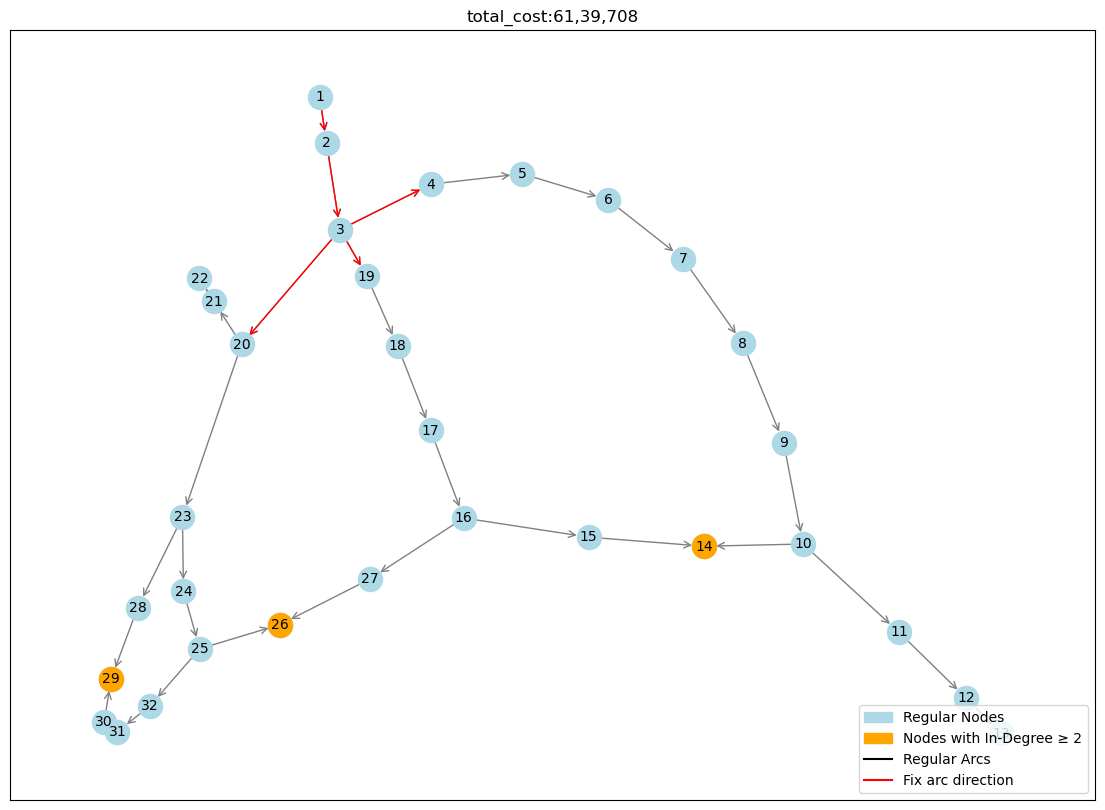

 
Iteration : 2
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (25, 26), (27, 26), (28, 29), (30, 29), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
{(1, 2): -11.296857663788662, (2, 3): -159.6326359000466, (3, 4): -276.80338198376506, (3, 19): -946.6483298918447, (3, 20): -706.728459621984, (4, 5): -360.0845873824134, (5, 6): -504.9022733928466, (6, 7): -185.51432051895935, (7, 8): -465.4022574695605, (8, 9): -1594.4427156849074, (9, 10): -2407.0338025370775, (10, 11): -4343.486120337319, (10, 14): -1232907.92683884, (11, 12): -21686.095577725362, (12, 13): -100931.44028672013, (14, 15): 3929112.304904295, (15, 16): 1144684.7724991275, (16, 27): -80791.05549018637, (17, 16): -46434.155931255875, (18, 17): -192

In [1498]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self, model_file):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        # pos = new_positions1
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        print("\nPresolve the model for fixing the flow value in the leaf arcs")
        print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
            
    def derivative_calculation(self, l, q, h):
        d = self.ampl.getParameter('d').getValues().to_dict()
        R = self.ampl.getParameter('R').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        function = {}
        for (i,j) in q.keys():
            function[i,j] = h[i] - h[j] - (q[i,j] * abs(q[i,j])**0.852) * (0.001**1.852) * sum(10.67 * l[i, j, k] / ((R[k]**1.852) * (d[k] / 1000)**4.87) for k in d.keys())
        # print(function)
        del_l = {}
        for (i,j) in q.keys():
            for k in d.keys():
                del_l[i,j,k] = - (q[i,j] * abs(q[i,j])**0.852) * (0.001**1.852) * 10.67/((R[k]**1.852) * (d[k] / 1000)**4.87)

        del_q = {}
        for (i,j) in q.keys():
            del_q[i,j] = - (1.852 * abs(q[i,j])**0.852) * (0.001**1.852) * sum(10.67 * l[i, j, k] / ((R[k]**1.852) * (d[k] / 1000)**4.87) for k in d.keys())
            
        del_z_del_q = {}
        for (i,j) in q.keys():
            del_z_del_q[i,j] = - sum(C[k] * ((1.852*(R[k]**1.852) * (d[k]/1000)**4.87)/q[i,j]) * (sum(l[i,j,m]/((R[m]**1.852) * (d[m]/1000)**4.87) for m in d.keys())) for k in C.keys())

        return function, del_l, del_q, del_z_del_q
    
    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        if best_arc:
            (u,v) = best_arc
            BEST_ARC.append((u,v))
        # l = self.ampl.getVariable('l').getValues().to_dict()
        # q = self.ampl.getVariable('q').getValues().to_dict()
        # h = self.ampl.getVariable('h').getValues().to_dict()
        d = self.ampl.getParameter('d').getValues().to_dict()
        R = self.ampl.getParameter('R').getValues().to_dict()
        
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        function, del_l, del_q, del_z_del_q = self.derivative_calculation(l,q,h)
        
        print(del_z_del_q)
        
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
        print("BEST_ARC:", BEST_ARC)
        
        # q_sensitivity = {}
        # for (i, j) in inarc:
        #     if (i,j) not in set(BEST_ARC):
        #         if (i, j) in self.network_graph.edges():
        #             q_sensitivity[i,j] = del_z_del_q[i,j]
        #         else:
        #             q_sensitivity[j,i] = del_z_del_q[i,j]
        # print(q_sensitivity)
        
        del_l_sums = {}  # Dictionary to store del_l_sum for each arc (i, j)3
        for (i, j) in q.keys():
            del_l_sum = " + ".join(f"{del_l[i, j, k]} * (l[{i},{j},{k}] - {l[i, j, k]})" for k in d.keys())
            del_l_sums[(i, j)] = del_l_sum
            
        cost = {}
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc and (u,v) not in [best_arc]:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model("../lpNlp/new_lp.mod")
                        self.fix_leaf_arc_flow()
                        # self.update_initial_points(l, q, h)
                        
                        for (i,j) in q.keys():
                            self.ampl.eval(f"s.t. linearize_{i}_{j}:{function[i, j]}  + {del_l_sums[i,j]} + {del_q[i, j]} * (q[{i},{j}] - {q[i, j]}) + (h[{i}] - {h[i]}) - (h[{j}] - {h[j]}) = 0;")

                        self.update_model()
                        self.ampl.option["solver"] = "cplexamp"
                        self.ampl.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        # for (i,j) in q.keys():
                        #     self.ampl.eval(f"expand linearize_{i}_{j};")
                        self.solve_result = self.ampl.solve_result
                        self.total_cost = self.ampl.get_objective("total_cost").value()
                        # print("Objective:", self.total_cost)
                        # print("solve_result: ",self.solve_result)
                        
                        if self.solve_result == "solved":
                            print("Arc", (u,v))
                            curr_cost = self.total_cost
                            cost[u,v] = curr_cost
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)
                        else:
                            print("Arc", (u,v))
                            # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            
            # if improved:
            #     break
        print(cost)
        best_arc = min(cost, key=cost.get)
        # best_arc = max((q_sensitivity), key=q_sensitivity.get)
        # best_arc = max(q_sensitivity, key=lambda arc: abs(q_sensitivity[arc]))
        print(best_arc)
        (u,v) = best_arc
        BEST_ARC.append(best_arc)
        print("BEST_ARC:", BEST_ARC)
        self.network_graph.remove_edge(u,v)
        self.network_graph.add_edge(v,u)
        acy_check = nx.is_directed_acyclic_graph(self.network_graph)
        in_arc_check = self.check_incoming_arcs()
        self.load_model(self.model_file)
        self.fix_leaf_arc_flow()
        self.update_initial_points(l, q, h)
        self.update_model()
        self.solve()
        if self.solve_result == "solved":
            # if True:
            if self.total_cost < current_cost:
                print("Arc", (u,v),"Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                current_cost = self.total_cost
                improved = True
                best_acyclic_flow = self.network_graph.copy()
                # best_arc = (v,u)
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                D = self.ampl.getParameter('D').getValues().to_dict()
                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                self.network_graph.remove_edge(v, u)
                self.network_graph.add_edge(u, v)  
            else:
                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result, "Improved: No")
                self.network_graph.remove_edge(v, u)
                self.network_graph.add_edge(u, v)  
        else:
            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", round(self.ampl.get_value('_solve_elapsed_time'),2), "Solve_result: ", self.solve_result)
            self.network_graph.remove_edge(v, u)
            self.network_graph.add_edge(u, v) 
        print(" ")
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        #with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model(self.model_file)
        self.fix_leaf_arc_flow()
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()
                                       
        self.load_model(self.model_file)
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        #self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

In [1474]:
import numpy as np

# Define the functions
def F(x):
    return np.array([x[0]**2 + x[1]**2 - 4, x[0]*x[1] - 1])

# Define the Jacobian matrix
def J(x):
    return np.array([[2*x[0], 2*x[1]], [x[1], x[0]]])

# Newton's method
def newton_method(F, J, x0, tol=1e-6, max_iter=100):
    x = x0
    for i in range(max_iter):
        Fx = F(x)
        Jx = J(x)
        delta_x = np.linalg.solve(Jx, -Fx)  # Solve J(x) * delta_x = -F(x)
        x = x + delta_x
        if np.linalg.norm(Fx, ord=2) < tol:  # Check convergence
            print(f"Converged in {i+1} iterations.")
            return x
    raise Exception("Newton's method did not converge")

# Initial guess
x0 = np.array([2.0, 1.0])  # Initial guess for [x, y]

# Solve
solution = newton_method(F, J, x0)
print("Solution:", solution)


Converged in 5 iterations.
Solution: [1.93185165 0.51763809]


In [1477]:
import numpy as np

# Define the nonlinear system
def F(x):
    return np.array([np.sin(x[0]) + x[1]**2 - 2, x[0]**2 + np.cos(x[1]) - 1])

# Compute the Jacobian matrix numerically using finite differences
def numerical_jacobian(F, x, epsilon=1e-8):
    n = len(x)
    J = np.zeros((n, n))  # Initialize the Jacobian matrix
    for j in range(n):
        e = np.zeros(n)
        e[j] = epsilon
        J[:, j] = (F(x + e) - F(x)) / epsilon  # Finite difference formula
    return J

# Newton's method
def newton_method(F, J_approx, x0, tol=1e-6, max_iter=100):
    x = x0
    for i in range(max_iter):
        Fx = F(x)  # Evaluate the system of equations
        Jx = J_approx(F, x)  # Compute the Jacobian numerically
        delta_x = np.linalg.solve(Jx, -Fx)  # Solve J(x) * delta_x = -F(x)
        x = x + delta_x  # Update the solution
        if np.linalg.norm(Fx, ord=2) < tol:  # Convergence check
            print(f"Converged in {i+1} iterations.")
            return x
    raise Exception("Newton's method did not converge")

# Initial guess
x0 = np.array([1.0, 1.0])  # Initial guess for [x, y]

# Solve
solution = newton_method(F, numerical_jacobian, x0)
print("Solution:", solution)


Converged in 4 iterations.
Solution: [0.7651716  1.14338936]


Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  6217280.76683498
solve_result:  solved
Solve_time: 0.7849079999999999 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
boun

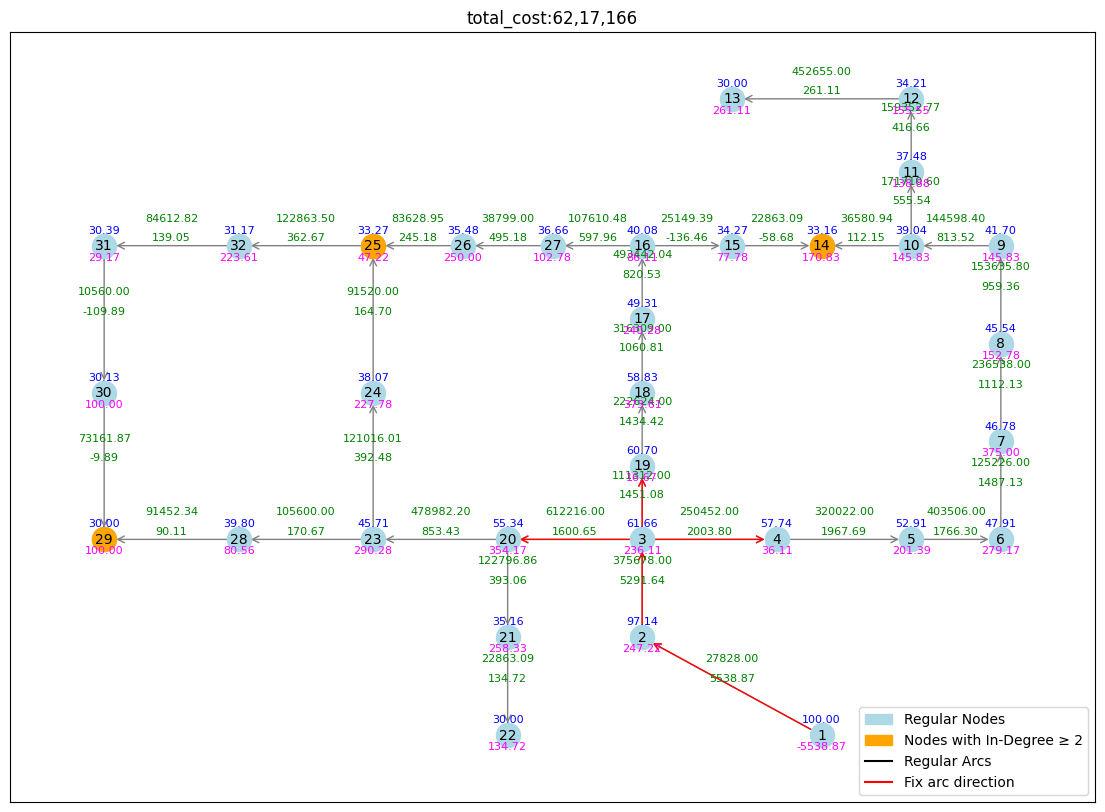

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 14), (11, 12), (12, 13), (15, 14), (16, 15), (16, 27), (17, 16), (18, 17), (19, 18), (20, 21), (20, 23), (21, 22), (23, 24), (23, 28), (24, 25), (25, 32), (26, 25), (27, 26), (28, 29), (30, 29), (31, 30), (32, 31)]
Fixed arc set: [(1, 2), (2, 3), (3, 4), (3, 19), (3, 20)]
Node: 14 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal 

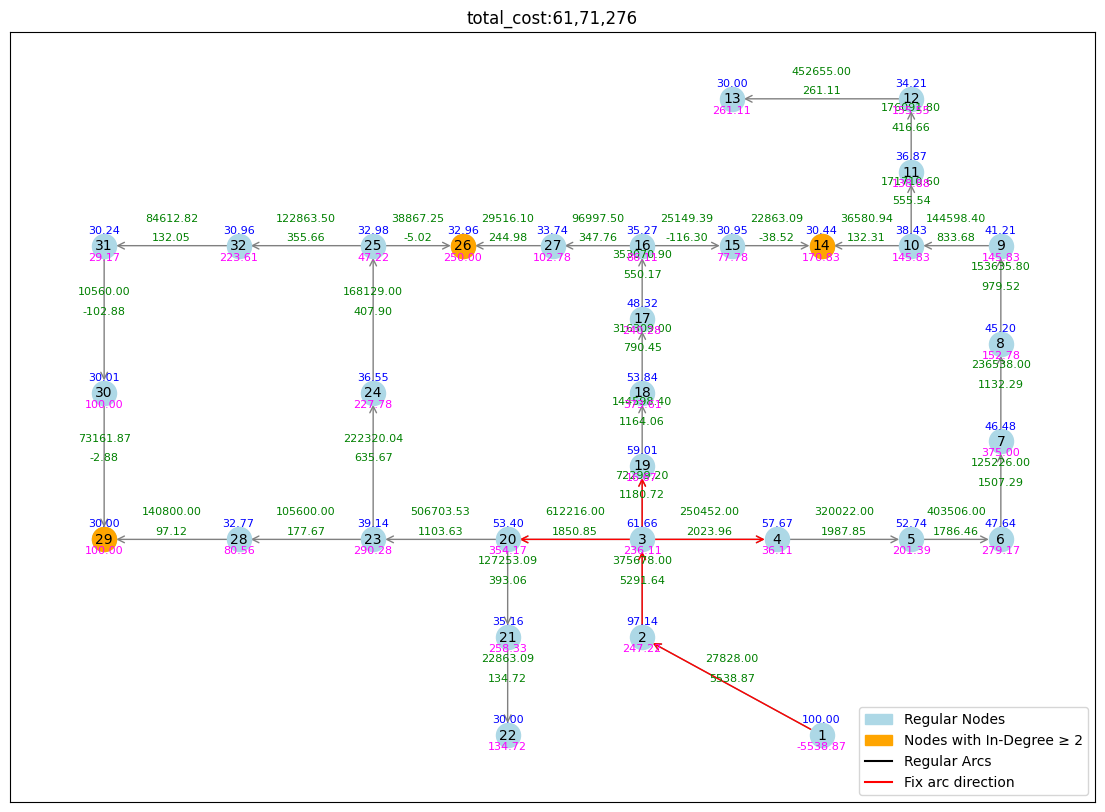

 
Node: 29 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Arc (28, 29) Acyclic: True Best optimal:  6,171,276 New optimal:  6,372,989 Solve_time: 0.15089400000000008 Solve_result:  solved Improved: No
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


*****************************************************************************

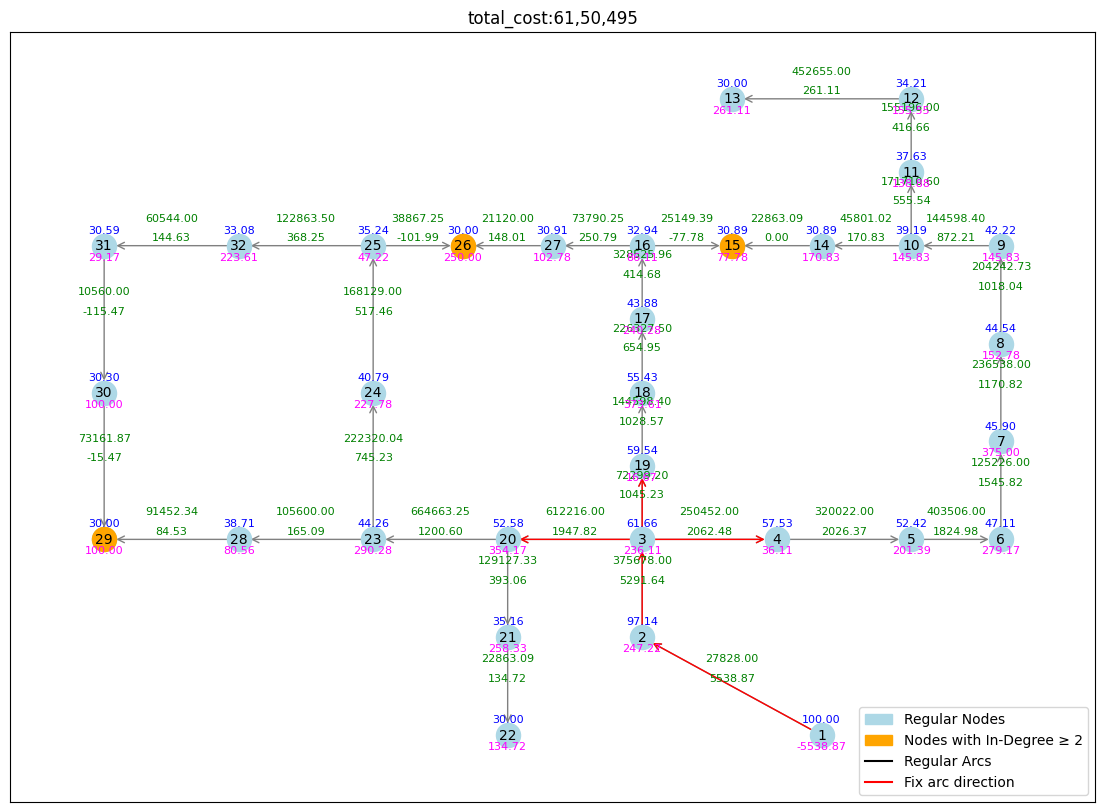

 
Node: 26 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Arc (25, 26) Acyclic: True Best optimal:  6,150,495 New optimal:  6,171,990 Solve_time: 0.11902100000000004 Solve_result:  solved Improved: No
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


*****************************************************************************

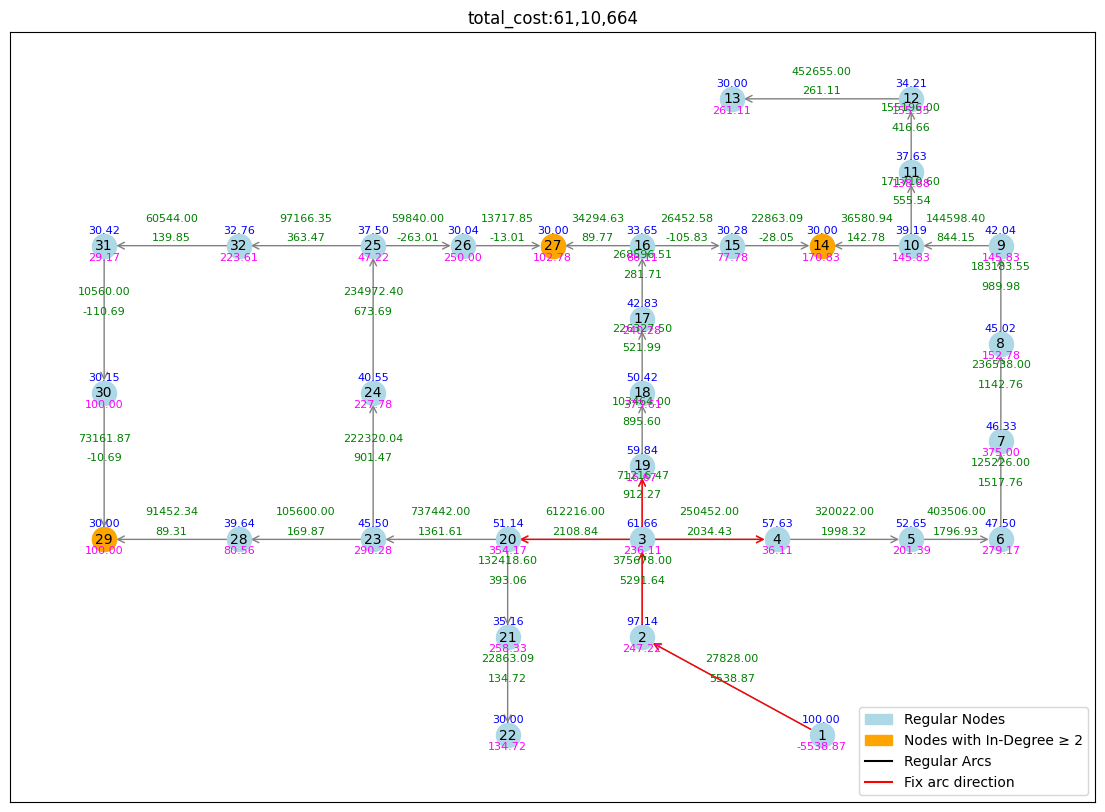

 
Node: 29 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Arc (28, 29) Acyclic: True Best optimal:  6,110,664 New optimal:  6,378,938 Solve_time: 0.2690600000000005 Solve_result:  solved Improved: No
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************

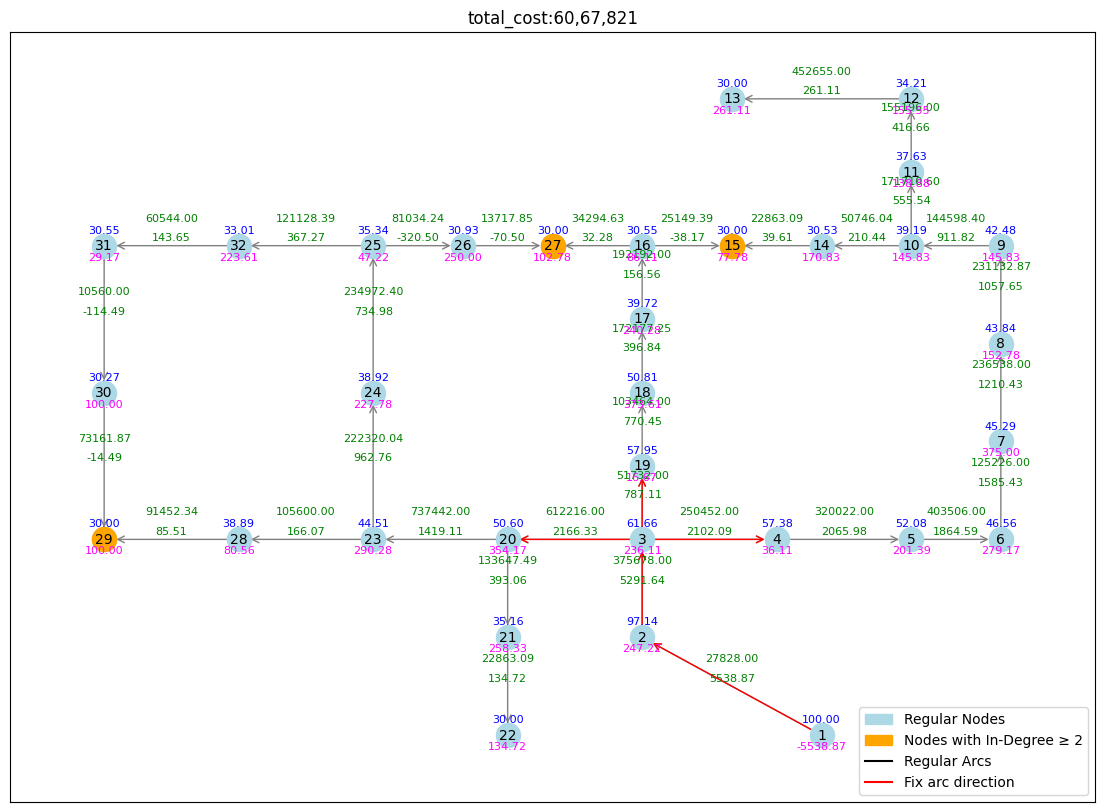

 
Node: 27 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Arc (16, 27) Acyclic: True Best optimal:  6,067,821 New optimal:  6,100,514 Solve_time: 0.09220600000000001 Solve_result:  solved Improved: No
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


*****************************************************************************

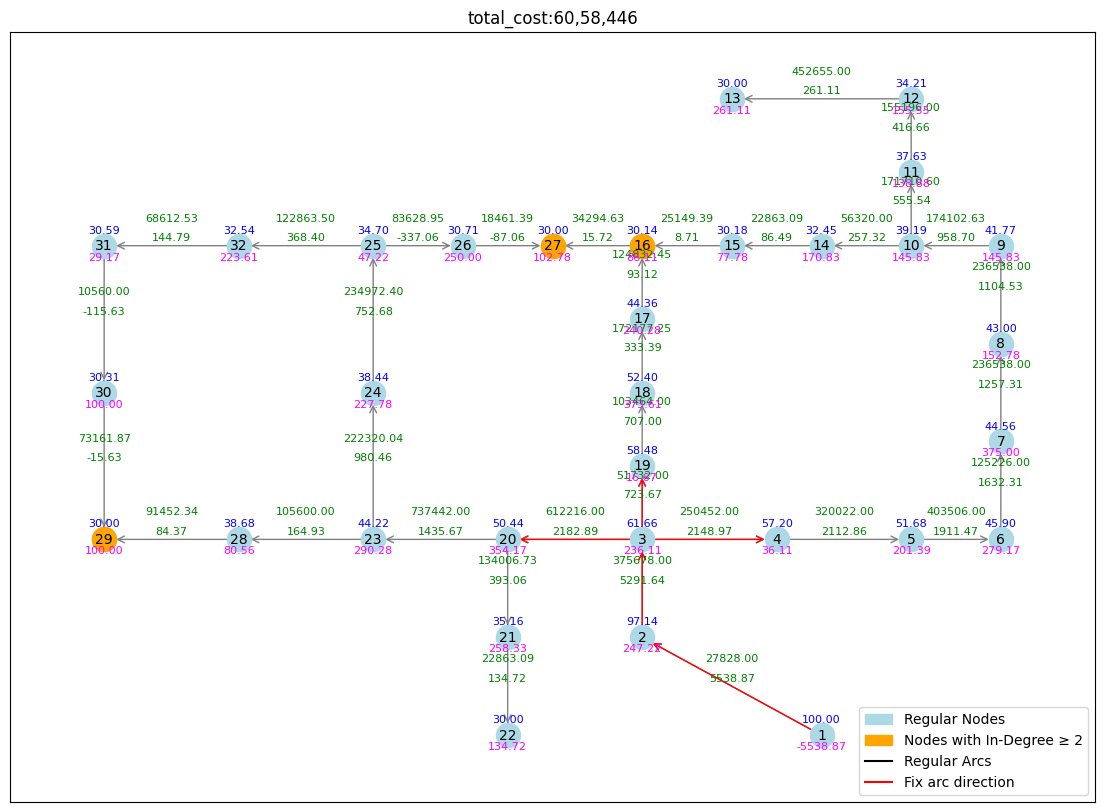

 
Node: 27 in_degree: 2
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Arc (16, 27) Acyclic: True Best optimal:  6,058,446 New optimal:  6,062,547 Solve_time: 0.07390299999999961 Solve_result:  solved Improved: No
Acyclic True
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


*****************************************************************************

In [95]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions1
        # pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')
        
        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+500 , f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        (u,v) = arc
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}_{u}_{v}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                        self.fix_leaf_arc_flow()
                        self.update_initial_points(l, q, h)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        #self.display_results()
                        l = self.ampl.getVariable('l').getValues().to_dict()
                        q = self.ampl.getVariable('q').getValues().to_dict()
                        h = self.ampl.getVariable('h').getValues().to_dict()
                        # self.plot_graph(super_source_out_arc, self.total_cost, iteration, q, h, D, (v,u))
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                
                                self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D, (u,v), l, C)
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                                # break
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            # if improved:
            #     break
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D, (0,0), l, C)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        #with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time

    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        #self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        
        # print("cost:", self.total_cost)  
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]
    
    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

In [8]:
import numpy as np
from amplpy import AMPL

class SQPSolver:
    def __init__(self, model_file, data_file):
        # Step 1: Load the model and dataset
        self.ampl = AMPL()
        self.ampl.read(model_file)
        self.ampl.readData(data_file)

        # Variables and constraints from the AMPL model
        self.l = self.ampl.getVariable("l")
        self.q = self.ampl.getVariable("q")
        self.h = self.ampl.getVariable("h")

        # Solver parameters
        self.max_iter = 50
        self.convergence_tol = 1e-6
        self.hessian = None  # Initialize Hessian to None

    def initialize_variables(self):
        """Initialize variables to some default values."""
        l_vals = np.zeros(len(self.l.getValues().toList()))  # Example initialization
        q_vals = np.zeros(len(self.q.getValues().toList()))  # Example initialization
        h_vals = np.zeros(len(self.h.getValues().toList()))  # Example initialization

        self.l = l_vals
        self.q = q_vals
        self.h = h_vals

    def evaluate_objective(self):
        """Evaluate the objective function."""
        return self.ampl.getObjective("total_cost").value()

    def evaluate_gradients(self):
        """Evaluate gradients of the objective and constraints."""
        gradients = {}
        for var in [self.l, self.q, self.h]:
            gradient = var.getValues().toList()  
            gradients[var.name] = np.array(gradient)
        return gradients

    def initialize_hessian(self, num_vars):
        """Initialize the Hessian matrix as an identity matrix."""
        self.hessian = np.eye(num_vars)

    def construct_kkt_system(self, gradient, jacobian):
        """
        Construct the KKT system:
        [ H  A^T ][dx] = [-gradient]
        [ A   0  ][dl]   [residual]
        """
        num_vars = len(gradient)
        num_constraints = jacobian.shape[0]

        # Construct the KKT matrix
        kkt_matrix = np.block([
            [self.hessian, jacobian.T],
            [jacobian, np.zeros((num_constraints, num_constraints))]
        ])

        # Construct the KKT vector
        kkt_vector = np.hstack([-gradient, np.zeros(num_constraints)])

        return kkt_matrix, kkt_vector

    def solve_kkt(self, kkt_matrix, kkt_vector):
        """Solve the KKT system for the search direction."""
        try:
            step = np.linalg.solve(kkt_matrix, kkt_vector)
        except np.linalg.LinAlgError:
            step = np.zeros_like(kkt_vector)  # Handle singular matrix
        return step

    def update_variables(self, l_step, q_step, h_step):
        """Update the variables using the computed steps."""
        l_vals = self.l.getValues().toList()
        q_vals = self.q.getValues().toList()
        h_vals = self.h.getValues().toList()

        # Apply steps to variables
        for i in range(len(l_vals)):
            l_vals[i] += l_step[i]
        for i in range(len(q_vals)):
            q_vals[i] += q_step[i]
        for i in range(len(h_vals)):
            h_vals[i] += h_step[i]

        # Update the variables in AMPL
        self.l.setValues(l_vals)
        self.q.setValues(q_vals)
        self.h.setValues(h_vals)

    def line_search(self, gradient, step, alpha=1.0, beta=0.8):
        """Perform backtracking line search."""
        while alpha > 1e-4:
            current_obj = self.evaluate_objective()

            # Update variables
            l_step, q_step, h_step = np.split(step, [len(self.l.getValues().toList()), len(self.q.getValues().toList())])
            self.update_variables(l_step * alpha, q_step * alpha, h_step * alpha)

            new_obj = self.evaluate_objective()
            if new_obj < current_obj:
                return alpha

            # Revert update if line search fails
            self.update_variables(-l_step * alpha, -q_step * alpha, -h_step * alpha)
            alpha *= beta
        return 0.0

    def update_hessian(self, delta_x, delta_grad):
        """Update the Hessian using the BFGS formula."""
        delta_x = np.array(delta_x)
        delta_grad = np.array(delta_grad)

        rho = 1.0 / (delta_grad @ delta_x)
        if rho <= 0:
            return  # Skip update if not positive definite

        identity = np.eye(len(self.hessian))
        term1 = identity - rho * np.outer(delta_x, delta_grad)
        term2 = identity - rho * np.outer(delta_grad, delta_x)
        term3 = rho * np.outer(delta_x, delta_x)

        self.hessian = term1 @ self.hessian @ term2 + term3

    def derivative_calculation(self, l, q, h):
        d = self.ampl.getParameter('d').getValues().to_dict()
        R = self.ampl.getParameter('R').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        function = {}
        for (i,j) in q.keys():
            function[i,j] = h[i] - h[j] - (q[i,j] * abs(q[i,j])**0.852) * (0.001**1.852) * sum(10.67 * l[i, j, k] / ((R[k]**1.852) * (d[k] / 1000)**4.87) for k in d.keys())
        # print(function)
        del_l = {}
        for (i,j) in q.keys():
            for k in d.keys():
                del_l[i,j,k] = - (q[i,j] * abs(q[i,j])**0.852) * (0.001**1.852) * 10.67/((R[k]**1.852) * (d[k] / 1000)**4.87)

        del_q = {}
        for (i,j) in q.keys():
            del_q[i,j] = - (1.852 * abs(q[i,j])**0.852) * (0.001**1.852) * sum(10.67 * l[i, j, k] / ((R[k]**1.852) * (d[k] / 1000)**4.87) for k in d.keys())
            
        del_z_del_q = {}
        for (i,j) in q.keys():
            del_z_del_q[i,j] = - sum(C[k] * ((1.852*(R[k]**1.852) * (d[k]/1000)**4.87)/q[i,j]) * (sum(l[i,j,m]/((R[m]**1.852) * (d[m]/1000)**4.87) for m in d.keys())) for k in C.keys())

        return function, del_l, del_q, del_z_del_q
        
    def solve_initial_qp(self):
        """Solve the initial QP relaxation for flow conservation and linearized head-loss constraints."""
        print("Solving initial QP relaxation for flow conservation and linearized head-loss constraints...")

        # Set up linearized head-loss constraint (LP relaxation of con2)
        # Use current variable values to linearize the nonlinear constraints
        l_vals = np.array(self.l)
        q_vals = np.array(self.q)
        h_vals = np.array(self.h)

        # print(len(self.l.getValues().toList()))
        print("len(l)",l_vals)
        print("len(q)",q_vals)
        print("len(h)",h_vals)
        function, del_l, del_q, del_z_del_q = self.derivative_calculation(l_vals, q_vals, h_vals)
        
        # Linear flow conservation and other constraints (modify as per con1-con8)
        # Assuming we reformulate this as an LP problem:
        from scipy.optimize import linprog
        
        num_vars = len(q_vals)
        c_lp = np.ones(num_vars)  # Placeholder objective (minimize sum of flows)
        A_eq = np.zeros((len(h_vals), num_vars))  # Placeholder equality constraint matrix
        b_eq = np.zeros(len(h_vals))  # Placeholder equality RHS (flow conservation)
        bounds = [(-np.inf, np.inf) for _ in range(num_vars)]  # Bounds on q (modify for specific constraints)

        # Solve LP
        result = linprog(c=c_lp, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        if not result.success:
            print("LP relaxation failed to solve.")
            return False
    
        # Update variables with the solution of the LP
        q_vals = result.x
        self.q.setValues(q_vals)
    
        # Update l and h based on LP results and con3-con6
        # Example: Update h based on linearized con2
        for i in range(len(h_vals)):
            h_vals[i] = np.sum(coeff_matrix * q_vals)  # Simplified update
        self.h.setValues(h_vals)
    
        print("Initial QP relaxation solution:")
        print("q:", q_vals)
        print("h:", h_vals)
        return True
    
    def solve(self):
        print("Initializing variables...")
        self.initialize_variables()
    
        # Solve the initial QP relaxation
        if not self.solve_initial_qp():
            print("Failed to solve the initial QP relaxation. Aborting.")
            return
        
        # Proceed with the SQP iterations
        n_vals = len(self.l.getValues().toList()) + len(self.q.getValues().toList()) + len(self.h.getValues().toList())
        print(n_vals)
        self.initialize_hessian(num_vars)
        
        for iteration in range(self.max_iter):
            print(f"\nIteration {iteration + 1}")
            
            # Evaluate objective and gradients
            obj_value = self.evaluate_objective()
            print(f"Objective value: {obj_value}")
            
            gradient = np.concatenate([
                self.evaluate_gradients()[var.name] for var in [self.l, self.q, self.h]
            ])
            
            jacobian = np.random.rand(5, len(gradient))  # Replace with actual constraint Jacobian
            
            # Construct and solve the KKT conditions
            kkt_matrix, kkt_vector = self.construct_kkt_system(gradient, jacobian)
            step = self.solve_kkt(kkt_matrix, kkt_vector)
            
            # Line search and update variables
            alpha = self.line_search(gradient, step)
            if alpha == 0.0:
                print("Line search failed. Stopping.")
                break
            
            l_step, q_step, h_step = np.split(step, [len(self.l.getValues().toList()), len(self.q.getValues().toList())])
            self.update_variables(l_step, q_step, h_step)
            
            # Evaluate new gradients and update Hessian
            new_gradient = np.concatenate([
                self.evaluate_gradients()[var.name] for var in [self.l, self.q, self.h]
            ])
            
            delta_x = step
            delta_grad = new_gradient - gradient
            self.update_hessian(delta_x, delta_grad)
            
            # Check for convergence
            if np.linalg.norm(step) < self.convergence_tol:
                print("Converged.")
                break
        
        print("Final solution:")
        print("l:", self.l.getValues().toList())
        print("q:", self.q.getValues().toList())
        print("h:", self.h.getValues().toList())

data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number],"\n")
# Instantiate and solve the optimization model
solver = SQPSolver("../m1Basic.mod", input_data_file)
# Instantiate and solve the full SQP process
solver.solve()

Water Network: d1_Sample_input_cycle_twoloop 

Initializing variables...
112
8
7
Solving initial QP relaxation for flow conservation and linearized head-loss constraints...
len(l) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
len(q) [0. 0. 0. 0. 0. 0. 0. 0.]
len(h) [0. 0. 0. 0. 0. 0. 0.]


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [8]:
import numpy as np
from amplpy import AMPL

data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number],"\n")

ampl = AMPL()
ampl.read("../m1Basic.mod")  
ampl.readData(input_data_file)  

l_variables = ampl.get_variable('l').to_dict()
q_variables = ampl.get_variable('q').to_dict()
h_variables = ampl.get_variable('h').to_dict()

# l_list = list(l_variables.keys())
# q_list = list(q_variables.keys())
# h_list = list(h_variables.keys())

# variables = l_list + q_list + h_list

# Join the three dictionaries
variables = {**l_variables, **q_variables, **h_variables}


for key , val in variables.items():
    print(key, val)


# Find the size of the NumPy vector based on the maximum index in combined_dict
# This assumes that the index is an integer or tuple of integers
max_index = max([max(k) if isinstance(k, tuple) else k for k in combined_dict.keys()])

# Initialize a NumPy vector of the appropriate size, filled with zeros
x = np.zeros(max_index + 1)

# Assign values from combined_dict to the NumPy vector x
for var_index, value in combined_dict.items():
    if isinstance(var_index, tuple):
        index = var_index  # For tuple-based indexing
    else:
        index = var_index  # For single integer indexing

    x[index] = value  # Assign value at the corresponding index in x

# Print the resulting NumPy vector
print(x)
# print(variables)
# print(len(variables))

# for key, val in var.items():
#     print(key,val)

# Parameters
epsilon = 1e-6  # Convergence tolerance
max_iter = 100  # Maximum number of iterations

# Initialize Hessian (identity matrix)
num_vars = len(variables)
H = np.eye(num_vars)
print(H)

def initialize_variable(variables):
    variable_values = [0 for var_index in variables]
    # Print the resulting combined list with initialized values
    for var in variable_values:
        print(var)
    return variable_values

# Helper functions
def evaluate_objective(x):
    for index in x:
        var.set(x[i])
    ampl.eval("solve;")
    return objective.value()

def evaluate_gradient(x):
    grad = []
    for var in variables:
        var.set(x)
        grad.append(var.derivative())
    return np.array(grad)

def evaluate_jacobian():
    jacobian = []
    for con in constraints:
        jacobian.append([con.derivative(var) for var in variables])
    return np.array(jacobian)

def line_search(f, grad, d, x, alpha=1.0, beta=0.5, sigma=1e-4):
    # Backtracking line search
    while f(x + alpha * d) > f(x) + sigma * alpha * np.dot(grad, d):
        alpha *= beta
    return alpha

# SQP Algorithm
for iteration in range(max_iter):
    x = initialize_variable(variables)
    
    # Evaluate the objective, gradient, and Jacobian
    # f = evaluate_objective(x)
    # grad_f = evaluate_gradient(x)
    
    J = evaluate_jacobian()
    
    # Compute the KKT matrix and RHS
    KKT_matrix = np.block([
        [H, J.T],
        [J, np.zeros((J.shape[0], J.shape[0]))]
    ])
    
    KKT_rhs = np.hstack([-grad_f, np.zeros(J.shape[0])])
    
    # Solve KKT system for search direction
    search_direction = np.linalg.solve(KKT_matrix, KKT_rhs)[:num_vars]
    
    # Perform line search
    step_size = line_search(evaluate_objective, grad_f, search_direction, x)
    
    # Update solution
    x_new = x + step_size * search_direction
    
    # Update Hessian using BFGS
    s = x_new - x
    y = evaluate_gradient(x_new) - grad_f
    rho = 1.0 / np.dot(y, s)
    H = (np.eye(num_vars) - rho * np.outer(s, y)) @ H @ (np.eye(num_vars) - rho * np.outer(y, s)) + rho * np.outer(s, s)
    
    # Check convergence
    if np.linalg.norm(x_new - x) < epsilon:
        print(f"Converged in {iteration + 1} iterations.")
        break
    
    # Update for next iteration
    x = x_new

# Final solution
print("Optimal solution:", x)
print("Objective value:", evaluate_objective(x))

Water Network: d1_Sample_input_cycle_twoloop 

(1, 2, 1) 0
(1, 2, 2) 0
(1, 2, 3) 0
(1, 2, 4) 0
(1, 2, 5) 0
(1, 2, 6) 0
(1, 2, 7) 0
(1, 2, 8) 0
(1, 2, 9) 0
(1, 2, 10) 0
(1, 2, 11) 0
(1, 2, 12) 0
(1, 2, 13) 0
(1, 2, 14) 0
(2, 3, 1) 0
(2, 3, 2) 0
(2, 3, 3) 0
(2, 3, 4) 0
(2, 3, 5) 0
(2, 3, 6) 0
(2, 3, 7) 0
(2, 3, 8) 0
(2, 3, 9) 0
(2, 3, 10) 0
(2, 3, 11) 0
(2, 3, 12) 0
(2, 3, 13) 0
(2, 3, 14) 0
(2, 4, 1) 0
(2, 4, 2) 0
(2, 4, 3) 0
(2, 4, 4) 0
(2, 4, 5) 0
(2, 4, 6) 0
(2, 4, 7) 0
(2, 4, 8) 0
(2, 4, 9) 0
(2, 4, 10) 0
(2, 4, 11) 0
(2, 4, 12) 0
(2, 4, 13) 0
(2, 4, 14) 0
(3, 5, 1) 0
(3, 5, 2) 0
(3, 5, 3) 0
(3, 5, 4) 0
(3, 5, 5) 0
(3, 5, 6) 0
(3, 5, 7) 0
(3, 5, 8) 0
(3, 5, 9) 0
(3, 5, 10) 0
(3, 5, 11) 0
(3, 5, 12) 0
(3, 5, 13) 0
(3, 5, 14) 0
(4, 5, 1) 0
(4, 5, 2) 0
(4, 5, 3) 0
(4, 5, 4) 0
(4, 5, 5) 0
(4, 5, 6) 0
(4, 5, 7) 0
(4, 5, 8) 0
(4, 5, 9) 0
(4, 5, 10) 0
(4, 5, 11) 0
(4, 5, 12) 0
(4, 5, 13) 0
(4, 5, 14) 0
(4, 6, 1) 0
(4, 6, 2) 0
(4, 6, 3) 0
(4, 6, 4) 0
(4, 6, 5) 0
(4, 6, 6) 0
(4, 6, 7) 0
(4, 

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

Water Network: d1_Sample_input_cycle_twoloop 

Nodes: {1, 2, 3, 4, 5, 6, 7}
Pipes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
Arcs: {(2, 4), (1, 2), (4, 6), (2, 3), (6, 7), (4, 5), (7, 5), (3, 5)}
L (arc lengths): {(2, 4): 1000, (1, 2): 1000, (4, 6): 1000, (2, 3): 1000, (6, 7): 1000, (4, 5): 1000, (7, 5): 1000, (3, 5): 1000}
D (node demands): {1: -311.1087, 2: 27.7777, 3: 27.777, 4: 33.333, 5: 75, 6: 91.666, 7: 55.555}


In [70]:
import numpy as np
from amplpy import AMPL

data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 3
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number],"\n")

# Initialize AMPL instance
ampl = AMPL()

# Load model and data
ampl.read('../m1Basic.mod')
ampl.readData(input_data_file)

# Extract Sets
nodes_set = ampl.getSet('nodes').to_list()
pipes_set = ampl.getSet('pipes').to_list()

# For arcs (a subset defined with conditions)
arcs_set = ampl.getSet('arcs').to_list()
source_set = ampl.getSet('Source').to_list()

# Convert to Python Sets
nodes = set(nodes_set)
pipes = set(pipes_set)
arcs = set(tuple(arc) for arc in arcs_set)
source = set(source_set)

# Extract Parameters
L_param = ampl.getParameter('L').to_dict()
D_param = ampl.getParameter('D').to_dict()
C_param = ampl.getParameter('C').to_dict()
P_param = ampl.getParameter('P').to_dict()
R_param = ampl.getParameter('R').to_dict()
E_param = ampl.getParameter('E').to_dict()
d_param = ampl.getParameter('d').to_dict()

# Python Dictionary Conversion
L = {(arc[0], arc[1]): L_param[arc] for arc in arcs}
D = {node: D_param[node] for node in nodes}
C = {pipe: C_param[pipe] for pipe in pipes}
P = {node: P_param[node] for node in nodes}
R = {pipe: R_param[pipe] for pipe in pipes}
E = {node: E_param[node] for node in nodes}
d = {pipe: d_param[pipe] for pipe in pipes}

# Extract variable `l`
l_variables = ampl.get_variable("l").to_dict()
l = {index: 0 for index in l_variables.keys()}  # Initialize with 0

# Extract variable `q`
q_variables = ampl.get_variable("q").to_dict()
q = {index: 0 for index in q_variables.keys()}  # Initialize with 0

# Extract variable `h`
h_variables = ampl.get_variable("h").to_dict()
h = {index: 0 for index in h_variables.keys()}  # Initialize with 0

# Print Results
print("Nodes:", nodes)
print("Pipes:", pipes)
print("Arcs:", arcs)
print("L (arc lengths):", L)
print("D (node demands):", D)

def objective_function(l, C, arcs, pipes):
    # l is a dictionary: {(i, j, k): length of pipe k in arc (i, j)}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

def flow_conservation(q, D, arcs, nodes):
    constraints = []
    for j in nodes:
        inflow = sum(q[i, j] for i, _ in arcs if (i, j) in arcs)
        outflow = sum(q[j, i] for _, i in arcs if (j, i) in arcs)
        constraints.append(inflow - outflow == D[j])
    return constraints
def head_loss(h, q, l, arcs, pipes, omega, R, d, delta, a, b, c):
    constraints = []
    for (i, j) in arcs:
        if -delta <= q[i, j] <= delta:
            head_loss_term = (
                (0.001 ** 1.852) *
                (c * (q[i, j] ** 5) + b * (q[i, j] ** 3) + a * q[i, j]) *
                sum(omega * l[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        else:
            head_loss_term = (
                (q[i, j] * abs(q[i, j]) ** 0.852) *
                (0.001 ** 1.852) *
                sum(omega * l[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        constraints.append(h[i] - h[j] == head_loss_term)
    return constraints

def pipe_length_constraint(l, L, arcs, pipes):
    constraints = []
    for (i, j) in arcs:
        constraints.append(sum(l[i, j, k] for k in pipes) == L[i, j])
    return constraints
def pressure_constraints(h, E, P, nodes, source):
    constraints = []
    for i in nodes:
        if i in source:
            constraints.append(h[i] == E[i])
        else:
            constraints.append(h[i] >= E[i] + P[i])
    return constraints
def define_model(l, q, h, C, L, D, E, P, arcs, pipes, nodes, source, omega, R, d, delta, a, b, c):
    # Objective
    objective = objective_function(l, C, arcs, pipes)
    
    # Constraints
    constraints = []
    constraints.extend(flow_conservation(q, D, arcs, nodes))
    constraints.extend(head_loss(h, q, l, arcs, pipes, omega, R, d, delta, a, b, c))
    constraints.extend(pipe_length_constraint(l, L, arcs, pipes))
    constraints.extend(pressure_constraints(h, E, P, nodes, source))
    
    return objective, constraints

# Constants (Ensure these values are defined or extracted from your data)
delta = 0.1  # Example value, replace with actual parameter from your data
p = 1.852    # Example value, replace with actual parameter from your data

# Calculate a, b, and c
a = (15 * (delta ** (p - 1)) / 8 +
     ((p - 1) * p * delta ** (p - 1)) / 8 -
     7 * p * (delta ** (p - 1)) / 8)

b = (-5 * (delta ** (p - 3)) / 4 -
     ((p - 1) * p * delta ** (p - 3)) / 4 +
     5 * p * (delta ** (p - 3)) / 4)

c = (3 * (delta ** (p - 5)) / 8 +
     ((p - 1) * p * delta ** (p - 5)) / 8 -
     3 * p * (delta ** (p - 5)) / 8)


bounds_l = [(0, 1000) for _ in indices_l]  # l >= 0
bounds_q = [(-np.inf, np.inf) for _ in indices_q]  # No bounds on q, adjust as needed
bounds_h = [(0, 210) for _ in indices_h]  # No bounds on h, can be adjusted as needed

# Combine all bounds
bounds = bounds_l + bounds_q + bounds_h

objective, constraints = define_model(l, q, h, C, L, D, E, P, arcs, pipes, nodes, source, 10.67, R, d, delta, a, b, c)

print(objective, constraints)


import time

# Start timer
start_time = time.time()


# Solve the optimization problem
result = minimize(
    fun=lambda x: objective_flat(x, C, arcs, pipes, indices_l),
    x0=x0,
    constraints=constraints,
    bounds=bounds,
    method='SLSQP',
    options={'disp': True, 'maxiter': 1000}
)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time



# Extract results
x_opt = result.x
optimal_l = {indices_l[k]: x_opt[k] for k in range(len(indices_l))}
optimal_q = {indices_q[k]: x_opt[len(indices_l) + k] for k in range(len(indices_q))}
optimal_h = {indices_h[k]: x_opt[len(indices_l) + len(indices_q) + k] for k in range(len(indices_h))}

# Print results
print("Optimal l:", optimal_l)
print("Optimal q:", optimal_q)
print("Optimal h:", optimal_h)
print(f"Time taken to solve the problem: {elapsed_time:.2f} seconds")

Water Network: d4_Sample_input_triple_hanoi 

Nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}
Pipes: {1, 2, 3, 4, 5, 6}
Arcs: {(72, 73), (18, 17), (67, 68), (25, 32), (44, 45), (78, 77), (8, 9), (40, 41), (46, 57), (19, 18), (41, 42), (14, 15), (48, 47), (9, 10), (74, 75), (15, 16), (26, 25), (42, 43), (33, 49), (77, 76), (38, 39), (17, 16), (49, 48), (80, 81), (75, 76), (71, 72), (81, 82), (12, 13), (3, 19), (80, 83), (45, 46), (79, 78), (56, 55), (50, 51), (63, 79), (51, 52), (23, 24), (57, 56), (83, 84), (24, 25), (20, 21), (86, 85), (89, 90), (27, 26), (53, 54), (30, 31), (90, 91), (2, 33), (20, 23), (21, 22), (87, 86), (23, 28), (40, 44), (2, 63), (54, 55), (64, 65), 

In [104]:
import numpy as np
from scipy.optimize import minimize
from amplpy import AMPL

# Load data
data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number], "\n")

# Initialize AMPL instance
ampl = AMPL()

# Load model and data
ampl.read('../m1Basic.mod')
ampl.readData(input_data_file)

# Extract Sets
nodes_set = ampl.getSet('nodes').to_list()
pipes_set = ampl.getSet('pipes').to_list()
arcs_set = ampl.getSet('arcs').to_list()
source_set = ampl.getSet('Source').to_list()

# Convert to Python Sets
nodes = set(nodes_set)
pipes = set(pipes_set)
arcs = set(tuple(arc) for arc in arcs_set)
source = set(source_set)

# Extract Parameters
L_param = ampl.getParameter('L').to_dict()
D_param = ampl.getParameter('D').to_dict()
C_param = ampl.getParameter('C').to_dict()
P_param = ampl.getParameter('P').to_dict()
R_param = ampl.getParameter('R').to_dict()
E_param = ampl.getParameter('E').to_dict()
d_param = ampl.getParameter('d').to_dict()

# Convert Parameters to Python dictionaries
L = {(arc[0], arc[1]): L_param[arc] for arc in arcs}
D = {node: D_param[node] for node in nodes}
C = {pipe: C_param[pipe] for pipe in pipes}
P = {node: P_param[node] for node in nodes}
R = {pipe: R_param[pipe] for pipe in pipes}
E = {node: E_param[node] for node in nodes}
d = {pipe: d_param[pipe] for pipe in pipes}

# Extract and initialize variables
l_variables = ampl.get_variable("l").to_dict()
l = {index: 0 for index in l_variables.keys()}

q_variables = ampl.get_variable("q").to_dict()
q = {index: 0 for index in q_variables.keys()}

h_variables = ampl.get_variable("h").to_dict()
h = {index: 0 for index in h_variables.keys()}

max_Q = sum(D[k] for k in nodes if k not in source)

# Flatten variables
indices_l = list(l.keys())
indices_q = list(q.keys())
indices_h = list(h.keys())

x0_l = np.array([0] * len(indices_l))  # Initial guess for l
x0_q = np.array([0] * len(indices_q))  # Initial guess for q
x0_h = np.array([0] * len(indices_h))  # Initial guess for h
x0 = np.concatenate([x0_l, x0_q, x0_h])

# Constants
delta = 0.1  # Example value
p = 1.852    # Example value
omega = 10.67  # Example value

# Calculate a, b, c
a = (15 * (delta ** (p - 1)) / 8 +
     ((p - 1) * p * delta ** (p - 1)) / 8 -
     7 * p * (delta ** (p - 1)) / 8)

b = (-5 * (delta ** (p - 3)) / 4 -
     ((p - 1) * p * delta ** (p - 3)) / 4 +
     5 * p * (delta ** (p - 3)) / 4)

c = (3 * (delta ** (p - 5)) / 8 +
     ((p - 1) * p * delta ** (p - 5)) / 8 -
     3 * p * (delta ** (p - 5)) / 8)

# Define objective and constraints
def objective_flat(x, C, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

def flow_conservation_flat(x, D, arcs, nodes, indices_q):
    q = {indices_q[k]: x[k] for k in range(len(indices_q))}
    constraints = []
    for j in nodes:
        inflow = sum(q[i, j] for i, _ in arcs if (i, j) in arcs)
        outflow = sum(q[j, i] for _, i in arcs if (j, i) in arcs)
        constraints.append(inflow - outflow == D[j])
    return constraints

def head_loss_flat(x, l, q, h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h):
    # Reconstruct l and q from x using their respective indices
    l_dict = {indices_l[k]: x[k] for k in range(len(indices_l))}
    q_dict = {indices_q[k]: x[len(indices_l) + k] for k in range(len(indices_q))}
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    constraints = []
    for (i, j) in arcs:
        # Calculate the head loss term for each arc (i, j)
        if -delta <= q_dict[i, j] <= delta:
            head_loss_term = (
                (0.001 ** 1.852) *
                (c * (q_dict[i, j] ** 5) + b * (q_dict[i, j] ** 3) + a * q_dict[i, j]) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        else:
            head_loss_term  = (
                (q_dict[i, j] * abs(q_dict[i, j]) ** 0.852) *
                (0.001 ** 1.852) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        
        # Append the constraint: h[i] - h[j] = head_loss_term
        constraints.append(h_dict[i] - h_dict[j] == head_loss_term)
    
    return constraints

def pipe_length_constraint_flat(x, L, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    constraints = []
    for (i, j) in arcs:
        constraints.append(sum(l[i, j, k] for k in pipes) == L[i, j])
    return constraints

def pressure_constraints_flat(x, h, E, P, nodes, source, indices_h):
    # Reconstruct the h variable from the flattened vector x using indices_h
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    
    constraints = []
    for i in nodes:
        if i in source:
            # If node i is a source, pressure constraint is h[i] == E[i]
            constraints.append(h_dict[i] == E[i])
        else:
            # If node i is not a source, pressure constraint is h[i] >= E[i] + P[i]
            constraints.append(h_dict[i] >= (E[i] + P[i]))
    
    return constraints

# Collect constraints
constraints = []

# Flow conservation constraints
constraints += [{'type': 'eq', 'fun': lambda x: flow_conservation_flat(x, D, arcs, nodes, indices_q)}]
# Head loss constraints
constraints += [{'type': 'eq', 'fun': lambda x: head_loss_flat(x, l, q,h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h)}]
# Pipe length constraints
constraints += [{'type': 'eq', 'fun': lambda x: pipe_length_constraint_flat(x, L, arcs, pipes, indices_l)}]
constraints += [{'type': 'eq', 'fun': lambda x: pressure_constraints_flat(x, h, E, P, nodes, source, indices_h)}]

bounds_l = [(0, 1000) for _ in indices_l]  # l >= 0
bounds_q = [(-max_Q, max_Q) for _ in indices_q]  # No bounds on q, adjust as needed
bounds_h = [(0, 210) for _ in indices_h]  # No bounds on h, can be adjusted as needed

# Combine all bounds
bounds = bounds_l + bounds_q + bounds_h

print(bounds)


import numpy as np
from scipy.optimize import minimize

# Initialize Lagrangian Hessian to identity matrix (first iteration)
Hessian = np.eye(len(x0))  # Initial approximation (identity matrix)

# QP approximation of the objective function
def qp_objective(x, L, arcs, pipes, indices_l, C):
    return objective_flat(x, C, arcs, pipes, indices_l)

# Linear constraints (as in the original problem)
def qp_constraints(x):
    constraints = []
    constraints += flow_conservation_flat(x, D, arcs, nodes, indices_q)
    constraints += head_loss_flat(x, l, q, h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h)
    constraints += pipe_length_constraint_flat(x, L, arcs, pipes, indices_l)
    constraints += pressure_constraints_flat(x, h, E, P, nodes, source, indices_h)
    return constraints

def solve_qp_problem(x0, L, arcs, pipes, indices_l, C):
    # QP objective and constraints
    def objective(x):
        return qp_objective(x, L, arcs, pipes, indices_l, C)

    def constraints(x):
        cons = qp_constraints(x)
        return [c for c in cons if np.isclose(c, 0)]  # Only keep satisfied constraints

    # Bounds for l, q, and h
    bounds = bounds_l + bounds_q + bounds_h

    # Solve QP problem using trust-constr method
    result = minimize(objective, x0, method='trust-constr', constraints=constraints(x0), bounds=bounds)
    
    return result.x, result

def penalty_function(x, L, arcs, pipes, indices_l, C, constraints):
    # Calculate the penalty function
    objective_val = qp_objective(x, L, arcs, pipes, indices_l, C)
    violated_constraints = sum(np.abs(c) for c in constraints(x) if np.abs(c) > 1e-6)
    return objective_val + violated_constraints

def line_search(x, x_opt, L, arcs, pipes, indices_l, C, constraints, alpha=1.0):
    # Try stepping to x_opt and check if the penalty function reduces
    step = x_opt - x
    new_x = x + alpha * step
    penalty_old = penalty_function(x, L, arcs, pipes, indices_l, C, constraints)
    penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)
    
    # If penalty function reduces, accept the step, else reduce the step size
    while penalty_new >= penalty_old and alpha > 1e-4:
        alpha *= 0.5
        new_x = x + alpha * step
        penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)
    
    return new_x, penalty_new
def update_hessian(Hessian, x, x_new, grad_old, grad_new):
    # BFGS formula for updating the Hessian
    s = x_new - x
    y = grad_new - grad_old
    rho = 1.0 / np.dot(y, s)
    
    term1 = np.eye(len(x)) - rho * np.outer(s, y)
    term2 = np.eye(len(x)) - rho * np.outer(y, s)
    
    Hessian_new = term1 @ Hessian @ term2 + rho * np.outer(s, s)
    
    return Hessian_new

# Compute gradient (Lagrangian gradient)
def compute_gradient(x):
    # Approximate the gradient of the Lagrangian
    grad = np.zeros_like(x)
    epsilon = 1e-6
    for i in range(len(x)):
        x[i] += epsilon
        grad[i] = (penalty_function(x, L, arcs, pipes, indices_l, C, qp_constraints) - penalty_old) / epsilon
        x[i] -= epsilon
    return grad

def convergence_check(x, new_x, tol=1e-6):
    return np.linalg.norm(new_x - x) < tol

# Main loop for SQP method
iteration = 0
tolerance = 1e-6
while not convergence_check(x0, new_x, tolerance):
    x0 = new_x
    x_opt, result_qp = solve_qp_problem(x0, L, arcs, pipes, indices_l, C)
    new_x, penalty_new = line_search(x0, x_opt, L, arcs, pipes, indices_l, C, qp_constraints)
    
    grad_old = compute_gradient(x0)
    grad_new = compute_gradient(new_x)
    Hessian = update_hessian(Hessian, x0, new_x, grad_old, grad_new)
    
    iteration += 1
    if iteration > 100:  # Limit iterations to avoid infinite loops
        break


# Calculate the gradient at the new point and update Hessian
grad_old = compute_gradient(x0)
grad_new = compute_gradient(new_x)
Hessian = update_hessian(Hessian, x0, new_x, grad_old, grad_new)

# Perform line search
new_x, penalty_new = line_search(x0, x_opt, L, arcs, pipes, indices_l, C, qp_constraints)


# Get the optimal solution from QP
x_opt, result_qp = solve_qp_problem(x0, L, arcs, pipes, indices_l, C)


import time

# Start timer
start_time = time.time()






# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Extract results
x_opt = result.x
optimal_l = {indices_l[k]: x_opt[k] for k in range(len(indices_l))}
optimal_q = {indices_q[k]: x_opt[len(indices_l) + k] for k in range(len(indices_q))}
optimal_h = {indices_h[k]: x_opt[len(indices_l) + len(indices_q) + k] for k in range(len(indices_h))}

# Print results
print("Optimal l:", optimal_l)
print("Optimal q:", optimal_q)
print("Optimal h:", optimal_h)
print(f"Time taken to solve the problem: {elapsed_time:.2f} seconds")

Water Network: d1_Sample_input_cycle_twoloop 

[(0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 1000), (0, 10

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [127]:
import numpy as np
from scipy.optimize import minimize
from amplpy import AMPL

# Load data
data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number], "\n")

# Initialize AMPL instance
ampl = AMPL()

# Load model and data
ampl.read('../m1Basic.mod')
ampl.readData(input_data_file)

# Extract Sets
nodes_set = ampl.getSet('nodes').to_list()
pipes_set = ampl.getSet('pipes').to_list()
arcs_set = ampl.getSet('arcs').to_list()
source_set = ampl.getSet('Source').to_list()

# Convert to Python Sets
nodes = set(nodes_set)
pipes = set(pipes_set)
arcs = set(tuple(arc) for arc in arcs_set)
source = set(source_set)

# Extract Parameters
L_param = ampl.getParameter('L').to_dict()
D_param = ampl.getParameter('D').to_dict()
C_param = ampl.getParameter('C').to_dict()
P_param = ampl.getParameter('P').to_dict()
R_param = ampl.getParameter('R').to_dict()
E_param = ampl.getParameter('E').to_dict()
d_param = ampl.getParameter('d').to_dict()

# Convert Parameters to Python dictionaries
L = {(arc[0], arc[1]): L_param[arc] for arc in arcs}
D = {node: D_param[node] for node in nodes}
C = {pipe: C_param[pipe] for pipe in pipes}
P = {node: P_param[node] for node in nodes}
R = {pipe: R_param[pipe] for pipe in pipes}
E = {node: E_param[node] for node in nodes}
d = {pipe: d_param[pipe] for pipe in pipes}

# Extract and initialize variables
l_variables = ampl.get_variable("l").to_dict()
l = {index: 0 for index in l_variables.keys()}

q_variables = ampl.get_variable("q").to_dict()
q = {index: 0 for index in q_variables.keys()}

h_variables = ampl.get_variable("h").to_dict()
h = {index: 0 for index in h_variables.keys()}

max_Q = sum(D[k] for k in nodes if k not in source)

# Flatten variables
indices_l = list(l.keys())
indices_q = list(q.keys())
indices_h = list(h.keys())

x0_l = np.array([0] * len(indices_l))  # Initial guess for l
x0_q = np.array([0] * len(indices_q))  # Initial guess for q
x0_h = np.array([0] * len(indices_h))  # Initial guess for h
x0 = np.concatenate([x0_l, x0_q, x0_h])

# Constants
delta = 0.1  # Example value
p = 1.852    # Example value
omega = 10.67  # Example value

# Calculate a, b, c
a = (15 * (delta ** (p - 1)) / 8 +
     ((p - 1) * p * delta ** (p - 1)) / 8 -
     7 * p * (delta ** (p - 1)) / 8)

b = (-5 * (delta ** (p - 3)) / 4 -
     ((p - 1) * p * delta ** (p - 3)) / 4 +
     5 * p * (delta ** (p - 3)) / 4)

c = (3 * (delta ** (p - 5)) / 8 +
     ((p - 1) * p * delta ** (p - 5)) / 8 -
     3 * p * (delta ** (p - 5)) / 8)

# Define objective and constraints
def objective_flat(x, C, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

def flow_conservation_flat(x, D, arcs, nodes, indices_q):
    q = {indices_q[k]: x[k] for k in range(len(indices_q))}
    constraints = []
    for j in nodes:
        inflow = sum(q[i, j] for i, _ in arcs if (i, j) in arcs)
        outflow = sum(q[j, i] for _, i in arcs if (j, i) in arcs)
        constraints.append(inflow - outflow == D[j])
    return constraints

def head_loss_flat(x, l, q, h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h):
    # Reconstruct l and q from x using their respective indices
    l_dict = {indices_l[k]: x[k] for k in range(len(indices_l))}
    q_dict = {indices_q[k]: x[len(indices_l) + k] for k in range(len(indices_q))}
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    constraints = []
    for (i, j) in arcs:
        # Calculate the head loss term for each arc (i, j)
        if -delta <= q_dict[i, j] <= delta:
            head_loss_term = (
                (0.001 ** 1.852) *
                (c * (q_dict[i, j] ** 5) + b * (q_dict[i, j] ** 3) + a * q_dict[i, j]) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        else:
            head_loss_term  = (
                (q_dict[i, j] * abs(q_dict[i, j]) ** 0.852) *
                (0.001 ** 1.852) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        
        # Append the constraint: h[i] - h[j] = head_loss_term
        constraints.append(h_dict[i] - h_dict[j] == head_loss_term)
    
    return constraints

def pipe_length_constraint_flat(x, L, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    constraints = []
    for (i, j) in arcs:
        constraints.append(sum(l[i, j, k] for k in pipes) == L[i, j])
    return constraints

def pressure_constraints_flat(x, h, E, P, nodes, source, indices_h):
    # Reconstruct the h variable from the flattened vector x using indices_h
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    
    constraints = []
    for i in nodes:
        if i in source:
            # If node i is a source, pressure constraint is h[i] == E[i]
            constraints.append(h_dict[i] == E[i])
        else:
            # If node i is not a source, pressure constraint is h[i] >= E[i] + P[i]
            constraints.append(h_dict[i] >= (E[i] + P[i]))
    return constraints

# Collect constraints
constraints = []

# Flow conservation constraints
constraints += [{'type': 'eq', 'fun': lambda x: flow_conservation_flat(x, D, arcs, nodes, indices_q)}]
# Head loss constraints
constraints += [{'type': 'eq', 'fun': lambda x: head_loss_flat(x, l, q,h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h)}]
# Pipe length constraints
constraints += [{'type': 'eq', 'fun': lambda x: pipe_length_constraint_flat(x, L, arcs, pipes, indices_l)}]
constraints += [{'type': 'eq', 'fun': lambda x: pressure_constraints_flat(x, h, E, P, nodes, source, indices_h)}]

bounds_l = [(0, 1000) for _ in indices_l]  # l >= 0
bounds_q = [(-max_Q, max_Q) for _ in indices_q]  # q bound to [max_Q, max_Q]
bounds_h = [(0, 1000) for _ in indices_h]  # h >= 0

# QP Objective function
def qp_objective(x, C, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

# Line search method
def line_search(x, x_opt, L, arcs, pipes, indices_l, C, constraints, alpha=1.0):
    step = x_opt - x
    new_x = x + alpha * step
    penalty_old = penalty_function(x, L, arcs, pipes, indices_l, C, constraints)
    penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)
    
    while penalty_new >= penalty_old and alpha > 1e-4:
        alpha *= 0.5
        new_x = x + alpha * step
        penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)

    return new_x, penalty_new

# Compute penalty function
def penalty_function(x, L, arcs, pipes, indices_l, C, constraints):
    objective_val = qp_objective(x, L, arcs, pipes, indices_l)
    violated_constraints = sum(np.abs(c) for c in constraints(x) if np.abs(c) > 1e-6)
    return objective_val + violated_constraints

def solve_qp_problem(x0, L, arcs, pipes, indices_l, C, bounds_l, bounds_q, bounds_h, constraints, hessian):
    # Define the objective function (QP objective)
    def objective(x):
        return qp_objective(x, C, arcs, pipes, indices_l)

    # Define the gradient of the objective function
    def grad_objective(x):
        # Compute the gradient (first derivative) of the objective
        # This would be derived from the QP objective function
        # For example: grad_objective(x) = ...
        pass
    
    # Hessian of the objective function (second derivative)
    def hessian_objective(x, C, arcs, pipes, indices_l):
        # Compute the Hessian of the objective function
        pass
        
    # Constraints (example)
    def constraints(x):
        # Return the constraints evaluated at the point x
        pass

    # Evaluate the constraints
    def evaluate_constraints(x):
        # Return the constraints evaluated at the point x
        cons = constraints(x)  # Assume constraints function returns a list of constraints
        return cons
    
    # Gradient of constraints (Jacobian of the constraint functions)
    def grad_constraints(x):
        # Compute the gradient (Jacobian) of each constraint
        pass
    
    # Hessian of the constraints
    def hessian_constraints(x):
        # Compute the Hessian of the constraints (second derivatives)
        pass
    
    # Lagrangian function (objective + weighted constraints)
    def lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
        f = objective(x, C, arcs, pipes, indices_l)
        g = constraints(x)
        
        # Compute the Lagrangian
        lag = f + sum(lambda_vals[i] * g[i] for i in range(len(g)))
        return lag
    
    # Gradient of the Lagrangian
    def grad_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
        grad_f = grad_objective(x, C, arcs, pipes, indices_l)
        grad_g = grad_constraints(x)
        
        # Gradient of the Lagrangian
        grad_lag = grad_f + sum(lambda_vals[i] * grad_g[i] for i in range(len(grad_g)))
        return grad_lag
    
    # Hessian of the Lagrangian
    def hessian_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
        hessian_f = hessian_objective(x, C, arcs, pipes, indices_l)
        hessian_g = hessian_constraints(x)
        
        # Hessian of the Lagrangian
        hessian_lag = hessian_f
        for i in range(len(hessian_g)):
            hessian_lag += lambda_vals[i] * hessian_g[i]
        
        return hessian_lag
    
    # Solve KKT conditions using the Newton method
    def solve_kkt_newton(x0, lambda0, C, arcs, pipes, indices_l, bounds_l, bounds_q, bounds_h, max_iter=100, tol=1e-6):
        x = x0
        lambda_vals = lambda0
    
        for iter in range(max_iter):
            # Compute the gradient and Hessian of the Lagrangian
            grad_lag = grad_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l)
            hessian_lag = hessian_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l)
            
            # Check if the gradient is sufficiently close to zero (convergence check)
            if np.linalg.norm(grad_lag) < tol:
                print(f"Converged after {iter} iterations")
                break
            
            # Update step using Newton's method
            delta_x_lambda = np.linalg.solve(hessian_lag, -grad_lag)  # Newton update step
            
            # Update the primal and dual variables (x and lambda)
            x_new = x + delta_x_lambda[:len(x)]
            lambda_new = lambda_vals + delta_x_lambda[len(x):]
    
            # Ensure that the dual variables (lambda) are non-negative
            lambda_new = np.maximum(lambda_new, 0)
    
            # Check if the change is small enough to stop the iteration
            if np.linalg.norm(x_new - x) < tol and np.linalg.norm(lambda_new - lambda_vals) < tol:
                print(f"Converged after {iter} iterations")
                break
            
            # Update the variables for the next iteration
            x = x_new
            lambda_vals = lambda_new
        
        return x, lambda_vals
    
    # Example usage
    x0 = np.zeros(10)  # Initial guess for primal variables
    lambda0 = np.zeros(10)  # Initial guess for Lagrange multipliers
    
    # Call the solver to find the optimal solution
    x_opt, lambda_opt = solve_kkt_newton(x0, lambda0, C, arcs, pipes, indices_l, bounds_l, bounds_q, bounds_h)
    
    print(f"Optimal solution: {x_opt}")
    print(f"Lagrange multipliers: {lambda_opt}")
# Convergence check
def convergence_check(x, new_x, tol=1e-6):
    return np.linalg.norm(new_x - x) < tol

# Main SQP method
def sqp_method(x0, L, arcs, pipes, indices_l, C):
    iteration = 0
    tolerance = 1e-6
    x_new = x0.copy()
    hessian = np.eye(len(x_new))
    while not convergence_check(x0, x_new, tolerance):
        x0 = x_new
        x_opt, result_qp = solve_qp_problem(x0, L, arcs, pipes, indices_l, C, hessian)
        print(result_qp)
        x_new, penalty_new = line_search(x0, x_opt, L, arcs, pipes, indices_l, C, qp_constraints)
        
        grad_old = compute_gradient(x0)
        grad_new = compute_gradient(x_new)
        Hessian = update_hessian(Hessian, x0, x_new, grad_old, grad_new)
        
        iteration += 1
        if iteration > 100:  # Limit iterations to avoid infinite loops
            break

    return x_new, result_qp

# Start the SQP method
final_x, result = sqp_method(x0, L, arcs, pipes, indices_l, C)
print(final_x)

Water Network: d1_Sample_input_cycle_twoloop 



UnboundLocalError: cannot access local variable 'result_qp' where it is not associated with a value

In [ ]:
import numpy as np
from amplpy import AMPL
from scipy.optimize import minimize

# Load data
data_list = [
    "d1_Sample_input_cycle_twoloop",
    "d2_Sample_input_cycle_hanoi",
    "d3_Sample_input_double_hanoi",
    "d4_Sample_input_triple_hanoi",
    "d5_Taichung_input",
    "d6_HG_SP_1_4",
    "d7_HG_SP_2_3",
    "d8_HG_SP_3_4",
    "d9_HG_SP_4_2",
    "d10_HG_SP_5_5",
    "d11_HG_SP_6_3",
    "d12",
    "d13",
    "d14_NewYork",
    "d15_foss_poly_0",
    "d16_foss_iron",
    "d17_foss_poly_1",
    "d18_pescara",
    "d19_modena"
]

data_number = 0
input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
print("Water Network:", data_list[data_number], "\n")

# Initialize AMPL instance
ampl = AMPL()

# Load model and data
ampl.read('../m1Basic.mod')
ampl.readData(input_data_file)

# Extract Sets
nodes_set = ampl.getSet('nodes').to_list()
pipes_set = ampl.getSet('pipes').to_list()
arcs_set = ampl.getSet('arcs').to_list()
source_set = ampl.getSet('Source').to_list()

# Convert to Python Sets
nodes = set(nodes_set)
pipes = set(pipes_set)
arcs = set(tuple(arc) for arc in arcs_set)
source = set(source_set)

print("number of nodes:", len(nodes_set))
print("number of arcs:", len(arcs_set))
print("number of pipes:", len(pipes_set))

# Extract Parameters
L_param = ampl.getParameter('L').to_dict()
D_param = ampl.getParameter('D').to_dict()
C_param = ampl.getParameter('C').to_dict()
P_param = ampl.getParameter('P').to_dict()
R_param = ampl.getParameter('R').to_dict()
E_param = ampl.getParameter('E').to_dict()
d_param = ampl.getParameter('d').to_dict()

# Convert Parameters to Python dictionaries
L = {(arc[0], arc[1]): L_param[arc] for arc in arcs}
D = {node: D_param[node] for node in nodes}
C = {pipe: C_param[pipe] for pipe in pipes}
P = {node: P_param[node] for node in nodes}
R = {pipe: R_param[pipe] for pipe in pipes}
E = {node: E_param[node] for node in nodes}
d = {pipe: d_param[pipe] for pipe in pipes}

# Extract and initialize variables
l_variables = ampl.get_variable("l").to_dict()
l = {index: 0 for index in l_variables.keys()}

q_variables = ampl.get_variable("q").to_dict()
q = {index: 0 for index in q_variables.keys()}

h_variables = ampl.get_variable("h").to_dict()
h = {index: 0 for index in h_variables.keys()}

max_Q = sum(D[k] for k in nodes if k not in source)

# Flatten variables
indices_l = list(l.keys())
indices_q = list(q.keys())
indices_h = list(h.keys())

# Constants
delta = 0.1  # Example value
p = 1.852    # Example value
omega = 10.67  # Example value

# Calculate a, b, c
a = (15 * (delta ** (p - 1)) / 8 +
     ((p - 1) * p * delta ** (p - 1)) / 8 -
     7 * p * (delta ** (p - 1)) / 8)

b = (-5 * (delta ** (p - 3)) / 4 -
     ((p - 1) * p * delta ** (p - 3)) / 4 +
     5 * p * (delta ** (p - 3)) / 4)

c = (3 * (delta ** (p - 5)) / 8 +
     ((p - 1) * p * delta ** (p - 5)) / 8 -
     3 * p * (delta ** (p - 5)) / 8)

# Define objective and constraints
def objective_flat(x, C, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

def flow_conservation_flat(x, D, arcs, nodes, indices_q):
    q = {indices_q[k]: x[k] for k in range(len(indices_q))}
    constraints = []
    for j in nodes:
        inflow = sum(q[i, j] for i, _ in arcs if (i, j) in arcs)
        outflow = sum(q[j, i] for _, i in arcs if (j, i) in arcs)
        constraints.append(inflow - outflow - D[j])
    return constraints

def head_loss_flat(x, l, q, h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h):
    # Reconstruct l and q from x using their respective indices
    l_dict = {indices_l[k]: x[k] for k in range(len(indices_l))}
    q_dict = {indices_q[k]: x[len(indices_l) + k] for k in range(len(indices_q))}
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    constraints = []
    for (i, j) in arcs:
        # Calculate the head loss term for each arc (i, j)
        if -delta <= q_dict[i, j] <= delta:
            head_loss_term = (
                (0.001 ** 1.852) *
                (c * (q_dict[i, j] ** 5) + b * (q_dict[i, j] ** 3) + a * q_dict[i, j]) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        else:
            head_loss_term  = (
                (q_dict[i, j] * abs(q_dict[i, j]) ** 0.852) *
                (0.001 ** 1.852) *
                sum(omega * l_dict[i, j, k] / (R[k] ** 1.852 * (d[k] / 1000) ** 4.87) for k in pipes)
            )
        
        # Append the constraint: h[i] - h[j] = head_loss_term
        constraints.append(h_dict[i] - h_dict[j] - head_loss_term)
    
    return constraints

def pipe_length_constraint_flat(x, L, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    constraints = []
    for (i, j) in arcs:
        constraints.append(sum(l[i, j, k] for k in pipes) == L[i, j])
    return constraints

def source_min_pressure_constraint_flat(x, h, E, P, nodes, source, indices_h):
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    
    constraints = []
    for i in source:
        # If node i is a source, pressure constraint is h[i] == E[i]
        constraints.append(h_dict[i] - E[i])
    return constraints    
    
def pressure_constraints_flat(x, h, E, P, nodes, source, indices_h):
    # Reconstruct the h variable from the flattened vector x using indices_h
    h_dict = {indices_h[k]: x[k] for k in range(len(indices_h))}
    
    constraints = []
    for i in nodes:
        if i not in source:
            # If node i is a Nodes\source, pressure constraint is h[i] >= E[i] + P[i]
            constraints.append(h_dict[i] - (E[i] + P[i])) 
    return constraints

# Collect constraints
constraints = []

# Flow conservation constraints
constraints += [{'type': 'eq', 'fun': lambda x: flow_conservation_flat(x, D, arcs, nodes, indices_q)}]
# Head loss constraints
constraints += [{'type': 'eq', 'fun': lambda x: head_loss_flat(x, l, q,h, arcs, pipes, omega, R, d, delta, a, b, c, indices_l, indices_q, indices_h)}]
# Pipe length constraints
constraints += [{'type': 'eq', 'fun': lambda x: pipe_length_constraint_flat(x, L, arcs, pipes, indices_l)}]
constraints += [{'type': 'eq', 'fun': lambda x: source_min_pressure_constraint_flat(x, h, E, P, nodes, source, indices_h)}]
constraints += [{'type': 'ineq', 'fun': lambda x: pressure_constraints_flat(x, h, E, P, nodes, source, indices_h)}]


def create_constraint_list(x, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, indices_l, indices_q, indices_h):
    """
    Create a list of constraints with names, types, and IDs.

    Args:
        D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source: Problem parameters.
        indices_l, indices_q, indices_h: Variable indices.

    Returns:
        list: A structured list of constraints with names, types, and IDs.
    """
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    q = {indices_q[k]: x[len(indices_l) + k] for k in range(len(indices_q))}
    h = {indices_h[k]: x[len(indices_l) + len(indices_q) + k] for k in range(len(indices_h))}
    
    constraints = []
    
    # Flow conservation constraints
    for j in nodes:
        # print(D[j])
        print(f"flow_con:",sum(q[i, j] for i in nodes if (i, j) in arcs)- sum(q[j, i] for i in nodes if (j, i) in arcs) - D[j])
        constraints.append({
            'id': f"{j}",
            'name': f"Flow Conservation at node {j}",
            'type': 'eq',
            'fun': lambda l, q, h : sum(q[i, j] for i in nodes if (i, j) in arcs)
        - sum(q[j, i] for i in nodes if (j, i) in arcs) - D[j]
        })

    # Head loss constraints
    for (i, j) in arcs:
        constraints.append({
            'id': f"{(i, j)}",
            'name': f"Head Loss for arc ({i}, {j})",
            'type': 'eq',
            'fun': lambda l, q, h: (
                h[i] - h[j]
            ) - (
                (0.001 ** 1.852) * (
                    (c * q[i, j]**5 + b * q[i, j]**3 + a * q[i, j])
                    if -delta <= q[i, j] <= delta else
                    (q[i, j] * abs(q[i, j])**0.852)
                ) * sum(
                    omega * l[i, j, k] / (R[k]**1.852 * (d[k]/1000)**4.87)
                    for k in pipes
                )
            )
        })

    # Pipe length constraints
    for (i, j) in arcs:
        constraints.append({
            'id': f"{(i, j)}",
            'name': f"Pipe Length for arc ({i}, {j})",
            'type': 'eq',
            'fun': lambda l, q, h: sum(
                l[i, j, k] for k in pipes
            ) - L[i, j]
        })

    # Source minimum pressure constraints
    for i in source:
        constraints.append({
            'id': f"{i}",
            'name': f"Source Min Pressure at node {i}",
            'type': 'eq',
            'fun': lambda l, q, h: h[i] - E[i]
        })

    # General pressure constraints
    for i in nodes:
        if i not in source:
            constraints.append({
                'id': f"{i}",
                'name': f"Pressure Constraint at node {i}",
                'type': 'ineq',
                'fun': lambda l, q, h: h[i] - (E[i] + P[i])
            })

    return constraints

bounds_l = [(0, 1000) for _ in indices_l]  # l >= 0
bounds_q = [(-max_Q, max_Q) for _ in indices_q]  # q bound to [max_Q, max_Q]
bounds_h = [(0, 1000) for _ in indices_h]  # h >= 0

# def evaluate_all_constraints(x, constraints):
#     con_len = 0
#     for constraint in constraints:
#         # Evaluate the constraint function for the current x
#         c_values = constraint['fun'](x)
        
#         # If the output is a scalar, convert it to a 1D array for consistency
#         if np.isscalar(c_values):
#             c_values = np.array([c_values])
        
#         # Append the evaluated constraints
#         # all_constraints.append(c_values)
#         con_len += len(c_values) 
    
#     # Concatenate all constraint arrays into a single 1D array
#     return con_len

# QP Objective function
def qp_objective(x, C, arcs, pipes, indices_l):
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    return sum(l[i, j, k] * C[k] for (i, j) in arcs for k in pipes)

# Line search method
def line_search(x, x_opt, L, arcs, pipes, indices_l, C, constraints, alpha=1.0):
    step = x_opt - x
    new_x = x + alpha * step
    penalty_old = penalty_function(x, L, arcs, pipes, indices_l, C, constraints)
    penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)
    
    while penalty_new >= penalty_old and alpha > 1e-4:
        alpha *= 0.5
        new_x = x + alpha * step
        penalty_new = penalty_function(new_x, L, arcs, pipes, indices_l, C, constraints)
    
    return new_x, penalty_new

# Compute penalty function
def penalty_function(x, L, arcs, pipes, indices_l, C, constraints):
    objective_val = qp_objective(x, L, arcs, pipes, indices_l)
    violated_constraints = sum(np.abs(c) for c in constraints(x) if np.abs(c) > 1e-6)
    return objective_val + violated_constraints

# Define the objective function (QP objective)
def objective(x):
    return qp_objective(x, C, arcs, pipes, indices_l)

# Define the gradient of the objective function
def grad_objective(x):
    # Compute the gradient (first derivative) of the objective
    # This would be derived from the QP objective function
    # For example: grad_objective(x) = ...
    pass

# Hessian of the objective function (second derivative)
def hessian_objective(x, C, arcs, pipes, indices_l):
    # Compute the Hessian of the objective function
    pass
    
# Evaluate the constraints
def evaluate_constraints(x):
    # Return the constraints evaluated at the point x
    cons = constraints(x)  # Assume constraints function returns a list of constraints
    return cons

# Gradient of constraints (Jacobian of the constraint functions)
def grad_constraints(x):
    # Compute the gradient (Jacobian) of each constraint
    pass

# Hessian of the constraints
def hessian_constraints(x):
    # Compute the Hessian of the constraints (second derivatives)
    pass

# Lagrangian function (objective + weighted constraints)
def lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
    f = objective(x, C, arcs, pipes, indices_l)
    g = constraints(x)
    
    # Compute the Lagrangian
    lag = f + sum(lambda_vals[i] * g[i] for i in range(len(g)))
    return lag
    
# Gradient of the Lagrangian
def grad_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
    grad_f = grad_objective(x, C, arcs, pipes, indices_l)
    grad_g = grad_constraints(x)
    
    # Gradient of the Lagrangian
    grad_lag = grad_f + sum(lambda_vals[i] * grad_g[i] for i in range(len(grad_g)))
    return grad_lag
    
# Hessian of the Lagrangian
def hessian_lagrangian(x, lambda_vals, C, arcs, pipes, indices_l):
    hessian_f = hessian_objective(x, C, arcs, pipes, indices_l)
    hessian_g = hessian_constraints(x)
    
    # Hessian of the Lagrangian
    hessian_lag = hessian_f
    for i in range(len(hessian_g)):
        hessian_lag += lambda_vals[i] * hessian_g[i]
    
    return hessian_lag

def evaluate_hessian(x, objective):
    """Evaluate the Hessian matrix (second derivatives of the objective function)."""
    # Compute the Hessian of the objective (this can be approximated numerically or analytically if known)
    H = np.zeros((len(x), len(x)))  # Placeholder for the Hessian matrix
    for i in range(len(x)):
        for j in range(len(x)):
            H[i, j] = np.gradient(np.gradient(objective(x))[i])[j]  # Second derivative of objective
    return H

def evaluate_jacobian(x, constraints, indices_l, indices_q, indices_h, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source):
    """
    Evaluate the Jacobian matrix for all constraints.

    Parameters:
        x (array): Current values of decision variables.
        constraints (list): List of constraint functions.
        indices_l, indices_q, indices_h (dicts): Indices for l, q, h variables.
        Remaining parameters: Constants and model data.
    Returns:
        np.ndarray: Jacobian matrix.
    """
        # Evaluate all constraints at current x
    
    l = {indices_l[k]: x[k] for k in range(len(indices_l))}
    q = {indices_q[k]: x[len(indices_l) + k] for k in range(len(indices_q))}
    h = {indices_h[k]: x[len(indices_l) + len(indices_q) + k] for k in range(len(indices_h))}
    print(l)
    print(q)
    print(h) 
    
    num_constraints = len(constraints)  # Total number of scalar constraints
    num_variables = len(x)  # Total number of variables
    
    # Initialize an empty Jacobian matrix
    J = np.zeros((num_constraints, num_variables))
    
    # Row index to track position in Jacobian
    row_idx = 0
    # for c in constraints:
    #     print("name:",c['name'])
    #     c = c['fun']
    #     constraint_values = c(l, q, h)  # Evaluate the constraint function
    #     print(constraint_values)
        
    # Compute partial derivatives for each constraint
    
    for c in constraints:
        # print("name:",c['name'])
        c = c['fun']
        
        constraint_values = c(x)  # Evaluate the constraint function
        print(constraint_values)
        
        for var_idx in range(num_variables):
            print('var_idx:',var_idx)
            if var_idx in indices_l:
                pipe_idx = next(k for k, v in indices_l if v == var_idx)
                J[row_idx + i, var_idx] = partial_derivative_wrt_l(value, pipe_idx, omega, R, d, pipes, arcs)
                
            elif var_idx in indices_q:
                q_arc_idx = next(k for k, v in indices_q if v == var_idx)
                J[row_idx + i, var_idx] = partial_derivative_wrt_q(value, q_arc_idx, delta, a, b, c, indices_q, arcs)

            elif var_idx in indices_h:
                h_node_idx = next(k for k, v in indices_h if v == var_idx)
                J[row_idx + i, var_idx] = partial_derivative_wrt_h(value, h_node_idx, arcs, nodes, indices_h)

            # Move to the next constraint row
        row_idx += len(constraint_values)
    
    return J

def partial_derivative_wrt_l(constraint_value, pipe_idx, omega, R, d, pipes, arcs):
    """
    Compute partial derivative of a constraint with respect to length variable l.
    """
    return omega / (R[pipe_idx] ** 1.852 * (d[pipe_idx] / 1000) ** 4.87)  # Example logic

def partial_derivative_wrt_q(constraint_value, arc_idx, delta, a, b, c, indices_q, arcs):
    """
    Compute partial derivative of a constraint with respect to flow variable q.
    """
    q = constraint_value  # Use the actual value of q from the context
    if -delta <= q <= delta:
        return 5 * c * (q ** 4) + 3 * b * (q ** 2) + a
    else:
        return (1 + 0.852) * abs(q) ** 0.852

def partial_derivative_wrt_h(constraint_value, node_idx, arcs, nodes, indices_h):
    """
    Compute partial derivative of a constraint with respect to head variable h.
    """
    if node_idx in arcs:
        return 1
    else:
        return -1

def solve_kkt_newton(x0, lambda0, C, indices_l,indices_q, indices_h, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, bounds_l, bounds_q, bounds_h,constraints, hessian):
    x = x0
    # Step 1: Compute the Jacobian of the constraints and Hessian of the objective
    J = evaluate_jacobian(x, constraints, indices_l, indices_q, indices_h, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source)
    H = hessian
    
    # Step 2: Compute the gradient of the objective (first derivatives)
    grad_f = np.gradient(objective(x))  # Gradient of the objective function
    
    # Step 3: Compute the KKT matrix and right-hand side
    KKT_matrix = np.block([
        [H, J.T],
        [J, np.zeros((J.shape[0], J.shape[0]))]
    ])
    
    KKT_rhs = np.hstack([-grad_f, np.zeros(J.shape[0])])
    
    # Step 4: Solve the KKT system for the search direction
    search_direction = np.linalg.solve(KKT_matrix, KKT_rhs)[:len(x)]
    
    return x, search_direction

def solve_qp_problem(x0, indices_l,indices_q, indices_h,D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, C, bounds_l, bounds_q, bounds_h, constraints,num_con, hessian):
    print(len(constraints))
    lambda0 = np.zeros(num_con)  # Create an array of zeros with the same length as the constraints
    
    # Call the solver to find the optimal solution
    x_opt = solve_kkt_newton(x0, lambda0, C, indices_l, indices_q, indices_h, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, bounds_l, bounds_q, bounds_h, constraints, hessian)
    
    print(f"Optimal solution: {x_opt}")
    print(f"Lagrange multipliers: {lambda_opt}")
    return x_opt, search_direction

# Convergence check
def convergence_check(x, new_x, tol=1e-6):
    return np.linalg.norm(new_x - x) < tol
    
x0_l = np.array([0] * len(indices_l))  # Initial guess for l
x0_q = np.array([0] * len(indices_q))  # Initial guess for q
x0_h = np.array([0] * len(indices_h))  # Initial guess for h

x0 = np.concatenate([x0_l, x0_q, x0_h])

iteration = 0
tolerance = 1e-6
x_new = x0.copy()

hessian = np.eye(len(x_new))

num_con = 0
for constraint in constraints:
    c_values = constraint['fun'](x_new)
    # if np.isscalar(c_values):
    #     c_values = np.array([c_values])
    num_con += len(c_values) 
print("num_con:",num_con)

# print(indices_l)
# constraints = create_constraint_list(x_new, D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, indices_l, indices_q, indices_h)
# constraints, num_con = evaluate_all_constraints(x_new, constraints)
# print(constraints)
# print(convergence_check(x0, x_new, tolerance))
while convergence_check(x0, x_new, tolerance):
    x0 = x_new
    x_opt = solve_qp_problem(x0,indices_l,indices_q, indices_h,D, arcs, nodes, pipes, omega, R, d, delta, a, b, c, L, h, E, P, source, C, bounds_l, bounds_q, bounds_h, constraints,num_con, hessian)
    
    # x_new, penalty_new = line_search(x0, x_opt, L, arcs, pipes, indices_l, C, qp_constraints)
    
    # grad_old = compute_gradient(x0)
    # grad_new = compute_gradient(x_new)
    # Hessian = update_hessian(Hessian, x0, x_new, grad_old, grad_new)
    
    iteration += 1
    if iteration > 100:  # Limit iterations to avoid infinite loops
        break
print(x_opt)

In [34]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        
    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")
    
    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()

    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l = {}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                plt.text(x, y + 100, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node

        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+500 , f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        (u,v) = arc
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}_{u}_{v}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=0;")
                self.ampl.eval(f"subject to flow_bound_right{i}_{j}: q[{i},{j}] <= sum{{k in nodes diff Source}} D[k];")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{j},{i}] <=0;")
                self.ampl.eval(f"subject to flow_bound_left{i}_{j}: q[{j},{i}] >= -sum{{k in nodes diff Source}} D[k];")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())

#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        # print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # if best_arc:
        #     (u,v) = best_arc
        #     BEST_ARC.append((u,v))
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        
        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
        inarc_ = inarc
        
        inarc_set = []
        for (i, j) in inarc:
            if (i, j) in edges_list:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        inarc_set = ", ".join(inarc_set)
        
        # Define the binary variables for the constructed list in AMPL
        # self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
        # self.ampl.eval("var x {inarc_pairs} binary;")
        
        self.load_model()
        
        # Construct the objective function as a string
        # objective_expression_q = " + ".join(
        #     f"({q[i, j]} - q[{i}, {j}])"
        #     for (i, j) in q.keys()
        # )
        # objective_expression_h = " + ".join(
        #     f"(h[{i}] - h[{j}])"
        #     for (i, j) in q.keys()
        # )
        # objective_expression_l = " + ".join(
        #     f"({l[i, j, k]} - l[{i}, {j}, {k}])*C[{k}]"
        #     for (i, j, k) in l.keys()
        # )
        # obj_expr_terms = []  # Use a list to collect terms
        # for (i, j) in self.network_graph.edges:
        #     if (i, j) in inarc:
        #         obj_expr_terms.append(f"(q[{i},{j}] )")
        #     elif (j, i) in inarc:
        #         obj_expr_terms.append(f"-(q[{j},{i}])")
        
        # Join the terms with a "+" to form the final expression
        # obj_expr_terms = " + ".join(obj_expr_terms)
        
        # Print the result
        # print(obj_expr_terms)
        
        self.ampl.eval(f"set inarc := {{{inarc_set}}};")
        # self.ampl.eval("var p_{inarc}>=0;")
        # self.ampl.eval("var x{inarc} <=1, >=0;")
        # self.ampl.eval(f"minimize total_cost : {objective_expression_h};	")
        self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k] ;")
        self.fix_leaf_arc_flow()
        # self.update_initial_points(l, q, h)
        # self.update_model()
        
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                if (i,j) not in inarc:
                    self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                    # self.ampl.eval(f"s.t. var_x{i}_{j}: x[{i},{j}] = 1;")
                    self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
                else:
                    self.ampl.eval(f"subject to con{i}_{j}: -(sum{{k in nodes diff Source}} D[k])<= q[{i},{j}];")
                    self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
                    # self.ampl.eval(f"s.t. binary_con{i}_{j}: x[{i},{j}]*(1-x[{i},{j}]) = 0;")
            else:
                if (j,i) not in inarc:
                    self.ampl.eval(f"s.t. flow_direction{j}_{i}: q[{j},{i}] <=0;")
                    # self.ampl.eval(f"s.t. var_x{j}_{i}: x[{j},{i}] = 0;")
                    self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
                else:
                    self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
                    self.ampl.eval(f"subject to con_{j}_{i}: q[{j},{i}] <= (sum{{k in nodes diff Source}} D[k]);")
                    # self.ampl.eval(f"s.t. binary_con{j}_{i}: x[{j},{i}]*(1-x[{j},{i}]) = 0;")
        
        self.ampl.eval(f"s.t. objective_con: sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k] <= {self.total_cost} ;")
        
        # elimination_expr_terms = []  # Use a list to collect terms
        # for (i, j) in self.network_graph.edges:
        #     if (i, j) in inarc:
        #         elimination_expr_terms.append(f"(1 - x[{i},{j}])")
        #     elif (j, i) in inarc:
        #         elimination_expr_terms.append(f"(x[{j},{i}])")
        
        # # Join the terms with a "+" to form the final expression
        # elimination_expr = " + ".join(elimination_expr_terms)
        
        # # Print the result
        # print(elimination_expr)

        # self.ampl.eval(f"s.t. min_con: {elimination_expr} >= 1 ;")
        
        # p = {}
        # for node in indegree_2_or_more:
        #     p[node] = 1
        #     for i, j in self.network_graph.in_edges(node):
        #         if (i, j) in edges_list:
        #             p[node] *= q[i, j]
        #         else:
        #             p[node] *= q[j, i]

        # sign_con_list = []
        # for node in indegree_2_or_more:
        #     if p[node] >= 0:
        #         sign_con_list.append(f"p_[{node}] >= 0")
        #     else:
        #         sign_con_list.append(f"p_[{node}] <= 0")
        
        # # Join the constraints with " + " to create a single string
        # sign_con = " or ".join(sign_con_list)
        # print(sign_con

        sign_con_list = []
        for node in indegree_2_or_more:
            # Construct the multiplication string for p[node]
            multiplication_terms = [
                f"q[{i},{j}]" if (i, j) in edges_list else f"q[{j},{i}]"
                for i, j in self.network_graph.in_edges(node)
            ]
            multiplication_string = " * ".join(multiplication_terms)
            
            # Determine the sign constraint dynamically
            # Replace `p[node]` with its actual calculation
            if eval(multiplication_string) >= 0:  # Use eval to calculate dynamically if needed
                sign_con_list.append(f"({multiplication_string}) ")
                # self.ampl.eval(f"s.t. min_con{node}: {multiplication_string}<=0;")
            else:
                sign_con_list.append(f"-({multiplication_string}) ")
                # self.ampl.eval(f"s.t. min_con{node}: {multiplication_string}>=0;")
        
        # Join the constraints into a single string
        sign_con = " , ".join(sign_con_list)
        print(sign_con)
        
        self.ampl.eval(f"s.t. min_con: ({sign_con}) <= {len(inarc_)-1};")
        
        # for node in indegree_2_or_more:
        #     for (i, j) in list(self.network_graph.in_edges(node)):
        #         print(node, (i,j))
        #         if (i, j) in edges_list:
        #             # self.ampl.eval(f"s.t. max_{i}_{j}: p_[{i},{j}] = max(0, q[{i},{j}]);")
        #             # self.ampl.eval(f"s.t. max_{i}_{j}: p_[{i},{j}] = (q[{i},{j}] + abs(q[{i},{j}]))/2;")
        #             self.ampl.eval(f"s.t. max_{i}_{j}: p_[{i},{j}] >= -q[{i},{j}]/(sum{{k in nodes diff Source}} D[k]);")
        #         else:
        #             # self.ampl.eval(f"s.t. max_{i}_{j}: p_[{j},{i}] = (-q[{j}, {i}] + abs(-q[{j}, {i}]))/2;")
        #             self.ampl.eval(f"s.t. max_{i}_{j}: p_[{j},{i}] >= q[{j},{i}]/(sum{{k in nodes diff Source}} D[k]);")
        
        # self.ampl.eval("s.t. max_{(i,j) in inarc}: (if (i,j) in arcs then max(0, -q[i,j])  else max(0, q[i,j]) = p_[i,j];")
        # self.ampl.eval("s.t. min_con: min {(i,j) in inarc} p_[i,j] = 0;")
        
        # self.ampl.eval("expand min_con;")
        # self.ampl.eval("expand objective_con;")
        
        self.solve()
        print("new_improved_objective_value",self.ampl.get_objective("total_cost").value())
        print("solve_result: ",self.solve_result)
        l = self.ampl.getVariable('l').getValues().to_dict()
        q = self.ampl.getVariable('q').getValues().to_dict()
        h = self.ampl.getVariable('h').getValues().to_dict()
        print(q)
        
        # self.ampl.eval("display x;")
        # self.ampl.eval("display p_;")
        
        # su = 0
        # for (i,j,k), value in l.items():
        #     su += value*C[k]
        # print("su:", su)
        
        # for key, value in l.items():
        #     (i,j,k) = key
        #     if l[i,j,k]>0.1:
        #         print(key, l[i,j,k])
        
        print("***********************************************************************************")
        # for node in indegree_2_or_more:
        #     # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
        #     for u,v in list(self.network_graph.in_edges(node)):
        #         if (u,v) not in super_source_out_arc and (v,u) not in [best_arc]:
        #             self.network_graph.remove_edge(u,v)
        #             self.network_graph.add_edge(v,u)
        #             acy_check = nx.is_directed_acyclic_graph(self.network_graph)
        #             in_arc_check = self.check_incoming_arcs()
        #             # print("Acyclic", acy_check and in_arc_check)
        #             if acy_check and in_arc_check:
        #                 #l_sol, q_sol, h_sol = self.generate_initial_points()
        #                 self.load_model()
        #                 self.fix_leaf_arc_flow()
        #                 self.update_initial_points(l, q, h)
        #                 # self.update_model()
                      
        #                 # self.ampl.option["solver"]='snopt'
        #                 self.solve()
        #                 # self.solve_result = self.ampl.solve_result
        #                 # self.total_cost = self.ampl.get_objective('total_cost').value()
        #                 # print("cost:", self.total_cost)   
        #                 #self.display_results()
        #                 l = self.ampl.getVariable('l').getValues().to_dict()
        #                 q = wself.ampl.getVariable('q').getValues().to_dict()
        #                 h = self.ampl.getVariable('h').getValues().to_dict()
        #                 # self.plot_graph(super_source_out_arc, self.total_cost, iteration, q, h, D, (v,u))
        #                 if self.solve_result == "solved":
        #                     if float(self.total_cost) < current_cost:
        #                         print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
        #                         current_cost = self.total_cost
        #                         improved = True
        #                         best_acyclic_flow = self.network_graph.copy()
        #                         best_arc = (v,u)
        #                         l = self.ampl.getVariable('l').getValues().to_dict()
        #                         q = self.ampl.getVariable('q').getValues().to_dict()
        #                         h = self.ampl.getVariable('h').getValues().to_dict()
        #                         # self.ampl.eval("display{(i,j) in arcs, k in pipes : l[i,j,k] >=0.1} l[i,j,k];")
        #                         for key, value in l.items():
        #                             (i,j,k) = key
        #                             if l[i,j,k]>0.1:
        #                                 print(key, l[i,j,k])
        #                         # self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D, (u,v), l, C)
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                         # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
        #                         # break
        #                     else:
        #                         # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
        #                         self.network_graph.remove_edge(v, u)
        #                         self.network_graph.add_edge(u, v)  
        #                 else:
        #                     # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
        #                     self.network_graph.remove_edge(v, u)
        #                     self.network_graph.add_edge(u, v)                         
        #             else:
        #                 # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
        #                 self.network_graph.remove_edge(v, u)
        #                 self.network_graph.add_edge(u, v)                      
            # print(" ")
            
            # if improved:
            #     break
        # (u,v) = best_arc
        # BEST_ARC.append(best_arc)
        
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
            print(q)
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        # for key, value in l.items():
        #     (i,j,k) = key
        #     if l[i,j,k]>0.1:
        #         print(key, l[i,j,k])
        # self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D, (0,0), l, C)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        while improved:
            print("Iteration :",iteration,"\n")
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr

    def solve(self):
        # with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes  ")   #max_iter = 1000
        # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
 
    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT")
        self.load_model()
        self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k];	")
        self.fix_leaf_arc_flow()
        self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()
        
        self.load_model()
        self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k];	")
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        # self.display_results()
        cost = self.ampl.get_objective("total_cost").value()
        
        # print("cost:", self.total_cost)
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results

        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]
    
    # Select the data number here (0 to 18)
    data_number = 16
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d17_foss_poly_1 

Solve the original nonconvex optimization problem using IPOPT
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  20245.762984708523
solve_result:  solved
Solve_time: 2.5069850000000002 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.

AMPLException: line 1 offset 499
syntax error
context:  s.t. min_con: (-(q[17,2] * q[2,18])  , -(q[2,3] * q[3,11])  , (q[3,4] * q[12,4])  , (q[4,5] * q[5,6] * q[5,13])  , -(q[6,7] * q[21,6])  , -(q[22,7] * q[7,24])  , -(q[12,13] * q[13,14])  , (q[15,16] * q[27,16])  , -(q[1,17] * q[17,18])  , -(q[20,15] * q[19,20])  , -(q[14,21] * q[21,22])  , -(q[22,23] * q[24,23] * q[23,25])  , -(q[25,8] * q[16,25])  , (q[26,27] * q[32,27])  , (q[16,29] * q[28,29] * q[29,30] * q[29,33])  , (q[30,9] * q[30,35])  , -(q[10,32] * q[32,33])  , -(q[34,35] * q[35,36]) )  >>> <=  <<< 39;

In [22]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, l = {}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions1
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(14, 10))
        cmap = plt.cm.plasma

        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 100, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node

        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node

        # Annotate edge weights
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x, mid_y+500 , f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        # (u,v) = arc
        # plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(8, 6))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_bound_left{i}_{j}: q[{i},{j}] >=0;")
                self.ampl.eval(f"subject to flow_bound_right{i}_{j}: q[{i},{j}] <= sum{{k in nodes diff Source}} D[k];")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_bound_right{i}_{j}: q[{j},{i}] <=0;")
                self.ampl.eval(f"subject to flow_bound_left{i}_{j}: q[{j},{i}] >= -sum{{k in nodes diff Source}} D[k];")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
    
    def updated_data_file(self):
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        # Example: Update parameter values
        q = self.ampl.getVariable('q').getValues().to_dict()
        L = self.ampl.getParameter('L').getValues().to_dict()
        for (i,j), value in q.items():
            self.ampl.getParameter('arcs').setValues({
                ('NewYork', 'LosAngeles'): 2500,
                ('NewYork', 'Chicago'): 750,
                ('LosAngeles', 'Chicago'): 1900
            })

    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        # for edge in self.network_graph.edges:
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {-val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {-val} ;")

    import random
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val/2};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := -{val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := -{(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := -{val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := -{(val + perturbation)};")

    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc, reversed_edges):
        improved = False
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        def find_best(l,q,h, best_acyclic_flow, reversed_edges):
            self.network_graph = best_acyclic_flow.copy()
            # print("Acyclic network arcs direction: ",self.network_graph.edges())
            # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
            # print("Fixed arc set:",super_source_out_arc)
            BEST_ARC = []
            # if best_arc:
            #     (u,v) = best_arc
            #     BEST_ARC.append((u,v))
            # l = self.ampl.getVariable('l').getValues().to_dict()
            # q = self.ampl.getVariable('q').getValues().to_dict()
            # h = self.ampl.getVariable('h').getValues().to_dict()
            
            indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
            edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
            print("indegree_2_or_more:", indegree_2_or_more)
            
            dual_values = self.ampl.getData("{(i,j) in inarc} con2.dual[i,j]").to_dict()
            
            # Find the key with the maximum absolute dual value
            max_key = max(dual_values, key=lambda key: abs(dual_values[key]))
            max_value = dual_values[max_key]
                        
            print("max dual_value and key:", max_key,max_value )
            
            inarc = []
            for node in indegree_2_or_more:
                for (u, v) in list(self.network_graph.in_edges(node)):
                    if (u, v) in edges_list:
                        inarc.append((u,v))
                    else:
                        inarc.append((v,u))
            print("inarc:", inarc)
            inarc_ = inarc
            # inarc.remove(max_key)   
            
            inarc_set = []
            for (i, j) in inarc:
                if (i, j) in edges_list:
                    inarc_set.append(f"({i},{j})")
                else:
                    inarc_set.append(f"({j},{i})")
            
            # Convert the list into a string compatible with AMPL
            inarc_set = ", ".join(inarc_set)
            # print("inarc_set",inarc_set)
            # Define the binary variables for the constructed list in AMPL
            # self.ampl.eval(f"set inarc_pairs := {{{variables_str}}};")
            # self.ampl.eval("var x {inarc_pairs} binary;")
            
            self.load_model()
            self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}} l[i,j,k]*C[k] - 1* sum{{i in nodes diff Source}} log(t[i]);")
            self.fix_leaf_arc_flow()
            self.ampl.eval(f"set inarc := {{{inarc_set}}};")
            # self.ampl.eval(f"set indegree_node := {{{set(indegree_2_or_more)}}};")
            # self.ampl.eval("var x{indegree_node} >=0, <=1;")
            # self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k] + sum{{i in indegree_node}} (x[i]*(1-x[i]));")
            self.update_initial_points1(l, q, h, inarc)
            
            self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")     
            
            self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
            self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
            
            # for edge in self.network_graph.edges:
            #     i, j = edge
            #     if edge in edges_list:
            #         if (i,j) not in inarc:
            #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=1e-6;")
            #             self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
            #         else:
            #             # print("reversed_edges", reversed_edges)
            #             if (j,i) in reversed_edges or (i,j) in reversed_edges:
            #                 self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=1e-6;")
            #                 self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
            #             else:
            #                 self.ampl.eval(f"subject to con{i}_{j}: -(sum{{k in nodes diff Source}} D[k])<= q[{i},{j}];")
            #                 self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
            #     else:
            #         if (j,i) not in inarc:
            #             self.ampl.eval(f"s.t. flow_direction{j}_{i}: q[{j},{i}] <=-1e-6;")
            #             self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
            #         else:
            #             # print("reversed_edges", reversed_edges)
            #             if (i,j) in reversed_edges or (j,i) in reversed_edges:
            #                 self.ampl.eval(f"s.t. flow_direction{j}_{i}: q[{j},{i}] <=-1e-6;")
            #                 self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
            #             else:
            #                 self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
            #                 self.ampl.eval(f"subject to con_{j}_{i}: q[{j},{i}] <= (sum{{k in nodes diff Source}} D[k]);")
            
            # for edge in self.network_graph.edges:
            #     i, j = edge
            #     if edge in edges_list:
            #         if (i,j) not in inarc:
            #             self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=1e-6;")
            #             self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k]);")
            #         else:
            #             self.ampl.eval(f"subject to con{i}_{j}: -(sum{{k in nodes diff Source}} D[k])*(1-x[{i},{j}])<= q[{i},{j}];")
            #             self.ampl.eval(f"subject to con_{i}_{j}: q[{i},{j}] <= (sum{{k in nodes diff Source}} D[k])*x[{i},{j}];")
            #     else:
            #         if (j,i) not in inarc:
            #             self.ampl.eval(f"s.t. flow_direction{j}_{i}: q[{j},{i}] <=-1e-6;")
            #             self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k]) <= q[{j},{i}];")
            #         else:
            #             self.ampl.eval(f"subject to con{j}_{i}: -(sum{{k in nodes diff Source}} D[k])*(1-x[{j},{i}]) <= q[{j},{i}];")
            #             self.ampl.eval(f"subject to con_{j}_{i}: q[{j},{i}] <= (sum{{k in nodes diff Source}} D[k])*x[{j},{i}];")
                        
            # print(inarc)
            result1 = 0
            result2 = 0
            for item in self.arcs:
                if item not in inarc:
                    if len(item) == 2:  # Ensure (i, j) tuple
                        i, j = item
                        for k in self.pipes:
                            result1 += l.get((i, j, k), 0) * C.get(k, 0)
                else:
                    i, j = item
                    for k in self.pipes:
                        result2 += l.get((i, j, k), 0) * C.get(k, 0)
                    
            # self.ampl.eval(f"s.t. objective_con1: sum{{(i,j) in arcs : (i,j) not in inarc}} sum{{k in pipes}}l[i,j,k]*C[k] <= {result1} ;")
            # self.ampl.eval("expand objective_con;")
            # self.ampl.eval(f"s.t. objective_con2: sum{{(i,j) in inarc}} sum{{k in pipes}} l[i,j,k]*C[k] <= {result2} ;")
            # self.ampl.eval("expand objective_con2;")
            sign_con_list = []
            for node in indegree_2_or_more:
                multiplication_terms = [
                    f"q[{i},{j}]" if (i, j) in edges_list  else f"q[{j},{i}]"
                    for i, j in self.network_graph.in_edges(node)
                    if (i, j) not in reversed_edges and (j,i) not in reversed_edges  # Exclude reversed arcs
                ]
                multiplication_string = " * ".join(multiplication_terms)
                if eval(multiplication_string) >= 0:  
                    sign_con_list.append(f"({multiplication_string})")
                    # sign_con_list.append(f"(max(0,{multiplication_string}) )")
                    # self.ampl.eval(f"s.t. min_con{node}: {multiplication_string}<=0;")
                else:
                    sign_con_list.append(f"-({multiplication_string})")
                    # sign_con_list.append(f"max(0,-({multiplication_string})) ")
                    # self.ampl.eval(f"s.t. min_con{node}: {multiplication_string}>=0;")
            
            sign_con = " ,".join(sign_con_list)
            # print(sign_con)
            self.ampl.eval(f"s.t. min_con_right{node}: min({sign_con}) <= -1e-6;")
            # self.ampl.eval(f"s.t. min_con_left{node}: -Q_max^2 <= ({sign_con});")
            self.ampl.eval(f"expand min_con_right{node};")
            # self.ampl.eval(f"expand min_con_left{node};")
            
            # sign_con_list = []
            
            # for node in indegree_2_or_more:
            #     sign_con_list.append(f"x[{node}]")
            
            # sign_con = " * ".join(sign_con_list)
            # print(sign_con)
            
            # self.ampl.eval(f"s.t. min_con1: ({sign_con}) = 0;")
            # self.ampl.eval(f"s.t. bin_add: 1<=sum {{i in indegree_node}} x[i] ;")
            # self.ampl.eval(f"s.t. bin_mult{{i in indegree_node}}: x[i]*(1-x[i]) = 0;")
            # self.ampl.eval("expand min_con0;")
            # self.ampl.eval("expand min_con1;")
            # self.ampl.eval("expand bin_add;")
            # self.ampl.eval("expand bin_mult;")
            # sign_con_list = []
            # add_sign_con_list = []
            # for node in indegree_2_or_more:
                            
            #     for (i, j) in list(self.network_graph.in_edges(node)):
            #         if (i, j) in edges_list:
            #             sign_con_list.append(f"(x[{i},{j}])")
            #             add_sign_con_list.append(f"(x[{i},{j}])")
            #         else:
            #             sign_con_list.append(f"(1-x[{j},{i}])")
            #             add_sign_con_list.append(f"(1-x[{j},{i}])")
            
            # sign_con = " * ".join(sign_con_list)
            # print(f"min_con", sign_con)
            # self.ampl.eval(f"s.t. min_con: {sign_con} = 0;")
                
            # add_sign_con_list = "+".join(add_sign_con_list)
            
            # print(sign_con)
            # print("add_sign_con_list",add_sign_con_list)
            
            # self.ampl.eval(f"s.t. min_con1: {sign_con} = 0;")
            # self.ampl.eval(f"s.t. bin_con1: ({add_sign_con_list}) = {len(inarc_)-1};")
            
            # self.ampl.eval("expand min_con1;")
            # self.ampl.eval("expand bin_con1;")
            
            # result = 0
            # for item in inarc:
            #     if len(item) == 2:  # Ensure (i, j) tuple
            #         i, j = item
            #         for k in self.pipes:
            #             result += l.get((i, j, k), 0) * C.get(k, 0)
            
            # print("Result:", result)
            # self.ampl.eval(f"s.t. reduced_cost_l: (sum{{(i,j) in inarc}} sum {{k in pipes}} l[i,j,k]*C[k]) <= {result- 1e-6};")
            # self.ampl.eval("expand reduced_cost_l;")
            
            # result_h = 0
            # result_q = 0
            # for arc in self.arcs:
            #     i, j = arc
            #     result_h += abs(h[i] - h[j])
            #     result_q += abs(q[i,j]) 
            # print("total absolute flow:", result_q)
            # self.ampl.eval(f"s.t. reduced_cost_h: (sum{{(i,j) in arcs}} abs(h[i]-h[j])) >= {result_h + 1};")
            # self.ampl.eval(f"s.t. reduced_cost_q: (sum{{(i,j) in arcs}} abs(q[i,j])) >= {result_q + 1e-6};")
            # self.ampl.eval("expand reduced_cost_h;")

            # uwg = self.network_graph.to_undirected()
            # cycle_basis = nx.cycle_basis(uwg)
            # print(cycle_basis)
            # print(" ")
            # cycle_cost = []
            # for cycle in cycle_basis: 
            #     total_cost = 0
            #     for (i, j) in self.arcs:
            #         if i in cycle and j in cycle:
            #             for k in self.pipes:
            #                 total_cost += l[(i, j, k)] * C[k]
            #     cycle_cost.append(total_cost)
            # print("cycle_cost", cycle_cost)
            # count = 0
            # for cycle in cycle_basis:
                # print(cycle)
                # self.ampl.eval(f'set cycle{count};')
                # self.ampl.set[f'cycle{count}'] = cycle
                # self.ampl.eval(f"s.t. cycle_basis{count}: sum{{(i,j) in arcs : i in cycle{count} and j in cycle{count}}} sum{{k in pipes}} l[i,j,k]*C[k] <= {cycle_cost[count] - 1e-6};" ) 
                # count = count +1
            self.solve()
            # self.ampl.eval("display x;")
            print("new_improved_objective_value",self.ampl.get_objective("total_cost").value())
            print("solve_result: ",self.solve_result)
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
            
            return l,q,h,self.solve_result, self.total_cost
        
        l,q,h,self.solve_result, self.total_cost = find_best(self.l, self.q, self.h, best_acyclic_flow, reversed_edges)
        
        self.generate_random_acyclic_from_solution(q)
                 
        reversed_edges = []
        
        # Iterate through all edges in the original graph
        for u, v in best_acyclic_flow.edges():
            # Check if the edge exists in the new graph in the reverse direction
            if not self.network_graph.has_edge(u, v):
                reversed_edges.append((u, v))
        
        # print("best_acyclic_flow.copy().edges()", best_acyclic_flow.edges())
        # print("self.network_graph:", self.network_graph.edges())
        # best_acyclic_flow = self.network_graph.copy()
        # improved = True
        
        if self.solve_result == "solved":
            # best_acyclic_flow = self.network_graph.copy()
            improved = True
            if float(self.total_cost) < current_cost:
                print("Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                current_cost = self.total_cost
                improved = True
                best_acyclic_flow = self.network_graph.copy()
                self.l = self.ampl.getVariable('l').getValues().to_dict()
                self.q = self.ampl.getVariable('q').getValues().to_dict()
                self.h = self.ampl.getVariable('h').getValues().to_dict()
                
            #     self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D, l, C)
            # else:
            #     while not improved:
            #         l,q,h,self.solve_result, self.total_cost = find_best(l,q,h)
            # else:
                
            #     l,q,h,self.solve_result, self.total_cost = find_best(l,q,h)
        
        # self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D, l, C)
        
        print("reversed_edges:",reversed_edges)
        # print("flow", q)
        
        print("******************************************************************************************************************************************")
        
        return best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc, reversed_edges
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            print(self.q)

        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        D = self.ampl.getParameter('D').getValues().to_dict()
        C = self.ampl.getParameter('C').getValues().to_dict()
        # for key, value in l.items():
        #     (i,j,k) = key
        #     if l[i,j,k]>0.1:
        #         print(key, l[i,j,k])
        # self.plot_graph(super_source_out_arc, current_cost, 0, q, h, D, l, C)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        reversed_edges = []
        print("******************************************************************************************************************************************")
        while iteration<=20:
            print("Iteration :",iteration,"\n")
            best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc, reversed_edges = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc, super_source_out_arc, reversed_edges)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")

        print("*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()

    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr

    def solve(self):
        # with self.suppress_output():
        """Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes max_iter = 3000 ")   #max_iter = 1000
        # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo")   #max_iter = 1000
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
 
    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time()
        print("Solve the original nonconvex optimization problem using IPOPT")
        self.load_model()
        self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k] - 1*sum{{i in nodes diff Source}} log(t[i]);	")
        self.fix_leaf_arc_flow()
        self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
        self.solve()
        cost = self.total_cost
        print("Objective: ",self.total_cost)
        # self.display_results()
        # print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution(q_sol)
        print("Fix the flow direction in optimization model and solve the updated model")
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()
        inarc = []
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        
        for node in indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in edges_list:
                    inarc.append((u,v))
                else:
                    inarc.append((v,u))
        print("inarc:", inarc)
        inarc_ = inarc
        
        inarc_set = []
        for (i, j) in inarc:
            if (i, j) in edges_list:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        self.load_model()
        self.ampl.eval(f"set inarc := {{{inarc_set}}};")
        self.ampl.eval(f"set indegree_node := {{{set(indegree_2_or_more)}}};")
        self.ampl.eval(f"minimize total_cost : sum{{(i,j) in arcs}} sum{{k in pipes}}l[i,j,k]*C[k] - 1*sum{{i in nodes diff Source}} log(t[i]);	")
        self.fix_leaf_arc_flow()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()

        # self.display_results()
        cost = self.ampl.get_objective("total_cost").value()

        # print("cost:", self.total_cost)
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results

        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'))
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 3
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d4_Sample_input_triple_hanoi 

Solve the original nonconvex optimization problem using IPOPT
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_push = 0.001
bound_frac = 0.001
warm_start_init_point = yes
max_iter = 3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  18737175.837233566
solve_result:  solved
Solve_time: 2.5047159999999997 

Generate the acyclic network using ipopt solution
Fix the flow direction in optimization model and solve the updated model
inarc: [(10, 14), (14, 15), (26, 25), (27, 26), (29, 30), (30, 

In [104]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()

        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(10, 8))
        cmap = plt.cm.plasma

        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 100, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
            

        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+550 , f"{weight}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y+150 , f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        # (u,v) = arc
        # plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_


    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution, t_solution,all_duals, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        for i, val in t_solution.items():
            self.ampl.eval(f'let t[{i}] := {val};')
            
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))
                        # if (u,v) in self.arcs:
                        #     acyclic_arc.add((u,v))
                        # else:
                        #     acyclic_arc.add((v,u))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v) 
        return acyclic_arc

    
    def iterate_arc(self, iteration, improved, current_cost, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        inarc_set = ", ".join(inarc_set)
        
        for node in self.indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in self.super_source_out_arc:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                        self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                        self.fix_leaf_arc_flow()
                        self.update_initial_points1(self.l, self.q, self.h, self.t, self.all_duals, self.inarc)
                        # self.update_model()
                        self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")   
                        # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
                        # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
                        
                        if (u,v) in self.arcs:
                            self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{u}, {v}]<=0;")
                            # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                        else:
                            self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{v}, {u}]>=0;")
                            # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                        self.solve()
                        
                        l = self.ampl.getVariable('l').getValues().to_dict()
                        q = self.ampl.getVariable('q').getValues().to_dict()
                        h = self.ampl.getVariable('h').getValues().to_dict()
                        t = self.ampl.getVariable('t').getValues().to_dict()
                        
                        if self.solve_result == "solved":
                            
                            if self.total_cost < current_cost:
                                # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                                
                                print(f"Arc: {(u,v)}",
                                      f"Acyclic: {acy_check and in_arc_check}",
                                      f"Best optimal: {self.format_indian_number(round(current_cost))}", 
                                      f"New optimal: {self.format_indian_number(round(self.total_cost))}", 
                                      f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                                      f"Solve_result: {self.solve_result}", "Improved: Yes", 
                                      f"Time_count: {round(time.time() - self.start_time, 2)}")

                                current_cost = self.total_cost
                                improved = True
                                self.network_graph = self.generate_random_acyclic_from_solution(q)
                                
                                self.best_acyclic_flow = self.network_graph.copy()
                                self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                                # print("indegree_2_or_more:", self.indegree_2_or_more)
                                
                                best_arc = (v,u)
                                self.l = l 
                                self.q = q
                                self.h = h 
                                self.t = t

                                self.all_duals = {}
                                for con_name, val in self.ampl.get_constraints():
                                    # Get dual values for each constraint
                                    dual_values = val.getValues()
                                    self.all_duals[con_name] = dual_values

                                self.inarc = []
                                for node in self.indegree_2_or_more:
                                    for (u, v) in self.best_acyclic_flow.in_edges(node):
                                        if (u, v) in self.arcs:
                                            if (u,v) not in self.super_source_out_arc:
                                                self.inarc.append((u,v))
                                        else:
                                            self.inarc.append((v,u))
                                # self.plot_graph(self.super_source_out_arc, current_cost, iteration, self.q, self.h, self.D, self.l, self.C)
                                
                                break
                            else:
                                # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                                
                                print(f"Arc: {(u,v)}",
                                      f"Acyclic: {acy_check and in_arc_check}",
                                      f"Best optimal: {self.format_indian_number(round(current_cost))}", 
                                      f"New optimal: {self.format_indian_number(round(self.total_cost))}", 
                                      f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                                      f"Solve_result: {self.solve_result}", "Improved: No ", 
                                      f"Time_count: {round(time.time() - self.start_time, 2)}")
                                
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                            print(f"Arc: {(u,v)}",
                                  f"Acyclic: {acy_check and in_arc_check}",
                                  f"Best optimal: {self.format_indian_number(round(current_cost))}", 
                                  f"New optimal: {self.format_indian_number(round(self.total_cost))}", 
                                  f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                                  f"Solve_result: {self.solve_result}", "Improved: No ", 
                                  f"Time_count: {round(time.time() - self.start_time, 2)}")
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}")
                        
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
            if improved:
                break
        return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            self.t = self.ampl.getVariable('t').getValues().to_dict()
            
            self.all_duals = {}
            for con_name, val in self.ampl.get_constraints():
                # Get dual values for each constraint
                dual_values = val.getValues()
                self.all_duals[con_name] = dual_values
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            self.l = None
            self.q = None
            self.h = None
        
        iteration = 1
        best_arc = None
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in self.best_acyclic_flow.in_edges(node):
                if (u, v) in self.arcs:
                    if (u,v) not in self.super_source_out_arc:
                        self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        
        # self.plot_graph(self.super_source_out_arc, current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        
        while improved:
            print("\n******************************************************************************************************************************************")
            print("Iteration :",iteration, "\n")
            self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc = self.iterate_arc(iteration, improved, current_cost, best_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")

        print("Number of nlp problem solved:", self.number_of_nlp)
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes")   #max_iter = 1000
            self.ampl.set_option("ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes 
                                 mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes max_soc = 4 """)   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
        
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        
        self.super_source_out_arc = self.fix_arc_set()
        
        # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
       
        # self.ampl.eval("display option ipopt_options;")     # Display all options in AMPL



        self.solve()
        
        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
            
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()

        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        
        print("Solver_time:",self.solver_time)
        print(f"Heuristic elapsed time:, {elapsed_time} seconds = {elapsed_time/60:.2f} minutes.")
        
if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 0
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d1_Sample_input_cycle_twoloop 



In [116]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()

        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(10, 8))
        cmap = plt.cm.plasma

        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 100, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
            

        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+550 , f"{weight}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y+150 , f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        # (u,v) = arc
        # plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_


    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution, t_solution,all_duals, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        for i, val in t_solution.items():
            self.ampl.eval(f'let t[{i}] := {val};')
            
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        # for con_name, dual_values in all_duals.items():
            # if con_name in current_duals:
                # Initialize dual values for each constraint
                # self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        # indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in self.indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v) 
        return acyclic_arc

    
    def iterate_arc(self, iteration, improved, current_cost, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        inarc_set = ", ".join(inarc_set)
        
        # for node in self.indegree_2_or_more:
        #     print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
        #     for u,v in list(self.network_graph.in_edges(node)):
        for (u,v) in self.acyclic_arc_set:
            self.network_graph.remove_edge(u,v)
            self.network_graph.add_edge(v,u)
            acy_check = nx.is_directed_acyclic_graph(self.network_graph)
            in_arc_check = self.check_incoming_arcs()
            # print("Acyclic", acy_check and in_arc_check)
            if acy_check and in_arc_check:
                #l_sol, q_sol, h_sol = self.generate_initial_points()
                self.load_model()
                # self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                # self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                self.fix_leaf_arc_flow()
                self.update_initial_points1(self.l, self.q, self.h, self.t, self.all_duals, self.inarc)
                # self.update_model()
                self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")   
                # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
                # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
                
                if (u,v) in self.arcs:
                    self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{u}, {v}]<=0;")
                    # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                else:
                    self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{v}, {u}]>=0;")
                    # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                self.solve()
                
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                t = self.ampl.getVariable('t').getValues().to_dict()
                
                if self.solve_result == "solved":
                    
                    if self.total_cost < current_cost:
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                        
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: Yes", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")

                        current_cost = self.total_cost
                        improved = True
                        self.network_graph = self.generate_random_acyclic_from_solution(q)
                        
                        self.best_acyclic_flow = self.network_graph.copy()
                        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                        # print("indegree_2_or_more:", self.indegree_2_or_more)
                        
                        best_arc = (v,u)
                        self.l = l 
                        self.q = q
                        self.h = h 
                        self.t = t

                        self.all_duals = {}
                        for con_name, val in self.ampl.get_constraints():
                            # Get dual values for each constraint
                            dual_values = val.getValues()
                            self.all_duals[con_name] = dual_values

                        self.inarc = []
                        for node in self.indegree_2_or_more:
                            for (u, v) in self.best_acyclic_flow.in_edges(node):
                                if (u, v) in self.arcs:
                                    if (u,v) not in self.super_source_out_arc:
                                        self.inarc.append((u,v))
                                else:
                                    self.inarc.append((v,u))
                        # self.plot_graph(self.super_source_out_arc, current_cost, iteration, self.q, self.h, self.D, self.l, self.C)
                        self.acyclic_arc_set = self.acyclic_arcs()
                        
                        break
                    else:
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")
                        
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: No ", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")
                        
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)  
                else:
                    # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                    print(f"Arc: {(u,v)}",
                          f"Acyclic: {acy_check and in_arc_check}",
                          f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                          f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                          f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                          f"Solve_result: {self.solve_result}", "Improved: No ", 
                          f"Time_count: {round(time.time() - self.start_time, 2)}")
                    self.network_graph.remove_edge(v, u)
                    self.network_graph.add_edge(u, v)                         
            else:
                print(f"Arc: {(u,v)}",
                      f"Acyclic: {acy_check and in_arc_check}")
                
                self.network_graph.remove_edge(v, u)
                self.network_graph.add_edge(u, v)                      
            print(" ")
            if improved:
                break
        return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            self.t = self.ampl.getVariable('t').getValues().to_dict()
            
            self.all_duals = {}
            for con_name, val in self.ampl.get_constraints():
                # Get dual values for each constraint
                dual_values = val.getValues()
                self.all_duals[con_name] = dual_values
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            self.l = None
            self.q = None
            self.h = None
        
        iteration = 1
        best_arc = None
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in self.best_acyclic_flow.in_edges(node):
                if (u, v) in self.arcs:
                    if (u,v) not in self.super_source_out_arc:
                        self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        
        # self.plot_graph(self.super_source_out_arc, current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        self.acyclic_arc_set = self.acyclic_arcs()
        
        while improved:
            print("\n******************************************************************************************************************************************")
            print("Iteration :",iteration, "\n")
            self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc = self.iterate_arc(iteration, improved, current_cost, best_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")

        print("Number of nlp problem solved:", self.number_of_nlp)
        print("Total number of iteration to solve the problem:", iteration)
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
            self.ampl.set_option("ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes """)   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
        
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        
        self.super_source_out_arc = self.fix_arc_set()
        
        # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
       
        # self.ampl.eval("display option ipopt_options;")     # Display all options in AMPL

        self.solve()
        
        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()

        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        
        print("Solver_time:",self.solver_time, "seconds")
        print(f"Heuristic elapsed time:, {elapsed_time} seconds = {elapsed_time/60:.2f} minutes.")
        
if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 1
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d2_Sample_input_cycle_hanoi 

Solve the original nonconvex optimization problem using IPOPT 
Objective:  6171276.328636764
Solve_result:  solved
Solve_time: 0.45366799999999996 


******************************************************************************************************************************************
Iteration : 1 

inarc: [(10, 14), (14, 15), (26, 25), (27, 26), (28, 29), (29, 30)]
Arc: (15, 14) Acyclic: True Best_optimal: 61,71,276 New_optimal: 61,86,895 Solve_time: 0.09 Solve_result: solved Improved: No  Time_count: 0.62
 
Arc: (10, 14) Acyclic: True Best_optimal: 61,71,276 New_optimal: 62,53,188 Solve_time: 0.2 Solve_result: solved Improved: No  Time_count: 0.85
 
Arc: (28, 29) Acyclic: True Best_optimal: 61,71,276 New_optimal: 63,36,881 Solve_time: 0.11 Solve_result: solved Improved: No  Time_count: 0.99
 
Arc: (30, 29) Acyclic: True Best_optimal: 61,71,276 New_optimal: 61,42,803 Solve_time: 0.05 Solve_result: solved Improved: Yes Time_count: 1.07



In [4]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

import multiprocessing

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()

        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        new_positions0 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        new_positions1 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        new_positions16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = new_positions0
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(10, 8))
        cmap = plt.cm.plasma

        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='gray', label='Regular Arcs')

        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')

        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                plt.text(x, y + 250, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 100, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                plt.text(x, y - 300, f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
            

        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+100 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y+550 , f"{weight}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                plt.text(mid_x, mid_y+150 , f"{weight}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(self.total_cost)
        # res = f"{cost:,}"
        plt.title(f"total_cost:{self.format_indian_number(cost)}")
        # (u,v) = arc
        # plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(True)
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")


    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_


    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution, t_solution,all_duals, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        for i, val in t_solution.items():
            self.ampl.eval(f'let t[{i}] := {val};')
            
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        # for con_name, dual_values in all_duals.items():
            # if con_name in current_duals:
                # Initialize dual values for each constraint
                # self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        # indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in self.indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v) 
        return acyclic_arc


    def process_arc(self, arc):
        u, v = arc
        # Reverse the arc
        self.network_graph.remove_edge(u, v)
        self.network_graph.add_edge(v, u)
        acy_check = nx.is_directed_acyclic_graph(self.network_graph)
        in_arc_check = self.check_incoming_arcs()

        if acy_check and in_arc_check:
            self.load_model()
            self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
            self.fix_leaf_arc_flow()
            self.update_initial_points1(self.l, self.q, self.h, self.t, self.all_duals, self.inarc)

            if (u, v) in self.arcs:
                self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{u}, {v}]<=0;")
            else:
                self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{v}, {u}]>=0;")

            self.solve()

            if self.solve_result == "solved":
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                t = self.ampl.getVariable('t').getValues().to_dict()

                return {
                    "arc": arc,
                    "acyclic": True,
                    "total_cost": self.total_cost,
                    "solve_result": self.solve_result,
                    "solve_time": round(self.ampl.get_value('_solve_elapsed_time'), 2),
                    "improved": self.total_cost < self.current_cost,
                    "l": l,
                    "q": q,
                    "h": h,
                    "t": t,
                    "acyclic_flow": self.network_graph.copy()
                }

        # Revert the arc if not successful
        self.network_graph.remove_edge(v, u)
        self.network_graph.add_edge(u, v)
        return {"arc": arc, "acyclic": False}

    def run_parallel1(self):
        improved = False
        best_result = None
        
        while True:
            # Use multiprocessing to process arcs in parallel
            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                results = pool.map(self.process_arc, self.acyclic_arc_set)

            # Filter valid solutions and find the best result
            valid_results = [r for r in results if r["acyclic"] and "total_cost" in r]
            if valid_results:
                best_result = min(valid_results, key=lambda r: r["total_cost"])

                if best_result["total_cost"] < self.current_cost:
                    self.current_cost = best_result["total_cost"]
                    self.best_acyclic_flow = best_result["acyclic_flow"]
                    self.l = best_result["l"]
                    self.q = best_result["q"]
                    self.h = best_result["h"]
                    self.t = best_result["t"]
                    improved = True
                    
                    print(f"New best solution found! Total cost: {self.current_cost}")
                else:
                    improved = False
            else:
                print("No improved solutions found in this iteration.")
            
            # If no improvement, stop the loop
            if not improved:
                break

            # Update the graph and prepare for the next iteration
            self.network_graph = self.best_acyclic_flow.copy()
            self.acyclic_arc_set = self.acyclic_arcs()  # Recompute the arcs to process
        
        # Return the best result
        return best_result, improved
    
    def iterate_arc(self, iteration, improved, current_cost, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        # Convert the list into a string compatible with AMPL
        inarc_set = ", ".join(inarc_set)
        
        # for node in self.indegree_2_or_more:
        #     print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
        #     for u,v in list(self.network_graph.in_edges(node)):
        for (u,v) in self.acyclic_arc_set:
            self.network_graph.remove_edge(u,v)
            self.network_graph.add_edge(v,u)
            acy_check = nx.is_directed_acyclic_graph(self.network_graph)
            in_arc_check = self.check_incoming_arcs()
            # print("Acyclic", acy_check and in_arc_check)
            if acy_check and in_arc_check:
                #l_sol, q_sol, h_sol = self.generate_initial_points()
                self.load_model()
                # self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                # self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                self.fix_leaf_arc_flow()
                self.update_initial_points1(self.l, self.q, self.h, self.t, self.all_duals, self.inarc)
                # self.update_model()
                self.ampl.eval(f"param Q_max = sum{{k in nodes diff Source }} D[k];")   
                # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
                # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
                
                if (u,v) in self.arcs:
                    self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{u}, {v}]<=0;")
                    # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                else:
                    self.ampl.eval(f"s.t. flow_direction{u}_{v}: q[{v}, {u}]>=0;")
                    # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                self.solve()
                
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                t = self.ampl.getVariable('t').getValues().to_dict()
                
                if self.solve_result == "solved":
                    
                    if self.total_cost < current_cost:
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: Yes")
                        
                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: Yes", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")

                        current_cost = self.total_cost
                        improved = True
                        self.network_graph = self.generate_random_acyclic_from_solution(q)
                        
                        self.best_acyclic_flow = self.network_graph.copy()
                        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                        # print("indegree_2_or_more:", self.indegree_2_or_more)
                        
                        best_arc = (v,u)
                        self.l = l 
                        self.q = q
                        self.h = h 
                        self.t = t

                        self.all_duals = {}
                        for con_name, val in self.ampl.get_constraints():
                            # Get dual values for each constraint
                            dual_values = val.getValues()
                            self.all_duals[con_name] = dual_values

                        self.inarc = []
                        for node in self.indegree_2_or_more:
                            for (u, v) in self.best_acyclic_flow.in_edges(node):
                                if (u, v) in self.arcs:
                                    if (u,v) not in self.super_source_out_arc:
                                        self.inarc.append((u,v))
                                else:
                                    self.inarc.append((v,u))
                        # self.plot_graph(self.super_source_out_arc, current_cost, iteration, self.q, self.h, self.D, self.l, self.C)
                        self.acyclic_arc_set = self.acyclic_arcs()
                        
                        break
                    else:
                        # print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)), "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result, "Improved: No")

                        print(f"Arc: {(u,v)}",
                              f"Acyclic: {acy_check and in_arc_check}",
                              f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                              f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                              f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                              f"Solve_result: {self.solve_result}", "Improved: No ", 
                              f"Time_count: {round(time.time() - self.start_time, 2)}")
                        
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)  
                else:
                    # print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check, "Best optimal: ", '{:,}'.format(round(current_cost)), "New optimal: ", '{:,}'.format(round(self.total_cost)),  "Solve_time:", self.ampl.get_value('_solve_elapsed_time'), "Solve_result: ", self.solve_result)
                    print(f"Arc: {(u,v)}",
                          f"Acyclic: {acy_check and in_arc_check}",
                          f"Best_optimal: {self.format_indian_number(round(current_cost))}", 
                          f"New_optimal: {self.format_indian_number(round(self.total_cost))}", 
                          f"Solve_time: {round(self.ampl.get_value('_solve_elapsed_time'), 2)}", 
                          f"Solve_result: {self.solve_result}", "Improved: No ", 
                          f"Time_count: {round(time.time() - self.start_time, 2)}")
                    self.network_graph.remove_edge(v, u)
                    self.network_graph.add_edge(u, v)                         
            else:
                print(f"Arc: {(u,v)}",
                      f"Acyclic: {acy_check and in_arc_check}")
                
                self.network_graph.remove_edge(v, u)
                self.network_graph.add_edge(u, v)                      
            print(" ")
            if improved:
                break
        return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc

    
    # Define the worker function
    def worker(self, data):
        arc, network_graph, ampl_config = data
        u, v = arc
        
        # Reverse the arc in a copy of the graph
        network_graph.remove_edge(u, v)
        network_graph.add_edge(v, u)
        
        # Create a new AMPL instance and initialize
        ampl = AMPL()
        ampl.read(self.model_file)
        ampl.read_data(self.data_file)
        
        nodes = ampl.getSet('nodes')
        source = ampl.getSet('Source')
        arcs = ampl.getSet('arcs')
        pipes = ampl.getSet('pipes')
        
        L = ampl.getParameter('L').to_dict()
        D = ampl.getParameter('D').to_dict()
        C = ampl.getParameter('C').to_dict()
        P = ampl.getParameter('P').to_dict()
        R = ampl.getParameter('R').to_dict()
        E = ampl.getParameter('E').to_dict()
        d = ampl.getParameter('d').to_dict()

        delta = 0.1
        p = 1.852
        omega = 10.67
        ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        # self.fix_leaf_arc_flow()
        # self.update_initial_points1(ampl_config["l"], ampl_config["q"], ampl_config["h"], ampl_config["t"], ampl_config["all_duals"], ampl_config["inarc"])
    
        # Add constraints for the arc direction
        if (u, v) in self.arcs:
            ampl.eval(f"s.t. flow_direction{u}_{v}: q[{u}, {v}]<=0;")
        else:
            ampl.eval(f"s.t. flow_direction{u}_{v}: q[{v}, {u}]>=0;")

        # Solve the model
        ampl.solve()

        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        super_source_out_arc = self.fix_arc_set()
        all_duals = {}
        for con_name, val in ampl.get_constraints():
            # Get dual values for each constraint
            dual_values = val.getValues()
            all_duals[con_name] = dual_values

        inarc = []
        for node in indegree_2_or_more:
            for (u, v) in network_graph.in_edges(node):
                if (u, v) in arcs:
                    if (u,v) not in super_source_out_arc:
                        inarc.append((u,v))
                else:
                    inarc.append((v,u))

        # Check solution status
        if ampl.get_value("solve_result") == "solved":
            l = ampl.getVariable("l").getValues().to_dict()
            q = ampl.getVariable("q").getValues().to_dict()
            h = ampl.getVariable("h").getValues().to_dict()
            t = ampl.getVariable("t").getValues().to_dict()

            return {
                "total_cost": ampl.get_objective("total_cost").value(),
                "solve_result": ampl.get_value("solve_result"),
                "solve_time": round(ampl.get_value('_solve_elapsed_time'), 2),
                "improved": ampl.get_objective("total_cost").value() < ampl_config["current_cost"],
                "l": l,
                "q": q,
                "h": h,
                "t": t,
                "acyclic_flow": network_graph.copy(),
                "all_duals": all_duals,
                "inarc": inarc
            }
    
    def run_parallel(self, network_graph, ampl_config):
        best_result = None
        improved = False
    
        while True:
            # Prepare the data for each worker
            # acyclic_arc_set = list(network_graph.edges)
            data = [(arc, network_graph.copy(), ampl_config) for arc in self.acyclic_arc_set]
    
            # Run workers in parallel
            with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                results = pool.map(self.worker, data)
    
            # Filter valid results
            valid_results = [r for r in results ]
            if valid_results:
                # Find the best result
                best_result = min(valid_results, key=lambda r: r["total_cost"])
    
                if best_result["total_cost"] < ampl_config["current_cost"]:
                    ampl_config["current_cost"] = best_result["total_cost"]
                    ampl_config["best_acyclic_flow"] = best_result["acyclic_flow"]
                    ampl_config["l"] = best_result["l"]
                    ampl_config["q"] = best_result["q"]
                    ampl_config["h"] = best_result["h"]
                    ampl_config["t"] = best_result["t"]
                    ampl_config["all_duals"]: best_result["all_duals"]
                    ampl_config["inarc"]: best_result["inarc"]
                    improved = True
    
                    print(f"New best solution found! Total cost: {ampl_config['current_cost']}")
                else:
                    improved = False
            else:
                print("No improved solutions found in this iteration.")
    
            # Stop if no improvement
            if not improved:
                break
    
            # Update the graph for the next iteration
            network_graph = ampl_config["best_acyclic_flow"].copy()
    
        return network_graph, best_result, improved

    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            self.t = self.ampl.getVariable('t').getValues().to_dict()
            
            self.all_duals = {}
            for con_name, val in self.ampl.get_constraints():
                # Get dual values for each constraint
                dual_values = val.getValues()
                self.all_duals[con_name] = dual_values
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            self.l = None
            self.q = None
            self.h = None
        
        iteration = 1
        best_arc = None
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in self.best_acyclic_flow.in_edges(node):
                if (u, v) in self.arcs:
                    if (u,v) not in self.super_source_out_arc:
                        self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        
        # self.plot_graph(self.super_source_out_arc, current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        self.network_graph = self.best_acyclic_flow.copy()
        self.acyclic_arc_set = self.acyclic_arcs()
        
        ampl_config = {
            "current_cost": current_cost,
            "best_acyclic_flow": self.network_graph,
             "l": self.l,
             "q": self.q,
             "h": self.h,
             "t": self.t,
             "all_duals": self.all_duals,
            "inarc": self.inarc
        }

        while improved:
            print("\n******************************************************************************************************************************************")
            print("Iteration :",iteration, "\n")
            # self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc = self.iterate_arc(iteration, improved, current_cost, best_arc)
            self.network_graph, best_result, improved = self.run_parallel(self.network_graph, ampl_config)
            self.best_acyclic_flow = self.network_graph
            self.acyclic_arc_set = self.acyclic_arcs()
            
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n*********************************************************Final best results***************************************************************")
        print("Water Network:", self.data_number)
        print(f"Final best objective: {current_cost}")

        print("Number of nlp problem solved:", self.number_of_nlp)
        print("Total number of iteration to solve the problem:", iteration)
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")   #max_iter = 1000
            self.ampl.set_option("ipopt_options", """outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes """)   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
        
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time() 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        self.fix_leaf_arc_flow()
        
        self.super_source_out_arc = self.fix_arc_set()
        
        # self.ampl.eval("subject to con7{(i,j) in arcs}: -sum{k in nodes diff Source} D[k] <= q[i,j];")
        # self.ampl.eval("subject to con8{(i,j) in arcs}: q[i,j] <= sum{k in nodes diff Source} D[k];")
       
        # self.ampl.eval("display option ipopt_options;")     # Display all options in AMPL

        self.solve()
        
        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()
        
        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        
        print("Solver_time:",self.solver_time, "seconds")
        print(f"Heuristic elapsed time:, {elapsed_time} seconds = {elapsed_time/60:.2f} minutes.")
        
if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 0
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d1_Sample_input_cycle_twoloop 

Solve the original nonconvex optimization problem using IPOPT 
Objective:  417193.6352731959
Solve_result:  solved
Solve_time: 0.065268 


******************************************************************************************************************************************
Iteration : 1 



TypeError: cannot pickle 'amplpython.AMPL' object

In [5]:
%%writefile model.mod

param samples > 0;
param demand{1..samples} >= 0;
param cost > 0;
param recover < cost;
param retail >= 0;
param minrev;
param maxrev;
param alpha >= 0, <= 1;
param beta >= 0, <= 1;

var nu >= minrev, <= maxrev;
var excess{1..samples} >= 0, <= maxrev - minrev;
var order >= 0;
var sales{i in 1..samples} >= 0, <= demand[i];
var discount{1..samples} >= 0;
var profit{1..samples} >= minrev, <= maxrev;

var cvar = nu + 1 / ((1 - alpha) * samples) * sum{i in 1..samples} excess[i];
var average_profit = (1/samples) * sum{i in 1..samples} profit[i];

maximize prof:
    - beta * cvar + (1-beta) * average_profit;

s.t. c1 {i in 1..samples}: profit[i] == -cost * order + retail * sales[i] + recover * discount[i];
s.t. c2 {i in 1..samples}: sales[i] + discount[i] == order;
s.t. c3 {i in 1..samples}: -profit[i] - nu <= excess[i];

Writing model.mod


In [ ]:
%%writefile worker.py

import random
import time


from amplpy import AMPL


# Define constants
# Economic parameters
cost = 2
retail = 15
recover = -3
# Parameters to generate data in each process
samples = 10000
sigma = 100
mu = 400

def worker(data):
    """
    Example worker
    Input: a list with parameters
        alpha - parameter to be passed to AMPL
        beta - parameter to be passed to AMPL
        run - number of the run for the alpha and beta combination
        seed - seed to generate data for the given process
    Output: a list with parameters
        alpha - parameter used in the run
        beta - parameter used in the run
        run - number of the run for the alpha and beta combination
        obj - objective value of the solved model
        worker_time - wall time used by the worker
    This function as the following steps: 
        generate data acording to the received parameters
        instantiate AMPL and load an existing model file
        solve the model with the defined solver
        output results
    """
    start_time = time.time()

    # Get information from the input list
    alpha = data[0]
    beta = data[1]
    run = data[2]
    seed = data[3]

    # Initialyze and seed random number generator
    rng = random.Random()
    rng.seed(seed)

    # Generate data for this execution
    demand = [max(rng.normalvariate(mu,sigma), 0) for i in range(samples)]
    maxrev = max(demand) * (retail - cost)
    minrev = max(demand) * (recover - cost) + min(demand) * retail

    # Create AMPL instance and load the model
    ampl = AMPL()
    ampl.read("model.mod")

    # Load the data
    ampl.param["samples"] = samples
    ampl.param["cost"] = cost
    ampl.param["recover"] = recover
    ampl.param["retail"] = retail
    ampl.param["minrev"] = minrev
    ampl.param["maxrev"] = maxrev
    ampl.param["demand"] = demand
    ampl.param["alpha"] = alpha
    ampl.param["beta"] = beta

    # Set solver and options
    ampl.option["solver"] = "highs"
    ampl.option["highs_options"] = "tech:threads=1"
    # Solve without generating any output
    # use this when your model is ready for deployment
    # otherwise use the regular solve (commented below) to track potential issues
    ampl.get_output("solve;")
    #ampl.solve()

    # Get results
    obj = ampl.obj["prof"].value()

    worker_time = time.time() - start_time
    return [alpha, beta, run, obj, worker_time]

In [ ]:
"""
Example of multiprocessing with Python and amplpy.
This module defines a worker function that solves an AMPL model.
Multiple combination of parameters are generated and each one is
passed to a process.
Individual results of all processes are printed at the end.
"""

import multiprocessing
import os
import time

if __name__ == "__main__":
    from worker import worker

    # Generate different combinations of parameters to send to each process
    alphas = [0.7, 0.8]
    betas = [0.6, 0.7]
    nruns = 3

    config = []
    seed = 0
    for a in alphas:
        for b in betas:
            for r in range(nruns):
                config.append((a, b, r, seed))
                seed += 1

    print("Configurations:")
    print("\t".join(["alpha", "beta", "run", "seed"]))
    for c in config:
        print("\t".join([str(i) for i in c]))
    print()
    print("Number of workers:", len(config))
    print()

    # Get the number of processors available and initialyze the pool
    # Could be better to use nproc = os.cpu_count()-1 and keep one processor for the OS
    nproc = os.cpu_count()
    print(nproc, "processors available")
    print()
    pool = multiprocessing.Pool(nproc)

    # Run the workers
    main_start_time = time.time()
    results = pool.map(worker, config)
    pool.close()
    main_end_time = time.time()

    # Print results
    print("Results:")
    print("\t".join(["alpha", "beta", "run", "objective", "workertime"]))
    for r in results:
        print("\t".join([str(i) for i in r]))
    print()
    print("Main time: %.3f" % (main_end_time - main_start_time))
    print("Average worker time: %.3f" % (sum(r[4] for r in results) / (nproc)))
    print("Total time: %.3f" % (sum(r[4] for r in results)))